# Melanoma Detection with the ResNet-50 Model

This code was used in the Hoffman2 Linux Compute Cluster, making use of UCLA's high performance cloud computing resources like the Tesla P4 - GPU (6.1 Compute Capability, 2560 CUDA Cores, 8GB) with additional 32GB RAM.

## Load Libraries

In [1]:
import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample, shuffle
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import pickle

## Exploratory Data Analysis

General histograms and bar charts for frequencies

Proportion of positives: 0.017589052123163616


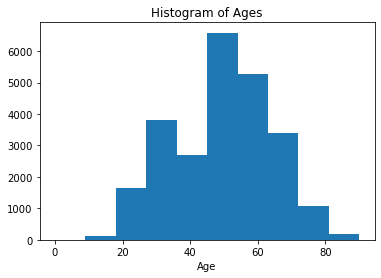

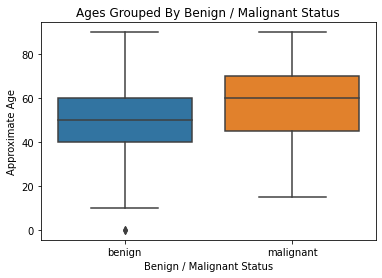

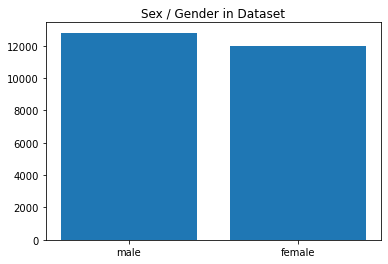

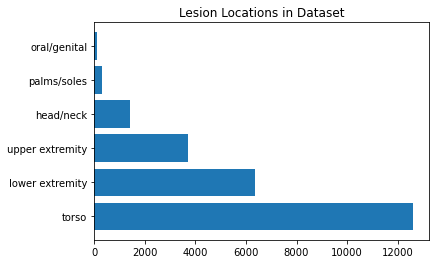

In [2]:
mel_df = pd.read_csv(os.path.join('train_data', 'train.csv'))
gt = mel_df['target']
isic_id = mel_df['image_name']

# proportion of postives
print("Proportion of positives:", np.mean(gt))

plt.hist(mel_df['age_approx'])
plt.title('Histogram of Ages')
plt.xlabel('Age')
plt.show()

sns.boxplot(x = mel_df['benign_malignant'],
            y = mel_df['age_approx'])
plt.title('Ages Grouped By Benign / Malignant Status')
plt.xlabel('Benign / Malignant Status')
plt.ylabel('Approximate Age')
plt.show()


plt.bar(mel_df.sex.value_counts().index,  mel_df.sex.value_counts().values)
plt.title('Sex / Gender in Dataset')
plt.show()

plt.barh(mel_df.anatom_site_general_challenge.value_counts().index, mel_df.anatom_site_general_challenge.value_counts().values)
plt.title('Lesion Locations in Dataset')
plt.show()

Tests to find potential correlation between target variables and other categorical variables such as sex/gender or lesion location. 

******************* TARGET W/ SEX INDEPENDENCE TESTS *******************
benign_malignant  benign  malignant
sex                                
female             11824        170
male               12535        267
Chi-Squared test of independence (P-value): 7.87631386486258e-05 



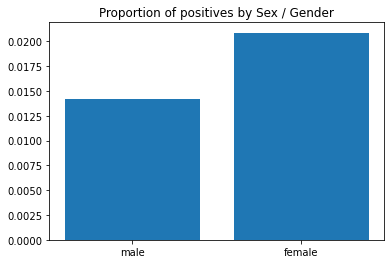



******************* TARGET W/ LESION LOCATION INDEPENDENCE TESTS *******************
anatom_site_general_challenge  head/neck  lower extremity  oral/genital  \
sex                                                                       
female                               629             3363            33   
male                                 767             2966            57   

anatom_site_general_challenge  palms/soles  torso  upper extremity  
sex                                                                 
female                                 111   5683             2001  
male                                   169   6926             1698  
Chi-Squared test of independence (P-value): 3.917186815096256e-37 



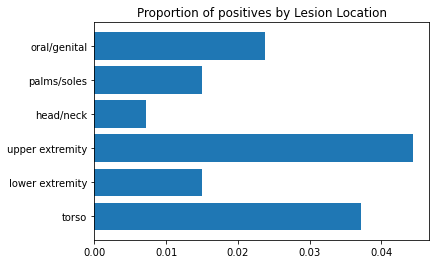

In [3]:
print("******************* TARGET W/ SEX INDEPENDENCE TESTS *******************")

data_crosstab = pd.crosstab(mel_df['sex'],
                            mel_df['benign_malignant'], 
                            margins = False)
print(data_crosstab)

chi2, p, dof, ex = ss.chi2_contingency(data_crosstab)

print("Chi-Squared test of independence (P-value):", p, "\n")

g_df1 = mel_df.groupby(['sex']).mean()
plt.bar(mel_df.sex.value_counts().index,  g_df1['target'].values)
plt.title("Proportion of positives by Sex / Gender")
plt.show()


print("\n\n******************* TARGET W/ LESION LOCATION INDEPENDENCE TESTS *******************")

data_crosstab = pd.crosstab(mel_df['sex'],
                            mel_df['anatom_site_general_challenge'], 
                            margins = False)
print(data_crosstab)

chi2, p, dof, ex = ss.chi2_contingency(data_crosstab)

print("Chi-Squared test of independence (P-value):", p, "\n")

g_df2 = mel_df.groupby(['anatom_site_general_challenge']).mean() 
plt.barh(mel_df.anatom_site_general_challenge.value_counts().index, g_df2['target'].values)
plt.title("Proportion of positives by Lesion Location")
plt.show()


## ResNet-50 (Feature Extraction)

Set device as CPU, or GPU if available. Code will have to change if using multiple GPUs (cuda:0, cuda:1, ...).

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not torch.cuda.is_available():
    n_workers = os.cpu_count()
else:
    n_workers = torch.cuda.device_count()

# If on a CUDA machine, this should print a CUDA device:
print("Device:", device)
print("Number of devices:", n_workers)


Device: cpu
Number of devices: 36


We create a custom dataset loader class to use the ID and target information from the CSV to properly load our training and testing data.

In [5]:
# Create custom dataset to load in with the benign 
# and malignant images in the same directory
class ISICDatasetImages(Dataset):
    
    def __init__(self, img_dir, patientfile, num_samples=100, start_ind=0, up_sample=False, transform=None):
        self.img_dir = img_dir
        
        mel_df = pd.read_csv(patientfile) 
        
        if up_sample:
            
            # Separate majority and minority classes
            df_benign = mel_df[mel_df['target']==0]
            df_malignant = mel_df[mel_df['target']==1]
            

            # sample minority class
            df_benign_sampled = resample(df_benign, 
                                         replace=True,     # sample with replacement
                                         n_samples=num_samples//2)
            

            # Upsample minority class
            df_malignant_upsampled = resample(df_malignant, 
                                              replace=True,     # sample with replacement
                                              n_samples=num_samples//2)
            
            # Combine majority class with upsampled minority class
            mel_df = pd.concat([df_benign_sampled, df_malignant_upsampled])
            
            # randomly mix them up (not necessary due to shuffling in dataloader)
            mel_df = shuffle(mel_df)
            
        else:
            
            self.start_ind = start_ind
            self.end_ind = start_ind+num_samples

            if self.end_ind > len(mel_df):
                self.end_ind = len(mel_df)
        
            mel_df = mel_df[self.start_ind:self.end_ind]
            
        self.gt = mel_df['target'].reset_index(drop=True)
        self.isic_id = mel_df['image_name'].reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.isic_id)
    
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, f"{self.isic_id[idx]}.jpg")
        img = read_image(img_path).float()
        class_id = torch.tensor([self.gt[idx]])
        
        if self.transform:
            img = self.transform(img)
    
        
        return img, class_id


We create a custom collate function to pad lower resolution images with zeros to maintain a constant high resolution of 3x4000x6000 for the CNN to use.

In [6]:
# recall that a CNN needs the inputs to be the same dimension so we 
# custom collate function to pad small res images with 0s if they are not 3x4000x6000
def pad_collate2d(batch):
    
    # init lists
    image_list, label_list = [], []
   
    for _image, _label in batch:
        
        image_list.append(torch.unsqueeze(_image, dim=0))
        label_list.append(_label)
        

    image_out = torch.cat(image_list, dim=0) 
    label_out = torch.tensor(label_list, dtype=torch.int64)
   
    return image_out, label_out


In [7]:
testing = False

# set our batch size
batch_size = 16

tr_transf = transforms.Compose(
    [transforms.Resize(224),
     transforms.RandomHorizontalFlip(p=0.3),
     transforms.RandomVerticalFlip(p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.GaussianBlur(kernel_size=(5, 7), sigma=(0.1, 2))]), p=0.2),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
     transforms.RandomErasing(scale=(0.02, 0.05), p=0.2)
    ])

val_transf = transforms.Compose(
    [transforms.Resize(224),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    ])

train_dataset = ISICDatasetImages(img_dir=os.path.join("train_data256x256", "jpgs"), 
                            patientfile=os.path.join("train_data256x256", "train.csv"), 
                            num_samples=5*2*24408, up_sample=True, start_ind=0, transform=tr_transf)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  collate_fn=pad_collate2d, 
                          num_workers=n_workers)


val_dataset = ISICDatasetImages(img_dir=os.path.join("train_data256x256", "jpgs"), 
                            patientfile=os.path.join("train_data256x256", "val.csv"), 
                            num_samples=2*100, up_sample=True, start_ind=0, transform=val_transf)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=pad_collate2d, 
                        num_workers=n_workers)



# test DataLoader with custom settings
if testing:
    for imgs, labels in train_loader:
        print("Batch of images has shape: ",imgs.shape)
        print("Batch of labels: ", labels)

In [8]:
# functions to show the image
def imshow(img):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg.astype('int'), (1, 2, 0)))
    plt.show()

label_id = ["Benign", "Malignant"]

if testing:
    # get some random training images
    trainiter = iter(train_loader)
    images, labels = next(trainiter)
    print("Size:", images.shape)


    # show images
    imshow(images[0,])

    # print labels
    print("Label:", label_id[labels[0,]])

Sample and image from the data loader object to confirm it worked. Continue to run the cell for different images.

In [11]:
load_weights = True
create_new_weights = False
PATH = './melanoma_ResNet50.pth'

if load_weights:
    print('Loading the pre-trained CNN weights.')
    
    # network weights load
    net = torchvision.models.resnet50(pretrained=True).to(device)
    
    # for feature extraction
    #for param in net.parameters():
        #param.requires_grad = False
        
    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
               nn.Linear(num_ftrs, 300),
               nn.BatchNorm1d(300),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(300, 100),
               nn.BatchNorm1d(100),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(100, 1),
               nn.Sigmoid()).to(device)

    checkpoint = torch.load(PATH, map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])
    
    # optimizer state load
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.fc.parameters(), weight_decay=0.01)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
    lr_sched.load_state_dict(checkpoint['lr_sched'])
    
    # total mini_batch state load
    mini_batch = checkpoint['mini_batch']
    
    print("CUDA Memory Allocated:", torch.cuda.max_memory_allocated())
    
elif create_new_weights:
    print('Creating new ResNet-50 FC Layer weights.')
    
    net = torchvision.models.resnet50(pretrained=True).to(device)
    
    # for feature extraction
    #for param in net.parameters():
        #param.requires_grad = False
        
    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
               nn.Linear(num_ftrs, 300),
               nn.BatchNorm1d(300),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(300, 100),
               nn.BatchNorm1d(100),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(100, 1),
               nn.Sigmoid()).to(device)
    
    
    mini_batch = 0
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.fc.parameters(), weight_decay=0.001)
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
    
    

Loading the pre-trained CNN weights.
CUDA Memory Allocated: 0


In [60]:
learn_weights = False

print("Pre-Training CUDA Memory Allocation:", torch.cuda.max_memory_allocated())

if learn_weights:

    # set start time for cnn training
    start_time = time.time()

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(inputs)

        loss = criterion(outputs, labels.unsqueeze(-1).float())
        loss.backward()
        optimizer.step()
        lr_sched.step()


        # print statistics
        running_loss += loss.item()
        
        # update mini-batch count
        mini_batch += 1
        epoch = mini_batch // 1525



        # save and eval every 500 mini-batch
        if i % 500 == 0:
            
            # print every mini-batch
            print("CUDA Memory Allocated:", torch.cuda.max_memory_allocated())
            print(f'[Epoch {epoch}, Batch {mini_batch % 1525}] Loss: {running_loss / (i+1)}\n')
            print("*********** Saving network weights and optimizer state *********** \n\n")
            # save the weights and optimizer
            torch.save({'mini_batch': mini_batch,
                        'model_state_dict': net.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(),
                        'lr_sched': lr_sched.state_dict()}, PATH)
            
            print("******************************************************************")
            print("*********************** Performance Update ***********************")
            print("******************************************************************\n")
            
            net.eval()
            
            ground_truths = []
            probs = []

            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for j, valdata in enumerate(val_loader, 0):
                    image, label = valdata
                    image = image.to(device)

                    # save for analysis
                    ground_truths.append(label)

                    # calculate outputs by running images through the network 
                    outputs = net(image)
                    outputs = outputs.to("cpu")

                    # # save for analysis
                    probs.append(outputs)

            print("Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs))
            
            net.train()

            print("\n******************************************************************")
            print("****************** Performance Update Complete! ******************")
            print("******************************************************************\n\n")

        # save unique set of weights and optimizer for validation later
        if mini_batch % 1525 == 0:

            uPATH = f'./saved_weights3/melanoma_ResNet50_{epoch}e_{mini_batch % 1525}b.pth'
            torch.save({'mini_batch': mini_batch,
                        'model_state_dict': net.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(),
                        'lr_sched': lr_sched.state_dict()}, uPATH)

    print('*********** Finished Training this Epoch in', time.time() - start_time, 'seconds ***********')
    
    # save the weights and optimizer
    torch.save({'mini_batch': mini_batch,
                'model_state_dict': net.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict(), 
                'lr_sched': lr_sched.state_dict()}, PATH)
    


Pre-Training CUDA Memory Allocation: 0
CUDA Memory Allocated: 0
[Epoch 0, Batch 1] Loss: 0.6946803331375122

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.2671

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 0
[Epoch 0, Batch 2] Loss: 0.7167693674564362

CUDA Memory Allocated: 0
[Epoch 0, Batch 3] Loss: 0.6774286429087321

CUDA Memory Allocated: 0
[Epoch 0, Batch 4] Loss: 0.6879898458719254

CUDA Memory Allocated: 0
[Epoch 0, Batch 5] Loss: 0.6859529495239258

CUDA Memory Allocated: 0
[Epoch 0, Batch 6] Loss: 0.663300613562266

CUDA Memory Allocated: 0
[Epoch 0

CUDA Memory Allocated: 0
[Epoch 0, Batch 108] Loss: 0.5300468995615288

CUDA Memory Allocated: 0
[Epoch 0, Batch 109] Loss: 0.5308218242925241

CUDA Memory Allocated: 0
[Epoch 0, Batch 110] Loss: 0.5301059844818983

CUDA Memory Allocated: 0
[Epoch 0, Batch 111] Loss: 0.5281202484358538

CUDA Memory Allocated: 0
[Epoch 0, Batch 112] Loss: 0.5272188737456288

CUDA Memory Allocated: 0
[Epoch 0, Batch 113] Loss: 0.5284034142979478

CUDA Memory Allocated: 0
[Epoch 0, Batch 114] Loss: 0.5297557452791616

CUDA Memory Allocated: 0
[Epoch 0, Batch 115] Loss: 0.5298556117907814

CUDA Memory Allocated: 0
[Epoch 0, Batch 116] Loss: 0.5299605056643486

CUDA Memory Allocated: 0
[Epoch 0, Batch 117] Loss: 0.5300208353079282

CUDA Memory Allocated: 0
[Epoch 0, Batch 118] Loss: 0.5294835673550428

CUDA Memory Allocated: 0
[Epoch 0, Batch 119] Loss: 0.5292092909832963

CUDA Memory Allocated: 0
[Epoch 0, Batch 120] Loss: 0.5304527031878631

CUDA Memory Allocated: 0
[Epoch 0, Batch 121] Loss: 0.5294327068

CUDA Memory Allocated: 0
[Epoch 0, Batch 222] Loss: 0.5042486670720685

CUDA Memory Allocated: 0
[Epoch 0, Batch 223] Loss: 0.5043277213258059

CUDA Memory Allocated: 0
[Epoch 0, Batch 224] Loss: 0.5036024083383381

CUDA Memory Allocated: 0
[Epoch 0, Batch 225] Loss: 0.5033031273550458

CUDA Memory Allocated: 0
[Epoch 0, Batch 226] Loss: 0.5030218906766546

CUDA Memory Allocated: 0
[Epoch 0, Batch 227] Loss: 0.5023317730242985

CUDA Memory Allocated: 0
[Epoch 0, Batch 228] Loss: 0.5016284896747062

CUDA Memory Allocated: 0
[Epoch 0, Batch 229] Loss: 0.5020593782829926

CUDA Memory Allocated: 0
[Epoch 0, Batch 230] Loss: 0.5034687885123751

CUDA Memory Allocated: 0
[Epoch 0, Batch 231] Loss: 0.5027870668090267

CUDA Memory Allocated: 0
[Epoch 0, Batch 232] Loss: 0.5027948623715803

CUDA Memory Allocated: 0
[Epoch 0, Batch 233] Loss: 0.502121269511051

CUDA Memory Allocated: 0
[Epoch 0, Batch 234] Loss: 0.502479724203929

CUDA Memory Allocated: 0
[Epoch 0, Batch 235] Loss: 0.502723497088

CUDA Memory Allocated: 0
[Epoch 0, Batch 335] Loss: 0.499574360429351

CUDA Memory Allocated: 0
[Epoch 0, Batch 336] Loss: 0.4996552758717111

CUDA Memory Allocated: 0
[Epoch 0, Batch 337] Loss: 0.5002514554148966

CUDA Memory Allocated: 0
[Epoch 0, Batch 338] Loss: 0.5003422291056644

CUDA Memory Allocated: 0
[Epoch 0, Batch 339] Loss: 0.5001853321593771

CUDA Memory Allocated: 0
[Epoch 0, Batch 340] Loss: 0.5003534769748941

CUDA Memory Allocated: 0
[Epoch 0, Batch 341] Loss: 0.5001978133518326

CUDA Memory Allocated: 0
[Epoch 0, Batch 342] Loss: 0.5001596491674931

CUDA Memory Allocated: 0
[Epoch 0, Batch 343] Loss: 0.5010493206995221

CUDA Memory Allocated: 0
[Epoch 0, Batch 344] Loss: 0.5014594580631616

CUDA Memory Allocated: 0
[Epoch 0, Batch 345] Loss: 0.5012121440275855

CUDA Memory Allocated: 0
[Epoch 0, Batch 346] Loss: 0.5016455717083347

CUDA Memory Allocated: 0
[Epoch 0, Batch 347] Loss: 0.5015603989706259

CUDA Memory Allocated: 0
[Epoch 0, Batch 348] Loss: 0.50148314344

CUDA Memory Allocated: 0
[Epoch 0, Batch 448] Loss: 0.4985500823905958

CUDA Memory Allocated: 0
[Epoch 0, Batch 449] Loss: 0.4983267081540518

CUDA Memory Allocated: 0
[Epoch 0, Batch 450] Loss: 0.4981846650110351

CUDA Memory Allocated: 0
[Epoch 0, Batch 451] Loss: 0.4979880040804721

CUDA Memory Allocated: 0
[Epoch 0, Batch 452] Loss: 0.4977418305269912

CUDA Memory Allocated: 0
[Epoch 0, Batch 453] Loss: 0.4979967577239009

CUDA Memory Allocated: 0
[Epoch 0, Batch 454] Loss: 0.49851603533596717

CUDA Memory Allocated: 0
[Epoch 0, Batch 455] Loss: 0.4984042614043414

CUDA Memory Allocated: 0
[Epoch 0, Batch 456] Loss: 0.49817052160046604

CUDA Memory Allocated: 0
[Epoch 0, Batch 457] Loss: 0.4979334155696748

CUDA Memory Allocated: 0
[Epoch 0, Batch 458] Loss: 0.4975860773801283

CUDA Memory Allocated: 0
[Epoch 0, Batch 459] Loss: 0.4973361618443512

CUDA Memory Allocated: 0
[Epoch 0, Batch 460] Loss: 0.4973825278813424

CUDA Memory Allocated: 0
[Epoch 0, Batch 461] Loss: 0.49725954

CUDA Memory Allocated: 0
[Epoch 0, Batch 555] Loss: 0.49661543157186594

CUDA Memory Allocated: 0
[Epoch 0, Batch 556] Loss: 0.49642559116800056

CUDA Memory Allocated: 0
[Epoch 0, Batch 557] Loss: 0.49647107856812983

CUDA Memory Allocated: 0
[Epoch 0, Batch 558] Loss: 0.49637469881644813

CUDA Memory Allocated: 0
[Epoch 0, Batch 559] Loss: 0.4962946364459497

CUDA Memory Allocated: 0
[Epoch 0, Batch 560] Loss: 0.4963568809043084

CUDA Memory Allocated: 0
[Epoch 0, Batch 561] Loss: 0.49625122836673113

CUDA Memory Allocated: 0
[Epoch 0, Batch 562] Loss: 0.49603234843957467

CUDA Memory Allocated: 0
[Epoch 0, Batch 563] Loss: 0.49572423436607815

CUDA Memory Allocated: 0
[Epoch 0, Batch 564] Loss: 0.49577131996869195

CUDA Memory Allocated: 0
[Epoch 0, Batch 565] Loss: 0.49569767547392213

CUDA Memory Allocated: 0
[Epoch 0, Batch 566] Loss: 0.495835516904563

CUDA Memory Allocated: 0
[Epoch 0, Batch 567] Loss: 0.49614136509689283

CUDA Memory Allocated: 0
[Epoch 0, Batch 568] Loss: 0.4

CUDA Memory Allocated: 0
[Epoch 0, Batch 668] Loss: 0.4919409973848009

CUDA Memory Allocated: 0
[Epoch 0, Batch 669] Loss: 0.4919775358007271

CUDA Memory Allocated: 0
[Epoch 0, Batch 670] Loss: 0.4916686779749927

CUDA Memory Allocated: 0
[Epoch 0, Batch 671] Loss: 0.4916615866113526

CUDA Memory Allocated: 0
[Epoch 0, Batch 672] Loss: 0.4922609006143397

CUDA Memory Allocated: 0
[Epoch 0, Batch 673] Loss: 0.49214249581408537

CUDA Memory Allocated: 0
[Epoch 0, Batch 674] Loss: 0.49206441466196355

CUDA Memory Allocated: 0
[Epoch 0, Batch 675] Loss: 0.49184831665621864

CUDA Memory Allocated: 0
[Epoch 0, Batch 676] Loss: 0.49162906723526806

CUDA Memory Allocated: 0
[Epoch 0, Batch 677] Loss: 0.49160084544379745

CUDA Memory Allocated: 0
[Epoch 0, Batch 678] Loss: 0.4915584188866756

CUDA Memory Allocated: 0
[Epoch 0, Batch 679] Loss: 0.4914987991633928

CUDA Memory Allocated: 0
[Epoch 0, Batch 680] Loss: 0.491431015488856

CUDA Memory Allocated: 0
[Epoch 0, Batch 681] Loss: 0.491629

CUDA Memory Allocated: 0
[Epoch 0, Batch 781] Loss: 0.4903491347188681

CUDA Memory Allocated: 0
[Epoch 0, Batch 782] Loss: 0.4905415394765032

CUDA Memory Allocated: 0
[Epoch 0, Batch 783] Loss: 0.4904902083549463

CUDA Memory Allocated: 0
[Epoch 0, Batch 784] Loss: 0.49046908218261537

CUDA Memory Allocated: 0
[Epoch 0, Batch 785] Loss: 0.4903755163501023

CUDA Memory Allocated: 0
[Epoch 0, Batch 786] Loss: 0.490160437921683

CUDA Memory Allocated: 0
[Epoch 0, Batch 787] Loss: 0.4900840172660093

CUDA Memory Allocated: 0
[Epoch 0, Batch 788] Loss: 0.4903843235129935

CUDA Memory Allocated: 0
[Epoch 0, Batch 789] Loss: 0.4904048106100774

CUDA Memory Allocated: 0
[Epoch 0, Batch 790] Loss: 0.49027152440593214

CUDA Memory Allocated: 0
[Epoch 0, Batch 791] Loss: 0.49020668142740104

CUDA Memory Allocated: 0
[Epoch 0, Batch 792] Loss: 0.4902645675183246

CUDA Memory Allocated: 0
[Epoch 0, Batch 793] Loss: 0.4901700026413231

CUDA Memory Allocated: 0
[Epoch 0, Batch 794] Loss: 0.49006035

CUDA Memory Allocated: 0
[Epoch 0, Batch 894] Loss: 0.488522158989837

CUDA Memory Allocated: 0
[Epoch 0, Batch 895] Loss: 0.48834991659865035

CUDA Memory Allocated: 0
[Epoch 0, Batch 896] Loss: 0.4883333505630227

CUDA Memory Allocated: 0
[Epoch 0, Batch 897] Loss: 0.48864330906200837

CUDA Memory Allocated: 0
[Epoch 0, Batch 898] Loss: 0.48864157605742026

CUDA Memory Allocated: 0
[Epoch 0, Batch 899] Loss: 0.48857816723947134

CUDA Memory Allocated: 0
[Epoch 0, Batch 900] Loss: 0.4883918376598093

CUDA Memory Allocated: 0
[Epoch 0, Batch 901] Loss: 0.4883240491945656

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 0
[Epoch 0, Batch 902] Loss: 0.488366857088458

CUDA Memory Allocated: 0
[Epoch 0, Batch 903] Loss: 0.48836999588696534

CUDA Memory Allocated: 0
[Epoch 0, Batch 904] Loss: 0.48851805323718395

CUDA Memory Allocated: 0
[Epoch 0, Batch 905] Loss: 0.48829656613795136

CUDA Memory Allocated: 0
[Epoch 0, Batch 906] Loss: 0.4882283

CUDA Memory Allocated: 0
[Epoch 0, Batch 1002] Loss: 0.4851823889180096

CUDA Memory Allocated: 0
[Epoch 0, Batch 1003] Loss: 0.4854157296485701

CUDA Memory Allocated: 0
[Epoch 0, Batch 1004] Loss: 0.48532246618691194

CUDA Memory Allocated: 0
[Epoch 0, Batch 1005] Loss: 0.48527506022014427

CUDA Memory Allocated: 0
[Epoch 0, Batch 1006] Loss: 0.48520474158094135

CUDA Memory Allocated: 0
[Epoch 0, Batch 1007] Loss: 0.4851246654188266

CUDA Memory Allocated: 0
[Epoch 0, Batch 1008] Loss: 0.4851996548444269

CUDA Memory Allocated: 0
[Epoch 0, Batch 1009] Loss: 0.4851238311548063

CUDA Memory Allocated: 0
[Epoch 0, Batch 1010] Loss: 0.4849856818519016

CUDA Memory Allocated: 0
[Epoch 0, Batch 1011] Loss: 0.48489204083010184

CUDA Memory Allocated: 0
[Epoch 0, Batch 1012] Loss: 0.48482020995892555

CUDA Memory Allocated: 0
[Epoch 0, Batch 1013] Loss: 0.4847873066720228

CUDA Memory Allocated: 0
[Epoch 0, Batch 1014] Loss: 0.4846626476217539

CUDA Memory Allocated: 0
[Epoch 0, Batch 1015]

CUDA Memory Allocated: 0
[Epoch 0, Batch 1113] Loss: 0.48307913824286636

CUDA Memory Allocated: 0
[Epoch 0, Batch 1114] Loss: 0.48302916720964323

CUDA Memory Allocated: 0
[Epoch 0, Batch 1115] Loss: 0.4829363755714733

CUDA Memory Allocated: 0
[Epoch 0, Batch 1116] Loss: 0.48295620576508586

CUDA Memory Allocated: 0
[Epoch 0, Batch 1117] Loss: 0.4828004867585514

CUDA Memory Allocated: 0
[Epoch 0, Batch 1118] Loss: 0.48284712424485116

CUDA Memory Allocated: 0
[Epoch 0, Batch 1119] Loss: 0.482832234163067

CUDA Memory Allocated: 0
[Epoch 0, Batch 1120] Loss: 0.4828568454166608

CUDA Memory Allocated: 0
[Epoch 0, Batch 1121] Loss: 0.48290822272796274

CUDA Memory Allocated: 0
[Epoch 0, Batch 1122] Loss: 0.4828909790000601

CUDA Memory Allocated: 0
[Epoch 0, Batch 1123] Loss: 0.4828653093941596

CUDA Memory Allocated: 0
[Epoch 0, Batch 1124] Loss: 0.48296529207100225

CUDA Memory Allocated: 0
[Epoch 0, Batch 1125] Loss: 0.48284122598171236

CUDA Memory Allocated: 0
[Epoch 0, Batch 1126

CUDA Memory Allocated: 0
[Epoch 0, Batch 1224] Loss: 0.48212685549229967

CUDA Memory Allocated: 0
[Epoch 0, Batch 1225] Loss: 0.48196479039532797

CUDA Memory Allocated: 0
[Epoch 0, Batch 1226] Loss: 0.48196564030151384

CUDA Memory Allocated: 0
[Epoch 0, Batch 1227] Loss: 0.4820901546642464

CUDA Memory Allocated: 0
[Epoch 0, Batch 1228] Loss: 0.4819794515032528

CUDA Memory Allocated: 0
[Epoch 0, Batch 1229] Loss: 0.48190930045601604

CUDA Memory Allocated: 0
[Epoch 0, Batch 1230] Loss: 0.4818058283227246

CUDA Memory Allocated: 0
[Epoch 0, Batch 1231] Loss: 0.48191622234911186

CUDA Memory Allocated: 0
[Epoch 0, Batch 1232] Loss: 0.4818434517032334

CUDA Memory Allocated: 0
[Epoch 0, Batch 1233] Loss: 0.48178073977756963

CUDA Memory Allocated: 0
[Epoch 0, Batch 1234] Loss: 0.4816867152117253

CUDA Memory Allocated: 0
[Epoch 0, Batch 1235] Loss: 0.48161673141635863

CUDA Memory Allocated: 0
[Epoch 0, Batch 1236] Loss: 0.4815893833522465

CUDA Memory Allocated: 0
[Epoch 0, Batch 123

CUDA Memory Allocated: 0
[Epoch 0, Batch 1335] Loss: 0.48019904339134917

CUDA Memory Allocated: 0
[Epoch 0, Batch 1336] Loss: 0.4801006019003912

CUDA Memory Allocated: 0
[Epoch 0, Batch 1337] Loss: 0.4800382175036304

CUDA Memory Allocated: 0
[Epoch 0, Batch 1338] Loss: 0.48016335657047404

CUDA Memory Allocated: 0
[Epoch 0, Batch 1339] Loss: 0.48005866903124506

CUDA Memory Allocated: 0
[Epoch 0, Batch 1340] Loss: 0.4799692790788501

CUDA Memory Allocated: 0
[Epoch 0, Batch 1341] Loss: 0.4799337678107639

CUDA Memory Allocated: 0
[Epoch 0, Batch 1342] Loss: 0.48006579856181464

CUDA Memory Allocated: 0
[Epoch 0, Batch 1343] Loss: 0.47999695559224353

CUDA Memory Allocated: 0
[Epoch 0, Batch 1344] Loss: 0.47993868351027014

CUDA Memory Allocated: 0
[Epoch 0, Batch 1345] Loss: 0.4798885860518452

CUDA Memory Allocated: 0
[Epoch 0, Batch 1346] Loss: 0.47978543558809766

CUDA Memory Allocated: 0
[Epoch 0, Batch 1347] Loss: 0.4800055883797169

CUDA Memory Allocated: 0
[Epoch 0, Batch 134

CUDA Memory Allocated: 0
[Epoch 0, Batch 1446] Loss: 0.4788907580541377

CUDA Memory Allocated: 0
[Epoch 0, Batch 1447] Loss: 0.47883879803713225

CUDA Memory Allocated: 0
[Epoch 0, Batch 1448] Loss: 0.47878139427971117

CUDA Memory Allocated: 0
[Epoch 0, Batch 1449] Loss: 0.47868506931246685

CUDA Memory Allocated: 0
[Epoch 0, Batch 1450] Loss: 0.4785371797557535

CUDA Memory Allocated: 0
[Epoch 0, Batch 1451] Loss: 0.47841068283801735

CUDA Memory Allocated: 0
[Epoch 0, Batch 1452] Loss: 0.47832663216661486

CUDA Memory Allocated: 0
[Epoch 0, Batch 1453] Loss: 0.478322814014232

CUDA Memory Allocated: 0
[Epoch 0, Batch 1454] Loss: 0.47848456650152493

CUDA Memory Allocated: 0
[Epoch 0, Batch 1455] Loss: 0.4785054338244638

CUDA Memory Allocated: 0
[Epoch 0, Batch 1456] Loss: 0.4785506379289123

CUDA Memory Allocated: 0
[Epoch 0, Batch 1457] Loss: 0.4786962992681079

CUDA Memory Allocated: 0
[Epoch 0, Batch 1458] Loss: 0.478586517172177

CUDA Memory Allocated: 0
[Epoch 0, Batch 1459] 

CUDA Memory Allocated: 0
[Epoch 1, Batch 27] Loss: 0.47743591494359

CUDA Memory Allocated: 0
[Epoch 1, Batch 28] Loss: 0.4773952018826989

CUDA Memory Allocated: 0
[Epoch 1, Batch 29] Loss: 0.47742493261740165

CUDA Memory Allocated: 0
[Epoch 1, Batch 30] Loss: 0.4774467306984199

CUDA Memory Allocated: 0
[Epoch 1, Batch 31] Loss: 0.4775263029018987

CUDA Memory Allocated: 0
[Epoch 1, Batch 32] Loss: 0.4775096228299573

CUDA Memory Allocated: 0
[Epoch 1, Batch 33] Loss: 0.4775676959994057

CUDA Memory Allocated: 0
[Epoch 1, Batch 34] Loss: 0.4774822980891901

CUDA Memory Allocated: 0
[Epoch 1, Batch 35] Loss: 0.4775292238459373

CUDA Memory Allocated: 0
[Epoch 1, Batch 36] Loss: 0.4776789367027118

CUDA Memory Allocated: 0
[Epoch 1, Batch 37] Loss: 0.4776307327169615

CUDA Memory Allocated: 0
[Epoch 1, Batch 38] Loss: 0.47751612248172076

CUDA Memory Allocated: 0
[Epoch 1, Batch 39] Loss: 0.4774889384141511

CUDA Memory Allocated: 0
[Epoch 1, Batch 40] Loss: 0.4774200386037461

CUDA M

CUDA Memory Allocated: 0
[Epoch 1, Batch 141] Loss: 0.47734507801187853

CUDA Memory Allocated: 0
[Epoch 1, Batch 142] Loss: 0.47724720368180795

CUDA Memory Allocated: 0
[Epoch 1, Batch 143] Loss: 0.4773266632333219

CUDA Memory Allocated: 0
[Epoch 1, Batch 144] Loss: 0.4773928203702044

CUDA Memory Allocated: 0
[Epoch 1, Batch 145] Loss: 0.4772934953520398

CUDA Memory Allocated: 0
[Epoch 1, Batch 146] Loss: 0.4773314170303065

CUDA Memory Allocated: 0
[Epoch 1, Batch 147] Loss: 0.47724604824976774

CUDA Memory Allocated: 0
[Epoch 1, Batch 148] Loss: 0.4771641214860818

CUDA Memory Allocated: 0
[Epoch 1, Batch 149] Loss: 0.47713892385274564

CUDA Memory Allocated: 0
[Epoch 1, Batch 150] Loss: 0.4771713104621688

CUDA Memory Allocated: 0
[Epoch 1, Batch 151] Loss: 0.4771855339176757

CUDA Memory Allocated: 0
[Epoch 1, Batch 152] Loss: 0.47715413629937614

CUDA Memory Allocated: 0
[Epoch 1, Batch 153] Loss: 0.47716877080224834

CUDA Memory Allocated: 0
[Epoch 1, Batch 154] Loss: 0.4771

CUDA Memory Allocated: 0
[Epoch 1, Batch 254] Loss: 0.4765821496394325

CUDA Memory Allocated: 0
[Epoch 1, Batch 255] Loss: 0.4764510559818048

CUDA Memory Allocated: 0
[Epoch 1, Batch 256] Loss: 0.47636668087892625

CUDA Memory Allocated: 0
[Epoch 1, Batch 257] Loss: 0.47638576742006605

CUDA Memory Allocated: 0
[Epoch 1, Batch 258] Loss: 0.4764000684925498

CUDA Memory Allocated: 0
[Epoch 1, Batch 259] Loss: 0.4763373942302348

CUDA Memory Allocated: 0
[Epoch 1, Batch 260] Loss: 0.47650013470015273

CUDA Memory Allocated: 0
[Epoch 1, Batch 261] Loss: 0.4764914868810409

CUDA Memory Allocated: 0
[Epoch 1, Batch 262] Loss: 0.4764689681796168

CUDA Memory Allocated: 0
[Epoch 1, Batch 263] Loss: 0.47642545269539693

CUDA Memory Allocated: 0
[Epoch 1, Batch 264] Loss: 0.47640454704998725

CUDA Memory Allocated: 0
[Epoch 1, Batch 265] Loss: 0.4763701061879456

CUDA Memory Allocated: 0
[Epoch 1, Batch 266] Loss: 0.4762830362763903

CUDA Memory Allocated: 0
[Epoch 1, Batch 267] Loss: 0.47626

CUDA Memory Allocated: 0
[Epoch 1, Batch 367] Loss: 0.47579931867078545

CUDA Memory Allocated: 0
[Epoch 1, Batch 368] Loss: 0.47577764385129434

CUDA Memory Allocated: 0
[Epoch 1, Batch 369] Loss: 0.47574413924968734

CUDA Memory Allocated: 0
[Epoch 1, Batch 370] Loss: 0.4756608283850008

CUDA Memory Allocated: 0
[Epoch 1, Batch 371] Loss: 0.4757633134644117

CUDA Memory Allocated: 0
[Epoch 1, Batch 372] Loss: 0.4758780403440729

CUDA Memory Allocated: 0
[Epoch 1, Batch 373] Loss: 0.4758072225151248

CUDA Memory Allocated: 0
[Epoch 1, Batch 374] Loss: 0.4757430125704685

CUDA Memory Allocated: 0
[Epoch 1, Batch 375] Loss: 0.4757277722813581

CUDA Memory Allocated: 0
[Epoch 1, Batch 376] Loss: 0.47572523230850416

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 0
[Epoch 1, Batch 377] Loss: 0.47572224045056777

CUDA Memory Allocated: 0
[Epoch 1, Batch 378] Loss: 0.4756766498104497

CUDA Memory Allocated: 0
[Epoch 1, Batch 379] Loss: 0.4756419

Area Under the ROC Curve: 0.8856

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 0
[Epoch 1, Batch 477] Loss: 0.4746958348792154

CUDA Memory Allocated: 0
[Epoch 1, Batch 478] Loss: 0.47461171768125865

CUDA Memory Allocated: 0
[Epoch 1, Batch 479] Loss: 0.47457624765897466

CUDA Memory Allocated: 0
[Epoch 1, Batch 480] Loss: 0.47454622110672423

CUDA Memory Allocated: 0
[Epoch 1, Batch 481] Loss: 0.47456893711866194

CUDA Memory Allocated: 0
[Epoch 1, Batch 482] Loss: 0.4746121808507874

CUDA Memory Allocated: 0
[Epoch 1, Batch 483] Loss: 0.4745971112775494

CUDA Memory Allocated: 0
[Epoch 1, Batch 484] Loss: 0.4745424553685191

CUDA Memory Allocated: 0
[Epoch 1, Batch 485] Loss: 0.47453033520066323

CUDA Memory Allocated: 0
[Epoch 1, Batch 486] Loss: 0.4744552483773836

CUDA Memory Allocated: 0
[Epoch 1, Bat

CUDA Memory Allocated: 0
[Epoch 1, Batch 586] Loss: 0.4735297349139109

CUDA Memory Allocated: 0
[Epoch 1, Batch 587] Loss: 0.4734616124452176

CUDA Memory Allocated: 0
[Epoch 1, Batch 588] Loss: 0.4734166664742656

CUDA Memory Allocated: 0
[Epoch 1, Batch 589] Loss: 0.473344935916625

CUDA Memory Allocated: 0
[Epoch 1, Batch 590] Loss: 0.4732738153942933

CUDA Memory Allocated: 0
[Epoch 1, Batch 591] Loss: 0.473346967728974

CUDA Memory Allocated: 0
[Epoch 1, Batch 592] Loss: 0.47328854679188526

CUDA Memory Allocated: 0
[Epoch 1, Batch 593] Loss: 0.4732512727351657

CUDA Memory Allocated: 0
[Epoch 1, Batch 594] Loss: 0.47329967145848917

CUDA Memory Allocated: 0
[Epoch 1, Batch 595] Loss: 0.4732512837943603

CUDA Memory Allocated: 0
[Epoch 1, Batch 596] Loss: 0.4732615649489399

CUDA Memory Allocated: 0
[Epoch 1, Batch 597] Loss: 0.47322913503641234

CUDA Memory Allocated: 0
[Epoch 1, Batch 598] Loss: 0.47329583352065796

CUDA Memory Allocated: 0
[Epoch 1, Batch 599] Loss: 0.47333787

CUDA Memory Allocated: 0
[Epoch 1, Batch 699] Loss: 0.47198211537044255

CUDA Memory Allocated: 0
[Epoch 1, Batch 700] Loss: 0.47192457894260964

CUDA Memory Allocated: 0
[Epoch 1, Batch 701] Loss: 0.4718997443943332

CUDA Memory Allocated: 0
[Epoch 1, Batch 702] Loss: 0.4718872077217753

CUDA Memory Allocated: 0
[Epoch 1, Batch 703] Loss: 0.47190119261908575

CUDA Memory Allocated: 0
[Epoch 1, Batch 704] Loss: 0.47187184302087

CUDA Memory Allocated: 0
[Epoch 1, Batch 705] Loss: 0.47186449588414264

CUDA Memory Allocated: 0
[Epoch 1, Batch 706] Loss: 0.4718886997094875

CUDA Memory Allocated: 0
[Epoch 1, Batch 707] Loss: 0.4717869132984176

CUDA Memory Allocated: 0
[Epoch 1, Batch 708] Loss: 0.47173714803917977

CUDA Memory Allocated: 0
[Epoch 1, Batch 709] Loss: 0.4716695822515227

CUDA Memory Allocated: 0
[Epoch 1, Batch 710] Loss: 0.47170073874711455

CUDA Memory Allocated: 0
[Epoch 1, Batch 711] Loss: 0.47179159189512776

CUDA Memory Allocated: 0
[Epoch 1, Batch 712] Loss: 0.47181

CUDA Memory Allocated: 0
[Epoch 1, Batch 812] Loss: 0.4707296122252865

CUDA Memory Allocated: 0
[Epoch 1, Batch 813] Loss: 0.4707162155745068

CUDA Memory Allocated: 0
[Epoch 1, Batch 814] Loss: 0.4706614236002959

CUDA Memory Allocated: 0
[Epoch 1, Batch 815] Loss: 0.4706136721831102

CUDA Memory Allocated: 0
[Epoch 1, Batch 816] Loss: 0.47057588837025566

CUDA Memory Allocated: 0
[Epoch 1, Batch 817] Loss: 0.4705462626266642

CUDA Memory Allocated: 0
[Epoch 1, Batch 818] Loss: 0.4705498206579833

CUDA Memory Allocated: 0
[Epoch 1, Batch 819] Loss: 0.4704762074854797

CUDA Memory Allocated: 0
[Epoch 1, Batch 820] Loss: 0.4704674421597137

CUDA Memory Allocated: 0
[Epoch 1, Batch 821] Loss: 0.4704131122491142

CUDA Memory Allocated: 0
[Epoch 1, Batch 822] Loss: 0.47035224745260384

CUDA Memory Allocated: 0
[Epoch 1, Batch 823] Loss: 0.4702663604277971

CUDA Memory Allocated: 0
[Epoch 1, Batch 824] Loss: 0.47024494712786147

CUDA Memory Allocated: 0
[Epoch 1, Batch 825] Loss: 0.4701760

CUDA Memory Allocated: 0
[Epoch 1, Batch 925] Loss: 0.46934333961228936

CUDA Memory Allocated: 0
[Epoch 1, Batch 926] Loss: 0.4693690802444491

CUDA Memory Allocated: 0
[Epoch 1, Batch 927] Loss: 0.469272508749322

CUDA Memory Allocated: 0
[Epoch 1, Batch 928] Loss: 0.46928887251465357

CUDA Memory Allocated: 0
[Epoch 1, Batch 929] Loss: 0.4692358548928298

CUDA Memory Allocated: 0
[Epoch 1, Batch 930] Loss: 0.4692801825080044

CUDA Memory Allocated: 0
[Epoch 1, Batch 931] Loss: 0.4692823395484919

CUDA Memory Allocated: 0
[Epoch 1, Batch 932] Loss: 0.4692809407758092

CUDA Memory Allocated: 0
[Epoch 1, Batch 933] Loss: 0.4692841092498929

CUDA Memory Allocated: 0
[Epoch 1, Batch 934] Loss: 0.46927034836103393

CUDA Memory Allocated: 0
[Epoch 1, Batch 935] Loss: 0.46920777433892574

CUDA Memory Allocated: 0
[Epoch 1, Batch 936] Loss: 0.4691677457951569

CUDA Memory Allocated: 0
[Epoch 1, Batch 937] Loss: 0.4691887766328602

CUDA Memory Allocated: 0
[Epoch 1, Batch 938] Loss: 0.4691040

CUDA Memory Allocated: 0
[Epoch 1, Batch 1031] Loss: 0.46828196001281386

CUDA Memory Allocated: 0
[Epoch 1, Batch 1032] Loss: 0.4682721345451226

CUDA Memory Allocated: 0
[Epoch 1, Batch 1033] Loss: 0.46823756610559614

CUDA Memory Allocated: 0
[Epoch 1, Batch 1034] Loss: 0.46822168740060655

CUDA Memory Allocated: 0
[Epoch 1, Batch 1035] Loss: 0.4682440374803264

CUDA Memory Allocated: 0
[Epoch 1, Batch 1036] Loss: 0.46832631410843967

CUDA Memory Allocated: 0
[Epoch 1, Batch 1037] Loss: 0.46831827243145885

CUDA Memory Allocated: 0
[Epoch 1, Batch 1038] Loss: 0.4683097405762492

CUDA Memory Allocated: 0
[Epoch 1, Batch 1039] Loss: 0.4682825905751791

CUDA Memory Allocated: 0
[Epoch 1, Batch 1040] Loss: 0.4682770912933071

CUDA Memory Allocated: 0
[Epoch 1, Batch 1041] Loss: 0.4683021362798342

CUDA Memory Allocated: 0
[Epoch 1, Batch 1042] Loss: 0.46831652584199457

CUDA Memory Allocated: 0
[Epoch 1, Batch 1043] Loss: 0.4682963156080413

CUDA Memory Allocated: 0
[Epoch 1, Batch 1044

CUDA Memory Allocated: 0
[Epoch 1, Batch 1142] Loss: 0.4669377127914425

CUDA Memory Allocated: 0
[Epoch 1, Batch 1143] Loss: 0.4670556132839448

CUDA Memory Allocated: 0
[Epoch 1, Batch 1144] Loss: 0.46718424828300853

CUDA Memory Allocated: 0
[Epoch 1, Batch 1145] Loss: 0.4671621966841962

CUDA Memory Allocated: 0
[Epoch 1, Batch 1146] Loss: 0.4672225479138384

CUDA Memory Allocated: 0
[Epoch 1, Batch 1147] Loss: 0.46721580606177004

CUDA Memory Allocated: 0
[Epoch 1, Batch 1148] Loss: 0.4672218225185585

CUDA Memory Allocated: 0
[Epoch 1, Batch 1149] Loss: 0.4672480996868106

CUDA Memory Allocated: 0
[Epoch 1, Batch 1150] Loss: 0.46718663664064675

CUDA Memory Allocated: 0
[Epoch 1, Batch 1151] Loss: 0.46717915570945306

CUDA Memory Allocated: 0
[Epoch 1, Batch 1152] Loss: 0.4671582565975136

CUDA Memory Allocated: 0
[Epoch 1, Batch 1153] Loss: 0.4671543575127771

CUDA Memory Allocated: 0
[Epoch 1, Batch 1154] Loss: 0.4671663429063841

CUDA Memory Allocated: 0
[Epoch 1, Batch 1155] 

CUDA Memory Allocated: 0
[Epoch 1, Batch 1253] Loss: 0.46618289221011106

CUDA Memory Allocated: 0
[Epoch 1, Batch 1254] Loss: 0.4661863671442123

CUDA Memory Allocated: 0
[Epoch 1, Batch 1255] Loss: 0.4661339363820261

CUDA Memory Allocated: 0
[Epoch 1, Batch 1256] Loss: 0.46607057168860094

CUDA Memory Allocated: 0
[Epoch 1, Batch 1257] Loss: 0.4660159620897621

CUDA Memory Allocated: 0
[Epoch 1, Batch 1258] Loss: 0.46601360821055715

CUDA Memory Allocated: 0
[Epoch 1, Batch 1259] Loss: 0.4660032271546708

CUDA Memory Allocated: 0
[Epoch 1, Batch 1260] Loss: 0.46601704533481086

CUDA Memory Allocated: 0
[Epoch 1, Batch 1261] Loss: 0.4659884252718517

CUDA Memory Allocated: 0
[Epoch 1, Batch 1262] Loss: 0.46595315690274985

CUDA Memory Allocated: 0
[Epoch 1, Batch 1263] Loss: 0.4659352582616136

CUDA Memory Allocated: 0
[Epoch 1, Batch 1264] Loss: 0.46585574874359886

CUDA Memory Allocated: 0
[Epoch 1, Batch 1265] Loss: 0.4658327309354659

CUDA Memory Allocated: 0
[Epoch 1, Batch 1266

CUDA Memory Allocated: 0
[Epoch 1, Batch 1364] Loss: 0.4650482866911791

CUDA Memory Allocated: 0
[Epoch 1, Batch 1365] Loss: 0.4650747604848604

CUDA Memory Allocated: 0
[Epoch 1, Batch 1366] Loss: 0.4650230111341005

CUDA Memory Allocated: 0
[Epoch 1, Batch 1367] Loss: 0.46502548397453

CUDA Memory Allocated: 0
[Epoch 1, Batch 1368] Loss: 0.46503184364404887

CUDA Memory Allocated: 0
[Epoch 1, Batch 1369] Loss: 0.46502099258782703

CUDA Memory Allocated: 0
[Epoch 1, Batch 1370] Loss: 0.4649883264807634

CUDA Memory Allocated: 0
[Epoch 1, Batch 1371] Loss: 0.46494913789654635

CUDA Memory Allocated: 0
[Epoch 1, Batch 1372] Loss: 0.46492473367044834

CUDA Memory Allocated: 0
[Epoch 1, Batch 1373] Loss: 0.464910840724895

CUDA Memory Allocated: 0
[Epoch 1, Batch 1374] Loss: 0.4648673511365645

CUDA Memory Allocated: 0
[Epoch 1, Batch 1375] Loss: 0.464864600876282

CUDA Memory Allocated: 0
[Epoch 1, Batch 1376] Loss: 0.4648276782475517

*********** Saving network weights and optimizer st

CUDA Memory Allocated: 0
[Epoch 1, Batch 1475] Loss: 0.46348210275173185

CUDA Memory Allocated: 0
[Epoch 1, Batch 1476] Loss: 0.4635151137474655

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8865

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 0
[Epoch 1, Batch 1477] Loss: 0.4635386945286407

CUDA Memory Allocated: 0
[Epoch 1, Batch 1478] Loss: 0.4635040778499264

CUDA Memory Allocated: 0
[Epoch 1, Batch 1479] Loss: 0.4634743302504962

CUDA Memory Allocated: 0
[Epoch 1, Batch 1480] Loss: 0.46345216529738287

CUDA Memory Allocated: 0
[Epoch 1, Batch 1481] Loss

CUDA Memory Allocated: 0
[Epoch 2, Batch 56] Loss: 0.46215460405319797

CUDA Memory Allocated: 0
[Epoch 2, Batch 57] Loss: 0.4621546208752978

CUDA Memory Allocated: 0
[Epoch 2, Batch 58] Loss: 0.46213722518109446

CUDA Memory Allocated: 0
[Epoch 2, Batch 59] Loss: 0.46212787723936194

CUDA Memory Allocated: 0
[Epoch 2, Batch 60] Loss: 0.462071687831181

CUDA Memory Allocated: 0
[Epoch 2, Batch 61] Loss: 0.46206267002750845

CUDA Memory Allocated: 0
[Epoch 2, Batch 62] Loss: 0.4620087056116687

CUDA Memory Allocated: 0
[Epoch 2, Batch 63] Loss: 0.46207204044171557

CUDA Memory Allocated: 0
[Epoch 2, Batch 64] Loss: 0.46206085136496416

CUDA Memory Allocated: 0
[Epoch 2, Batch 65] Loss: 0.4620296885506108

CUDA Memory Allocated: 0
[Epoch 2, Batch 66] Loss: 0.462064308101199

CUDA Memory Allocated: 0
[Epoch 2, Batch 67] Loss: 0.462068353487698

CUDA Memory Allocated: 0
[Epoch 2, Batch 68] Loss: 0.46205727549089387

CUDA Memory Allocated: 0
[Epoch 2, Batch 69] Loss: 0.4620278265593563

CU

CUDA Memory Allocated: 0
[Epoch 2, Batch 169] Loss: 0.4603071074265062

CUDA Memory Allocated: 0
[Epoch 2, Batch 170] Loss: 0.46028157386535445

CUDA Memory Allocated: 0
[Epoch 2, Batch 171] Loss: 0.4602357947060278

CUDA Memory Allocated: 0
[Epoch 2, Batch 172] Loss: 0.46017423380353595

CUDA Memory Allocated: 0
[Epoch 2, Batch 173] Loss: 0.4601751429173579

CUDA Memory Allocated: 0
[Epoch 2, Batch 174] Loss: 0.4602317125917812

CUDA Memory Allocated: 0
[Epoch 2, Batch 175] Loss: 0.46018815586733264

CUDA Memory Allocated: 0
[Epoch 2, Batch 176] Loss: 0.46020004002669546

CUDA Memory Allocated: 0
[Epoch 2, Batch 177] Loss: 0.4601288672004427

CUDA Memory Allocated: 0
[Epoch 2, Batch 178] Loss: 0.46008552997251867

CUDA Memory Allocated: 0
[Epoch 2, Batch 179] Loss: 0.46009049125502594

CUDA Memory Allocated: 0
[Epoch 2, Batch 180] Loss: 0.46003782415629907

CUDA Memory Allocated: 0
[Epoch 2, Batch 181] Loss: 0.46004763348428723

CUDA Memory Allocated: 0
[Epoch 2, Batch 182] Loss: 0.46

CUDA Memory Allocated: 0
[Epoch 2, Batch 282] Loss: 0.4588277673109525

CUDA Memory Allocated: 0
[Epoch 2, Batch 283] Loss: 0.45879382858968804

CUDA Memory Allocated: 0
[Epoch 2, Batch 284] Loss: 0.45872694605667574

CUDA Memory Allocated: 0
[Epoch 2, Batch 285] Loss: 0.45876640189980816

CUDA Memory Allocated: 0
[Epoch 2, Batch 286] Loss: 0.4587577731176603

CUDA Memory Allocated: 0
[Epoch 2, Batch 287] Loss: 0.4587315669853172

CUDA Memory Allocated: 0
[Epoch 2, Batch 288] Loss: 0.4587280209181264

CUDA Memory Allocated: 0
[Epoch 2, Batch 289] Loss: 0.458709067166048

CUDA Memory Allocated: 0
[Epoch 2, Batch 290] Loss: 0.4587571980398215

CUDA Memory Allocated: 0
[Epoch 2, Batch 291] Loss: 0.45873674491196825

CUDA Memory Allocated: 0
[Epoch 2, Batch 292] Loss: 0.45870803547593947

CUDA Memory Allocated: 0
[Epoch 2, Batch 293] Loss: 0.45869390048686165

CUDA Memory Allocated: 0
[Epoch 2, Batch 294] Loss: 0.4586673501531402

CUDA Memory Allocated: 0
[Epoch 2, Batch 295] Loss: 0.45862

CUDA Memory Allocated: 0
[Epoch 2, Batch 395] Loss: 0.45711821101400435

CUDA Memory Allocated: 0
[Epoch 2, Batch 396] Loss: 0.4571925214536648

CUDA Memory Allocated: 0
[Epoch 2, Batch 397] Loss: 0.45718449705194175

CUDA Memory Allocated: 0
[Epoch 2, Batch 398] Loss: 0.4571491675040838

CUDA Memory Allocated: 0
[Epoch 2, Batch 399] Loss: 0.45709880157358995

CUDA Memory Allocated: 0
[Epoch 2, Batch 400] Loss: 0.4570473298560018

CUDA Memory Allocated: 0
[Epoch 2, Batch 401] Loss: 0.4570185513867395

CUDA Memory Allocated: 0
[Epoch 2, Batch 402] Loss: 0.45699665364771563

CUDA Memory Allocated: 0
[Epoch 2, Batch 403] Loss: 0.4569847923739903

CUDA Memory Allocated: 0
[Epoch 2, Batch 404] Loss: 0.45694264779045324

CUDA Memory Allocated: 0
[Epoch 2, Batch 405] Loss: 0.4569995406998912

CUDA Memory Allocated: 0
[Epoch 2, Batch 406] Loss: 0.4569512233396785

CUDA Memory Allocated: 0
[Epoch 2, Batch 407] Loss: 0.4569012085619709

CUDA Memory Allocated: 0
[Epoch 2, Batch 408] Loss: 0.45686

CUDA Memory Allocated: 0
[Epoch 2, Batch 502] Loss: 0.45541508567125144

CUDA Memory Allocated: 0
[Epoch 2, Batch 503] Loss: 0.4553681279768784

CUDA Memory Allocated: 0
[Epoch 2, Batch 504] Loss: 0.45530459795883016

CUDA Memory Allocated: 0
[Epoch 2, Batch 505] Loss: 0.455230350387918

CUDA Memory Allocated: 0
[Epoch 2, Batch 506] Loss: 0.45525198449517934

CUDA Memory Allocated: 0
[Epoch 2, Batch 507] Loss: 0.4552358675487329

CUDA Memory Allocated: 0
[Epoch 2, Batch 508] Loss: 0.4552334737893301

CUDA Memory Allocated: 0
[Epoch 2, Batch 509] Loss: 0.45530975146737784

CUDA Memory Allocated: 0
[Epoch 2, Batch 510] Loss: 0.4552839444887437

CUDA Memory Allocated: 0
[Epoch 2, Batch 511] Loss: 0.45523999422177674

CUDA Memory Allocated: 0
[Epoch 2, Batch 512] Loss: 0.4552080933420863

CUDA Memory Allocated: 0
[Epoch 2, Batch 513] Loss: 0.45521594861685943

CUDA Memory Allocated: 0
[Epoch 2, Batch 514] Loss: 0.4551837770717781

CUDA Memory Allocated: 0
[Epoch 2, Batch 515] Loss: 0.45514

CUDA Memory Allocated: 0
[Epoch 2, Batch 615] Loss: 0.45381276278996696

CUDA Memory Allocated: 0
[Epoch 2, Batch 616] Loss: 0.4539544707884635

CUDA Memory Allocated: 0
[Epoch 2, Batch 617] Loss: 0.45390308173924465

CUDA Memory Allocated: 0
[Epoch 2, Batch 618] Loss: 0.4538937677408903

CUDA Memory Allocated: 0
[Epoch 2, Batch 619] Loss: 0.4539288368657877

CUDA Memory Allocated: 0
[Epoch 2, Batch 620] Loss: 0.4539334408512557

CUDA Memory Allocated: 0
[Epoch 2, Batch 621] Loss: 0.45395525276774573

CUDA Memory Allocated: 0
[Epoch 2, Batch 622] Loss: 0.453943560285441

CUDA Memory Allocated: 0
[Epoch 2, Batch 623] Loss: 0.4539091086764119

CUDA Memory Allocated: 0
[Epoch 2, Batch 624] Loss: 0.4538784682361341

CUDA Memory Allocated: 0
[Epoch 2, Batch 625] Loss: 0.4538606606048792

CUDA Memory Allocated: 0
[Epoch 2, Batch 626] Loss: 0.45383142022430184

CUDA Memory Allocated: 0
[Epoch 2, Batch 627] Loss: 0.45380657084584075

CUDA Memory Allocated: 0
[Epoch 2, Batch 628] Loss: 0.453850

CUDA Memory Allocated: 0
[Epoch 2, Batch 728] Loss: 0.4521810162108433

CUDA Memory Allocated: 0
[Epoch 2, Batch 729] Loss: 0.4521357089667511

CUDA Memory Allocated: 0
[Epoch 2, Batch 730] Loss: 0.4520910910591877

CUDA Memory Allocated: 0
[Epoch 2, Batch 731] Loss: 0.45208665322639485

CUDA Memory Allocated: 0
[Epoch 2, Batch 732] Loss: 0.4520540407399284

CUDA Memory Allocated: 0
[Epoch 2, Batch 733] Loss: 0.4520230690874563

CUDA Memory Allocated: 0
[Epoch 2, Batch 734] Loss: 0.4519891426770556

CUDA Memory Allocated: 0
[Epoch 2, Batch 735] Loss: 0.4519534044016935

CUDA Memory Allocated: 0
[Epoch 2, Batch 736] Loss: 0.4519728619823743

CUDA Memory Allocated: 0
[Epoch 2, Batch 737] Loss: 0.4519010779133314

CUDA Memory Allocated: 0
[Epoch 2, Batch 738] Loss: 0.45188845575658293

CUDA Memory Allocated: 0
[Epoch 2, Batch 739] Loss: 0.4518869272375459

CUDA Memory Allocated: 0
[Epoch 2, Batch 740] Loss: 0.45190857491188124

CUDA Memory Allocated: 0
[Epoch 2, Batch 741] Loss: 0.4518963

CUDA Memory Allocated: 0
[Epoch 2, Batch 841] Loss: 0.4507239411925632

CUDA Memory Allocated: 0
[Epoch 2, Batch 842] Loss: 0.45068655847614864

CUDA Memory Allocated: 0
[Epoch 2, Batch 843] Loss: 0.45070656279717747

CUDA Memory Allocated: 0
[Epoch 2, Batch 844] Loss: 0.4507229502270267

CUDA Memory Allocated: 0
[Epoch 2, Batch 845] Loss: 0.4507518084808247

CUDA Memory Allocated: 0
[Epoch 2, Batch 846] Loss: 0.4506968466576487

CUDA Memory Allocated: 0
[Epoch 2, Batch 847] Loss: 0.45069997033645837

CUDA Memory Allocated: 0
[Epoch 2, Batch 848] Loss: 0.45066922509315505

CUDA Memory Allocated: 0
[Epoch 2, Batch 849] Loss: 0.4506794249867745

CUDA Memory Allocated: 0
[Epoch 2, Batch 850] Loss: 0.4506491972391422

CUDA Memory Allocated: 0
[Epoch 2, Batch 851] Loss: 0.45063973580895555

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 0
[Epoch 2, Batch 852] Loss: 0.45057620057718745

CUDA Memory Allocated: 0
[Epoch 2, Batch 853] Loss: 0.450581

Area Under the ROC Curve: 0.8796

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 0
[Epoch 2, Batch 952] Loss: 0.44965562829072925

CUDA Memory Allocated: 0
[Epoch 2, Batch 953] Loss: 0.4496608006933347

CUDA Memory Allocated: 0
[Epoch 2, Batch 954] Loss: 0.44962454678771735

CUDA Memory Allocated: 0
[Epoch 2, Batch 955] Loss: 0.4496178967527087

CUDA Memory Allocated: 0
[Epoch 2, Batch 956] Loss: 0.44962543936532795

CUDA Memory Allocated: 0
[Epoch 2, Batch 957] Loss: 0.44964722147718583

CUDA Memory Allocated: 0
[Epoch 2, Batch 958] Loss: 0.4495899677127897

CUDA Memory Allocated: 0
[Epoch 2, Batch 959] Loss: 0.4496391497368407

CUDA Memory Allocated: 0
[Epoch 2, Batch 960] Loss: 0.4496643144144976

CUDA Memory Allocated: 0
[Epoch 2, Batch 961] Loss: 0.44963736101386853

CUDA Memory Allocated: 0
[Epoch 2, Bat

CUDA Memory Allocated: 0
[Epoch 2, Batch 1061] Loss: 0.44834757930995833

CUDA Memory Allocated: 0
[Epoch 2, Batch 1062] Loss: 0.44830462177454383

CUDA Memory Allocated: 0
[Epoch 2, Batch 1063] Loss: 0.4482532775687557

CUDA Memory Allocated: 0
[Epoch 2, Batch 1064] Loss: 0.44821290986582557

CUDA Memory Allocated: 0
[Epoch 2, Batch 1065] Loss: 0.4481660670273794

CUDA Memory Allocated: 0
[Epoch 2, Batch 1066] Loss: 0.4481254474190222

CUDA Memory Allocated: 0
[Epoch 2, Batch 1067] Loss: 0.4480654115356344

CUDA Memory Allocated: 0
[Epoch 2, Batch 1068] Loss: 0.448079375361082

CUDA Memory Allocated: 0
[Epoch 2, Batch 1069] Loss: 0.4480699535805671

CUDA Memory Allocated: 0
[Epoch 2, Batch 1070] Loss: 0.4480668957553153

CUDA Memory Allocated: 0
[Epoch 2, Batch 1071] Loss: 0.44808926396984927

CUDA Memory Allocated: 0
[Epoch 2, Batch 1072] Loss: 0.4481110314737819

CUDA Memory Allocated: 0
[Epoch 2, Batch 1073] Loss: 0.4481012968980309

CUDA Memory Allocated: 0
[Epoch 2, Batch 1074] L

CUDA Memory Allocated: 0
[Epoch 2, Batch 1172] Loss: 0.4470358633108469

CUDA Memory Allocated: 0
[Epoch 2, Batch 1173] Loss: 0.4470055768437897

CUDA Memory Allocated: 0
[Epoch 2, Batch 1174] Loss: 0.44695330767849967

CUDA Memory Allocated: 0
[Epoch 2, Batch 1175] Loss: 0.4469504604219685

CUDA Memory Allocated: 0
[Epoch 2, Batch 1176] Loss: 0.4469054657216609

CUDA Memory Allocated: 0
[Epoch 2, Batch 1177] Loss: 0.44694471536572167

CUDA Memory Allocated: 0
[Epoch 2, Batch 1178] Loss: 0.4469378094524568

CUDA Memory Allocated: 0
[Epoch 2, Batch 1179] Loss: 0.44689048892937533

CUDA Memory Allocated: 0
[Epoch 2, Batch 1180] Loss: 0.44685613110344463

CUDA Memory Allocated: 0
[Epoch 2, Batch 1181] Loss: 0.4468001862122809

CUDA Memory Allocated: 0
[Epoch 2, Batch 1182] Loss: 0.4467503354023783

CUDA Memory Allocated: 0
[Epoch 2, Batch 1183] Loss: 0.4467385276296644

CUDA Memory Allocated: 0
[Epoch 2, Batch 1184] Loss: 0.4467077277421276

CUDA Memory Allocated: 0
[Epoch 2, Batch 1185] 

CUDA Memory Allocated: 0
[Epoch 2, Batch 1283] Loss: 0.44568177478887894

CUDA Memory Allocated: 0
[Epoch 2, Batch 1284] Loss: 0.44565973694925765

CUDA Memory Allocated: 0
[Epoch 2, Batch 1285] Loss: 0.4456304482969583

CUDA Memory Allocated: 0
[Epoch 2, Batch 1286] Loss: 0.44559768172551456

CUDA Memory Allocated: 0
[Epoch 2, Batch 1287] Loss: 0.4455691188134052

CUDA Memory Allocated: 0
[Epoch 2, Batch 1288] Loss: 0.44558262973062013

CUDA Memory Allocated: 0
[Epoch 2, Batch 1289] Loss: 0.4455600925670788

CUDA Memory Allocated: 0
[Epoch 2, Batch 1290] Loss: 0.44555002861926635

CUDA Memory Allocated: 0
[Epoch 2, Batch 1291] Loss: 0.44550939824923863

CUDA Memory Allocated: 0
[Epoch 2, Batch 1292] Loss: 0.4455285269693261

CUDA Memory Allocated: 0
[Epoch 2, Batch 1293] Loss: 0.4455235726632145

CUDA Memory Allocated: 0
[Epoch 2, Batch 1294] Loss: 0.44549513249066325

CUDA Memory Allocated: 0
[Epoch 2, Batch 1295] Loss: 0.44543319117830865

CUDA Memory Allocated: 0
[Epoch 2, Batch 12

CUDA Memory Allocated: 0
[Epoch 2, Batch 1394] Loss: 0.4436786690212176

CUDA Memory Allocated: 0
[Epoch 2, Batch 1395] Loss: 0.4436347165914971

CUDA Memory Allocated: 0
[Epoch 2, Batch 1396] Loss: 0.4436628349892899

CUDA Memory Allocated: 0
[Epoch 2, Batch 1397] Loss: 0.4436329012443061

CUDA Memory Allocated: 0
[Epoch 2, Batch 1398] Loss: 0.44366562372515744

CUDA Memory Allocated: 0
[Epoch 2, Batch 1399] Loss: 0.4436508909279803

CUDA Memory Allocated: 0
[Epoch 2, Batch 1400] Loss: 0.4435976975921834

CUDA Memory Allocated: 0
[Epoch 2, Batch 1401] Loss: 0.44356289620119327

CUDA Memory Allocated: 0
[Epoch 2, Batch 1402] Loss: 0.44355881123436214

CUDA Memory Allocated: 0
[Epoch 2, Batch 1403] Loss: 0.4435680044044036

CUDA Memory Allocated: 0
[Epoch 2, Batch 1404] Loss: 0.44355468691184907

CUDA Memory Allocated: 0
[Epoch 2, Batch 1405] Loss: 0.4435895203105796

CUDA Memory Allocated: 0
[Epoch 2, Batch 1406] Loss: 0.4435534586350783

CUDA Memory Allocated: 0
[Epoch 2, Batch 1407] 

CUDA Memory Allocated: 0
[Epoch 2, Batch 1499] Loss: 0.44219485128035935

CUDA Memory Allocated: 0
[Epoch 2, Batch 1500] Loss: 0.4421693623753694

CUDA Memory Allocated: 0
[Epoch 2, Batch 1501] Loss: 0.4421402475835726

CUDA Memory Allocated: 0
[Epoch 2, Batch 1502] Loss: 0.4421296305921721

CUDA Memory Allocated: 0
[Epoch 2, Batch 1503] Loss: 0.4421241723971395

CUDA Memory Allocated: 0
[Epoch 2, Batch 1504] Loss: 0.44213308155418857

CUDA Memory Allocated: 0
[Epoch 2, Batch 1505] Loss: 0.44213220341341686

CUDA Memory Allocated: 0
[Epoch 2, Batch 1506] Loss: 0.44213565647327346

CUDA Memory Allocated: 0
[Epoch 2, Batch 1507] Loss: 0.4421144797760378

CUDA Memory Allocated: 0
[Epoch 2, Batch 1508] Loss: 0.44214445282919673

CUDA Memory Allocated: 0
[Epoch 2, Batch 1509] Loss: 0.4421252036341765

CUDA Memory Allocated: 0
[Epoch 2, Batch 1510] Loss: 0.4420792002655696

CUDA Memory Allocated: 0
[Epoch 2, Batch 1511] Loss: 0.4421235378067945

CUDA Memory Allocated: 0
[Epoch 2, Batch 1512]

CUDA Memory Allocated: 0
[Epoch 3, Batch 88] Loss: 0.4407087051731666

CUDA Memory Allocated: 0
[Epoch 3, Batch 89] Loss: 0.4406909803871072

CUDA Memory Allocated: 0
[Epoch 3, Batch 90] Loss: 0.44068199093638255

CUDA Memory Allocated: 0
[Epoch 3, Batch 91] Loss: 0.4406503846607799

CUDA Memory Allocated: 0
[Epoch 3, Batch 92] Loss: 0.4406050818844375

CUDA Memory Allocated: 0
[Epoch 3, Batch 93] Loss: 0.44059515267853155

CUDA Memory Allocated: 0
[Epoch 3, Batch 94] Loss: 0.4405563580393664

CUDA Memory Allocated: 0
[Epoch 3, Batch 95] Loss: 0.4405259226929452

CUDA Memory Allocated: 0
[Epoch 3, Batch 96] Loss: 0.44050676224893226

CUDA Memory Allocated: 0
[Epoch 3, Batch 97] Loss: 0.44048385277122565

CUDA Memory Allocated: 0
[Epoch 3, Batch 98] Loss: 0.4404944225287963

CUDA Memory Allocated: 0
[Epoch 3, Batch 99] Loss: 0.44050343980264295

CUDA Memory Allocated: 0
[Epoch 3, Batch 100] Loss: 0.4405038427764719

CUDA Memory Allocated: 0
[Epoch 3, Batch 101] Loss: 0.440498056510022



CUDA Memory Allocated: 0
[Epoch 3, Batch 201] Loss: 0.4394686331339118

CUDA Memory Allocated: 0
[Epoch 3, Batch 202] Loss: 0.43947151413716506

CUDA Memory Allocated: 0
[Epoch 3, Batch 203] Loss: 0.43945213659581106

CUDA Memory Allocated: 0
[Epoch 3, Batch 204] Loss: 0.43940506375379756

CUDA Memory Allocated: 0
[Epoch 3, Batch 205] Loss: 0.43936752664805956

CUDA Memory Allocated: 0
[Epoch 3, Batch 206] Loss: 0.43932986339560814

CUDA Memory Allocated: 0
[Epoch 3, Batch 207] Loss: 0.4392924487297877

CUDA Memory Allocated: 0
[Epoch 3, Batch 208] Loss: 0.43925876227565175

CUDA Memory Allocated: 0
[Epoch 3, Batch 209] Loss: 0.4392341383978924

CUDA Memory Allocated: 0
[Epoch 3, Batch 210] Loss: 0.43926986548407326

CUDA Memory Allocated: 0
[Epoch 3, Batch 211] Loss: 0.4392706135881779

CUDA Memory Allocated: 0
[Epoch 3, Batch 212] Loss: 0.43923788814834047

CUDA Memory Allocated: 0
[Epoch 3, Batch 213] Loss: 0.43919331225299696

CUDA Memory Allocated: 0
[Epoch 3, Batch 214] Loss: 0.4

CUDA Memory Allocated: 0
[Epoch 3, Batch 314] Loss: 0.43804376341797235

CUDA Memory Allocated: 0
[Epoch 3, Batch 315] Loss: 0.438073644276655

CUDA Memory Allocated: 0
[Epoch 3, Batch 316] Loss: 0.4380500107772071

CUDA Memory Allocated: 0
[Epoch 3, Batch 317] Loss: 0.4380227883398923

CUDA Memory Allocated: 0
[Epoch 3, Batch 318] Loss: 0.4380015873778653

CUDA Memory Allocated: 0
[Epoch 3, Batch 319] Loss: 0.4379657366791452

CUDA Memory Allocated: 0
[Epoch 3, Batch 320] Loss: 0.43796176315876023

CUDA Memory Allocated: 0
[Epoch 3, Batch 321] Loss: 0.43796661287071365

CUDA Memory Allocated: 0
[Epoch 3, Batch 322] Loss: 0.43792581749018394

CUDA Memory Allocated: 0
[Epoch 3, Batch 323] Loss: 0.4379015763915038

CUDA Memory Allocated: 0
[Epoch 3, Batch 324] Loss: 0.4378470334046275

CUDA Memory Allocated: 0
[Epoch 3, Batch 325] Loss: 0.4378059019330813

CUDA Memory Allocated: 0
[Epoch 3, Batch 326] Loss: 0.43782796861383044

*********** Saving network weights and optimizer state *****

******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8961

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 0
[Epoch 3, Batch 427] Loss: 0.4367531610668444

CUDA Memory Allocated: 0
[Epoch 3, Batch 428] Loss: 0.4367468051170078

CUDA Memory Allocated: 0
[Epoch 3, Batch 429] Loss: 0.4367389479885808

CUDA Memory Allocated: 0
[Epoch 3, Batch 430] Loss: 0.4367118227225798

CUDA Memory Allocated: 0
[Epoch 3, Batch 431] Loss: 0.4367070202315706

CUDA Memory Allocated: 0
[Epoch 3, Batch 432] Loss: 0.43670071151969864

CUDA Memory Allocated: 0
[Epoch 3, Batch 433] Loss: 0.4367265541302844

CUDA Memory Allocated: 0
[Epoch 3, Batch 434] Loss: 0.43

CUDA Memory Allocated: 0
[Epoch 3, Batch 534] Loss: 0.4354626873358982

CUDA Memory Allocated: 0
[Epoch 3, Batch 535] Loss: 0.4354492916752914

CUDA Memory Allocated: 0
[Epoch 3, Batch 536] Loss: 0.43541507812727454

CUDA Memory Allocated: 0
[Epoch 3, Batch 537] Loss: 0.43537282760084517

CUDA Memory Allocated: 0
[Epoch 3, Batch 538] Loss: 0.43535177749172715

CUDA Memory Allocated: 0
[Epoch 3, Batch 539] Loss: 0.435328633729536

CUDA Memory Allocated: 0
[Epoch 3, Batch 540] Loss: 0.4353162749713234

CUDA Memory Allocated: 0
[Epoch 3, Batch 541] Loss: 0.4353079718244178

CUDA Memory Allocated: 0
[Epoch 3, Batch 542] Loss: 0.43529553003485416

CUDA Memory Allocated: 0
[Epoch 3, Batch 543] Loss: 0.43526754595540196

CUDA Memory Allocated: 0
[Epoch 3, Batch 544] Loss: 0.4352502905721659

CUDA Memory Allocated: 0
[Epoch 3, Batch 545] Loss: 0.4352280912688002

CUDA Memory Allocated: 0
[Epoch 3, Batch 546] Loss: 0.4352304560263812

CUDA Memory Allocated: 0
[Epoch 3, Batch 547] Loss: 0.435220

CUDA Memory Allocated: 0
[Epoch 3, Batch 647] Loss: 0.43395530469844007

CUDA Memory Allocated: 0
[Epoch 3, Batch 648] Loss: 0.433952993459225

CUDA Memory Allocated: 0
[Epoch 3, Batch 649] Loss: 0.4339178742678297

CUDA Memory Allocated: 0
[Epoch 3, Batch 650] Loss: 0.4339139166859348

CUDA Memory Allocated: 0
[Epoch 3, Batch 651] Loss: 0.4339453919359062

CUDA Memory Allocated: 0
[Epoch 3, Batch 652] Loss: 0.4339484783085122

CUDA Memory Allocated: 0
[Epoch 3, Batch 653] Loss: 0.43391675329906115

CUDA Memory Allocated: 0
[Epoch 3, Batch 654] Loss: 0.43394808483456626

CUDA Memory Allocated: 0
[Epoch 3, Batch 655] Loss: 0.43392686088841914

CUDA Memory Allocated: 0
[Epoch 3, Batch 656] Loss: 0.43390448611066573

CUDA Memory Allocated: 0
[Epoch 3, Batch 657] Loss: 0.43390682377262946

CUDA Memory Allocated: 0
[Epoch 3, Batch 658] Loss: 0.43388812240806157

CUDA Memory Allocated: 0
[Epoch 3, Batch 659] Loss: 0.4338656898543814

CUDA Memory Allocated: 0
[Epoch 3, Batch 660] Loss: 0.4338

CUDA Memory Allocated: 0
[Epoch 3, Batch 760] Loss: 0.43221011984091334

CUDA Memory Allocated: 0
[Epoch 3, Batch 761] Loss: 0.43219811899931

CUDA Memory Allocated: 0
[Epoch 3, Batch 762] Loss: 0.4322118064102797

CUDA Memory Allocated: 0
[Epoch 3, Batch 763] Loss: 0.4322108644789728

CUDA Memory Allocated: 0
[Epoch 3, Batch 764] Loss: 0.43217523467743924

CUDA Memory Allocated: 0
[Epoch 3, Batch 765] Loss: 0.4321452503012361

CUDA Memory Allocated: 0
[Epoch 3, Batch 766] Loss: 0.4321072204207642

CUDA Memory Allocated: 0
[Epoch 3, Batch 767] Loss: 0.43210462847036263

CUDA Memory Allocated: 0
[Epoch 3, Batch 768] Loss: 0.43208734982584424

CUDA Memory Allocated: 0
[Epoch 3, Batch 769] Loss: 0.43205447500002775

CUDA Memory Allocated: 0
[Epoch 3, Batch 770] Loss: 0.4320640236278691

CUDA Memory Allocated: 0
[Epoch 3, Batch 771] Loss: 0.43204706161378076

CUDA Memory Allocated: 0
[Epoch 3, Batch 772] Loss: 0.4320329467180579

CUDA Memory Allocated: 0
[Epoch 3, Batch 773] Loss: 0.432000

CUDA Memory Allocated: 0
[Epoch 3, Batch 873] Loss: 0.43076496787927226

CUDA Memory Allocated: 0
[Epoch 3, Batch 874] Loss: 0.43074477400379807

CUDA Memory Allocated: 0
[Epoch 3, Batch 875] Loss: 0.4307212362705021

CUDA Memory Allocated: 0
[Epoch 3, Batch 876] Loss: 0.43068576031563544

CUDA Memory Allocated: 0
[Epoch 3, Batch 877] Loss: 0.4307032224427709

CUDA Memory Allocated: 0
[Epoch 3, Batch 878] Loss: 0.43070303479695615

CUDA Memory Allocated: 0
[Epoch 3, Batch 879] Loss: 0.43070124222773704

CUDA Memory Allocated: 0
[Epoch 3, Batch 880] Loss: 0.43067307235941116

CUDA Memory Allocated: 0
[Epoch 3, Batch 881] Loss: 0.43065139381733897

CUDA Memory Allocated: 0
[Epoch 3, Batch 882] Loss: 0.43061441868210487

CUDA Memory Allocated: 0
[Epoch 3, Batch 883] Loss: 0.4305828244078286

CUDA Memory Allocated: 0
[Epoch 3, Batch 884] Loss: 0.4305811461636513

CUDA Memory Allocated: 0
[Epoch 3, Batch 885] Loss: 0.43056266325024456

CUDA Memory Allocated: 0
[Epoch 3, Batch 886] Loss: 0.4

CUDA Memory Allocated: 0
[Epoch 3, Batch 979] Loss: 0.4290188445696566

CUDA Memory Allocated: 0
[Epoch 3, Batch 980] Loss: 0.4289876861978929

CUDA Memory Allocated: 0
[Epoch 3, Batch 981] Loss: 0.428991853914581

CUDA Memory Allocated: 0
[Epoch 3, Batch 982] Loss: 0.42898518401865954

CUDA Memory Allocated: 0
[Epoch 3, Batch 983] Loss: 0.42893766569722336

CUDA Memory Allocated: 0
[Epoch 3, Batch 984] Loss: 0.4289024781813015

CUDA Memory Allocated: 0
[Epoch 3, Batch 985] Loss: 0.42888551454374685

CUDA Memory Allocated: 0
[Epoch 3, Batch 986] Loss: 0.4288598291336086

CUDA Memory Allocated: 0
[Epoch 3, Batch 987] Loss: 0.4288716642028648

CUDA Memory Allocated: 0
[Epoch 3, Batch 988] Loss: 0.4288821452071764

CUDA Memory Allocated: 0
[Epoch 3, Batch 989] Loss: 0.42888448863825207

CUDA Memory Allocated: 0
[Epoch 3, Batch 990] Loss: 0.42889370090610146

CUDA Memory Allocated: 0
[Epoch 3, Batch 991] Loss: 0.42888837073170966

CUDA Memory Allocated: 0
[Epoch 3, Batch 992] Loss: 0.42884

CUDA Memory Allocated: 0
[Epoch 3, Batch 1090] Loss: 0.42769424464990896

CUDA Memory Allocated: 0
[Epoch 3, Batch 1091] Loss: 0.4276827237829487

CUDA Memory Allocated: 0
[Epoch 3, Batch 1092] Loss: 0.42767256225398637

CUDA Memory Allocated: 0
[Epoch 3, Batch 1093] Loss: 0.427630093187914

CUDA Memory Allocated: 0
[Epoch 3, Batch 1094] Loss: 0.4276106031531063

CUDA Memory Allocated: 0
[Epoch 3, Batch 1095] Loss: 0.4275713106495783

CUDA Memory Allocated: 0
[Epoch 3, Batch 1096] Loss: 0.42756239964236364

CUDA Memory Allocated: 0
[Epoch 3, Batch 1097] Loss: 0.4275517665632647

CUDA Memory Allocated: 0
[Epoch 3, Batch 1098] Loss: 0.4275506412055197

CUDA Memory Allocated: 0
[Epoch 3, Batch 1099] Loss: 0.4275454396712221

CUDA Memory Allocated: 0
[Epoch 3, Batch 1100] Loss: 0.42752915211448583

CUDA Memory Allocated: 0
[Epoch 3, Batch 1101] Loss: 0.42751484278424096

CUDA Memory Allocated: 0
[Epoch 3, Batch 1102] Loss: 0.4274754759441994

CUDA Memory Allocated: 0
[Epoch 3, Batch 1103] 

CUDA Memory Allocated: 0
[Epoch 3, Batch 1201] Loss: 0.42653402514301675

CUDA Memory Allocated: 0
[Epoch 3, Batch 1202] Loss: 0.42649838485704566

CUDA Memory Allocated: 0
[Epoch 3, Batch 1203] Loss: 0.42648600792855945

CUDA Memory Allocated: 0
[Epoch 3, Batch 1204] Loss: 0.4264523337319104

CUDA Memory Allocated: 0
[Epoch 3, Batch 1205] Loss: 0.42643955442989984

CUDA Memory Allocated: 0
[Epoch 3, Batch 1206] Loss: 0.4263984527792656

CUDA Memory Allocated: 0
[Epoch 3, Batch 1207] Loss: 0.426377045651057

CUDA Memory Allocated: 0
[Epoch 3, Batch 1208] Loss: 0.426389074866157

CUDA Memory Allocated: 0
[Epoch 3, Batch 1209] Loss: 0.42639991312569847

CUDA Memory Allocated: 0
[Epoch 3, Batch 1210] Loss: 0.42641899478827044

CUDA Memory Allocated: 0
[Epoch 3, Batch 1211] Loss: 0.42639443939413285

CUDA Memory Allocated: 0
[Epoch 3, Batch 1212] Loss: 0.42636691341287675

CUDA Memory Allocated: 0
[Epoch 3, Batch 1213] Loss: 0.4263390957737636

CUDA Memory Allocated: 0
[Epoch 3, Batch 1214

CUDA Memory Allocated: 0
[Epoch 3, Batch 1312] Loss: 0.4249129187064481

CUDA Memory Allocated: 0
[Epoch 3, Batch 1313] Loss: 0.42487405651785515

CUDA Memory Allocated: 0
[Epoch 3, Batch 1314] Loss: 0.4248646430141109

CUDA Memory Allocated: 0
[Epoch 3, Batch 1315] Loss: 0.4248521685574982

CUDA Memory Allocated: 0
[Epoch 3, Batch 1316] Loss: 0.4248390887365785

CUDA Memory Allocated: 0
[Epoch 3, Batch 1317] Loss: 0.42480431008484604

CUDA Memory Allocated: 0
[Epoch 3, Batch 1318] Loss: 0.424792119046939

CUDA Memory Allocated: 0
[Epoch 3, Batch 1319] Loss: 0.4247892614862334

CUDA Memory Allocated: 0
[Epoch 3, Batch 1320] Loss: 0.4247907126020637

CUDA Memory Allocated: 0
[Epoch 3, Batch 1321] Loss: 0.42477497942189674

CUDA Memory Allocated: 0
[Epoch 3, Batch 1322] Loss: 0.42477376817929174

CUDA Memory Allocated: 0
[Epoch 3, Batch 1323] Loss: 0.4247440418860758

CUDA Memory Allocated: 0
[Epoch 3, Batch 1324] Loss: 0.42469810673363595

CUDA Memory Allocated: 0
[Epoch 3, Batch 1325] 

CUDA Memory Allocated: 0
[Epoch 3, Batch 1423] Loss: 0.42361824666611075

CUDA Memory Allocated: 0
[Epoch 3, Batch 1424] Loss: 0.423605069908068

CUDA Memory Allocated: 0
[Epoch 3, Batch 1425] Loss: 0.4235647916520635

CUDA Memory Allocated: 0
[Epoch 3, Batch 1426] Loss: 0.42352764046235875

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8949

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 0
[Epoch 3, Batch 1427] Loss: 0.42352469278122734

CUDA Memory Allocated: 0
[Epoch 3, Batch 1428] Loss: 0.4235027927682536

CUDA Memory Allocated: 0
[Epoch 3, Batch 1429] Loss

CUDA Memory Allocated: 0
[Epoch 4, Batch 2] Loss: 0.422394014640993

CUDA Memory Allocated: 0
[Epoch 4, Batch 3] Loss: 0.4223677572311582

CUDA Memory Allocated: 0
[Epoch 4, Batch 4] Loss: 0.4223577119629747

CUDA Memory Allocated: 0
[Epoch 4, Batch 5] Loss: 0.4223623975513413

CUDA Memory Allocated: 0
[Epoch 4, Batch 6] Loss: 0.42237787655180414

CUDA Memory Allocated: 0
[Epoch 4, Batch 7] Loss: 0.42238291063723715

CUDA Memory Allocated: 0
[Epoch 4, Batch 8] Loss: 0.42235832179078653

CUDA Memory Allocated: 0
[Epoch 4, Batch 9] Loss: 0.42233491772022

CUDA Memory Allocated: 0
[Epoch 4, Batch 10] Loss: 0.4223185730716991

CUDA Memory Allocated: 0
[Epoch 4, Batch 11] Loss: 0.4223179469115799

CUDA Memory Allocated: 0
[Epoch 4, Batch 12] Loss: 0.42228808497561443

CUDA Memory Allocated: 0
[Epoch 4, Batch 13] Loss: 0.42227771629361655

CUDA Memory Allocated: 0
[Epoch 4, Batch 14] Loss: 0.42225821483191767

CUDA Memory Allocated: 0
[Epoch 4, Batch 15] Loss: 0.42222097325500463

CUDA Memor

CUDA Memory Allocated: 0
[Epoch 4, Batch 116] Loss: 0.42124056010872624

CUDA Memory Allocated: 0
[Epoch 4, Batch 117] Loss: 0.4212268981684131

CUDA Memory Allocated: 0
[Epoch 4, Batch 118] Loss: 0.4212020613150069

CUDA Memory Allocated: 0
[Epoch 4, Batch 119] Loss: 0.4211564605969059

CUDA Memory Allocated: 0
[Epoch 4, Batch 120] Loss: 0.4211127724151136

CUDA Memory Allocated: 0
[Epoch 4, Batch 121] Loss: 0.4210838523397413

CUDA Memory Allocated: 0
[Epoch 4, Batch 122] Loss: 0.4211072576166694

CUDA Memory Allocated: 0
[Epoch 4, Batch 123] Loss: 0.4210849568264557

CUDA Memory Allocated: 0
[Epoch 4, Batch 124] Loss: 0.42105278864043233

CUDA Memory Allocated: 0
[Epoch 4, Batch 125] Loss: 0.42103226238465213

CUDA Memory Allocated: 0
[Epoch 4, Batch 126] Loss: 0.4210351452810604

CUDA Memory Allocated: 0
[Epoch 4, Batch 127] Loss: 0.4210524845414279

CUDA Memory Allocated: 0
[Epoch 4, Batch 128] Loss: 0.42101459668120206

CUDA Memory Allocated: 0
[Epoch 4, Batch 129] Loss: 0.421004

CUDA Memory Allocated: 0
[Epoch 4, Batch 229] Loss: 0.4199158353585356

CUDA Memory Allocated: 0
[Epoch 4, Batch 230] Loss: 0.41988529102732597

CUDA Memory Allocated: 0
[Epoch 4, Batch 231] Loss: 0.4198468562772801

CUDA Memory Allocated: 0
[Epoch 4, Batch 232] Loss: 0.4198257375252036

CUDA Memory Allocated: 0
[Epoch 4, Batch 233] Loss: 0.41981483647679524

CUDA Memory Allocated: 0
[Epoch 4, Batch 234] Loss: 0.41980635925285215

CUDA Memory Allocated: 0
[Epoch 4, Batch 235] Loss: 0.4197841442351089

CUDA Memory Allocated: 0
[Epoch 4, Batch 236] Loss: 0.41975312377091006

CUDA Memory Allocated: 0
[Epoch 4, Batch 237] Loss: 0.419824591641624

CUDA Memory Allocated: 0
[Epoch 4, Batch 238] Loss: 0.4198038625478293

CUDA Memory Allocated: 0
[Epoch 4, Batch 239] Loss: 0.4197873354879609

CUDA Memory Allocated: 0
[Epoch 4, Batch 240] Loss: 0.4198035454806469

CUDA Memory Allocated: 0
[Epoch 4, Batch 241] Loss: 0.419814842922457

CUDA Memory Allocated: 0
[Epoch 4, Batch 242] Loss: 0.41977919

CUDA Memory Allocated: 0
[Epoch 4, Batch 342] Loss: 0.4185966483020368

CUDA Memory Allocated: 0
[Epoch 4, Batch 343] Loss: 0.4185717894241674

CUDA Memory Allocated: 0
[Epoch 4, Batch 344] Loss: 0.4185600120604297

CUDA Memory Allocated: 0
[Epoch 4, Batch 345] Loss: 0.41856295828490037

CUDA Memory Allocated: 0
[Epoch 4, Batch 346] Loss: 0.4185771254364319

CUDA Memory Allocated: 0
[Epoch 4, Batch 347] Loss: 0.41855648070763335

CUDA Memory Allocated: 0
[Epoch 4, Batch 348] Loss: 0.41854555555908174

CUDA Memory Allocated: 0
[Epoch 4, Batch 349] Loss: 0.41855033110566686

CUDA Memory Allocated: 0
[Epoch 4, Batch 350] Loss: 0.41855291604995726

CUDA Memory Allocated: 0
[Epoch 4, Batch 351] Loss: 0.4185230668395679

CUDA Memory Allocated: 0
[Epoch 4, Batch 352] Loss: 0.41852139873731525

CUDA Memory Allocated: 0
[Epoch 4, Batch 353] Loss: 0.41853752729505894

CUDA Memory Allocated: 0
[Epoch 4, Batch 354] Loss: 0.4185091170375843

CUDA Memory Allocated: 0
[Epoch 4, Batch 355] Loss: 0.418

CUDA Memory Allocated: 0
[Epoch 4, Batch 449] Loss: 0.4174285456208277

CUDA Memory Allocated: 0
[Epoch 4, Batch 450] Loss: 0.41738772938724694

CUDA Memory Allocated: 0
[Epoch 4, Batch 451] Loss: 0.4173609842905251

CUDA Memory Allocated: 0
[Epoch 4, Batch 452] Loss: 0.41733093965930523

CUDA Memory Allocated: 0
[Epoch 4, Batch 453] Loss: 0.4173251162653349

CUDA Memory Allocated: 0
[Epoch 4, Batch 454] Loss: 0.41730446723819253

CUDA Memory Allocated: 0
[Epoch 4, Batch 455] Loss: 0.41729408460750916

CUDA Memory Allocated: 0
[Epoch 4, Batch 456] Loss: 0.4172819097906515

CUDA Memory Allocated: 0
[Epoch 4, Batch 457] Loss: 0.41725729724265315

CUDA Memory Allocated: 0
[Epoch 4, Batch 458] Loss: 0.417224295685007

CUDA Memory Allocated: 0
[Epoch 4, Batch 459] Loss: 0.41722433518701835

CUDA Memory Allocated: 0
[Epoch 4, Batch 460] Loss: 0.4172090215017883

CUDA Memory Allocated: 0
[Epoch 4, Batch 461] Loss: 0.41718697391201714

CUDA Memory Allocated: 0
[Epoch 4, Batch 462] Loss: 0.4171

CUDA Memory Allocated: 0
[Epoch 4, Batch 562] Loss: 0.4161637867805085

CUDA Memory Allocated: 0
[Epoch 4, Batch 563] Loss: 0.4161279695842353

CUDA Memory Allocated: 0
[Epoch 4, Batch 564] Loss: 0.41609875622819237

CUDA Memory Allocated: 0
[Epoch 4, Batch 565] Loss: 0.41610523011348166

CUDA Memory Allocated: 0
[Epoch 4, Batch 566] Loss: 0.416111149595748

CUDA Memory Allocated: 0
[Epoch 4, Batch 567] Loss: 0.41609025679867323

CUDA Memory Allocated: 0
[Epoch 4, Batch 568] Loss: 0.416110702951779

CUDA Memory Allocated: 0
[Epoch 4, Batch 569] Loss: 0.4161192803261144

CUDA Memory Allocated: 0
[Epoch 4, Batch 570] Loss: 0.41608808232077593

CUDA Memory Allocated: 0
[Epoch 4, Batch 571] Loss: 0.4160844704666482

CUDA Memory Allocated: 0
[Epoch 4, Batch 572] Loss: 0.4161173336462473

CUDA Memory Allocated: 0
[Epoch 4, Batch 573] Loss: 0.41612275217214695

CUDA Memory Allocated: 0
[Epoch 4, Batch 574] Loss: 0.41609415172155223

CUDA Memory Allocated: 0
[Epoch 4, Batch 575] Loss: 0.416147

CUDA Memory Allocated: 0
[Epoch 4, Batch 675] Loss: 0.4151375949338793

CUDA Memory Allocated: 0
[Epoch 4, Batch 676] Loss: 0.4151014173238449

CUDA Memory Allocated: 0
[Epoch 4, Batch 677] Loss: 0.41506676192927083

CUDA Memory Allocated: 0
[Epoch 4, Batch 678] Loss: 0.41508400967626596

CUDA Memory Allocated: 0
[Epoch 4, Batch 679] Loss: 0.4150558349208365

CUDA Memory Allocated: 0
[Epoch 4, Batch 680] Loss: 0.41504279185624954

CUDA Memory Allocated: 0
[Epoch 4, Batch 681] Loss: 0.4150229567729729

CUDA Memory Allocated: 0
[Epoch 4, Batch 682] Loss: 0.4150137398770973

CUDA Memory Allocated: 0
[Epoch 4, Batch 683] Loss: 0.41498186305598067

CUDA Memory Allocated: 0
[Epoch 4, Batch 684] Loss: 0.41496145252120803

CUDA Memory Allocated: 0
[Epoch 4, Batch 685] Loss: 0.4149517061741983

CUDA Memory Allocated: 0
[Epoch 4, Batch 686] Loss: 0.4149333381025692

CUDA Memory Allocated: 0
[Epoch 4, Batch 687] Loss: 0.4149141641679772

CUDA Memory Allocated: 0
[Epoch 4, Batch 688] Loss: 0.41489

CUDA Memory Allocated: 0
[Epoch 4, Batch 788] Loss: 0.4136994175794648

CUDA Memory Allocated: 0
[Epoch 4, Batch 789] Loss: 0.41370074721133004

CUDA Memory Allocated: 0
[Epoch 4, Batch 790] Loss: 0.4136736107235896

CUDA Memory Allocated: 0
[Epoch 4, Batch 791] Loss: 0.413688171638181

CUDA Memory Allocated: 0
[Epoch 4, Batch 792] Loss: 0.4136837313315997

CUDA Memory Allocated: 0
[Epoch 4, Batch 793] Loss: 0.4136514643548484

CUDA Memory Allocated: 0
[Epoch 4, Batch 794] Loss: 0.4136683465191548

CUDA Memory Allocated: 0
[Epoch 4, Batch 795] Loss: 0.41366275762889243

CUDA Memory Allocated: 0
[Epoch 4, Batch 796] Loss: 0.4136492485642917

CUDA Memory Allocated: 0
[Epoch 4, Batch 797] Loss: 0.4136370849104676

CUDA Memory Allocated: 0
[Epoch 4, Batch 798] Loss: 0.41365353614048667

CUDA Memory Allocated: 0
[Epoch 4, Batch 799] Loss: 0.4136458512820581

CUDA Memory Allocated: 0
[Epoch 4, Batch 800] Loss: 0.4136606971250064

CUDA Memory Allocated: 0
[Epoch 4, Batch 801] Loss: 0.41363167

CUDA Memory Allocated: 0
[Epoch 4, Batch 901] Loss: 0.41287249959276295

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.9003

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 0
[Epoch 4, Batch 902] Loss: 0.41287760789378714

CUDA Memory Allocated: 0
[Epoch 4, Batch 903] Loss: 0.41286391061526545

CUDA Memory Allocated: 0
[Epoch 4, Batch 904] Loss: 0.4128335698468899

CUDA Memory Allocated: 0
[Epoch 4, Batch 905] Loss: 0.41281263756377623

CUDA Memory Allocated: 0
[Epoch 4, Batch 906] Loss: 0.4128462068742934

CUDA Memory Allocated: 0
[Epoch 4, Batch 907] Loss: 0.4

CUDA Memory Allocated: 0
[Epoch 4, Batch 1006] Loss: 0.41180942852816516

CUDA Memory Allocated: 0
[Epoch 4, Batch 1007] Loss: 0.411808864429092

CUDA Memory Allocated: 0
[Epoch 4, Batch 1008] Loss: 0.41178985395807866

CUDA Memory Allocated: 0
[Epoch 4, Batch 1009] Loss: 0.4117601192258283

CUDA Memory Allocated: 0
[Epoch 4, Batch 1010] Loss: 0.41174301140209457

CUDA Memory Allocated: 0
[Epoch 4, Batch 1011] Loss: 0.41175227960635297

CUDA Memory Allocated: 0
[Epoch 4, Batch 1012] Loss: 0.4117278945627041

CUDA Memory Allocated: 0
[Epoch 4, Batch 1013] Loss: 0.41172327376293527

CUDA Memory Allocated: 0
[Epoch 4, Batch 1014] Loss: 0.41170017233148265

CUDA Memory Allocated: 0
[Epoch 4, Batch 1015] Loss: 0.41168308962589406

CUDA Memory Allocated: 0
[Epoch 4, Batch 1016] Loss: 0.41166591541260533

CUDA Memory Allocated: 0
[Epoch 4, Batch 1017] Loss: 0.41163686832400775

CUDA Memory Allocated: 0
[Epoch 4, Batch 1018] Loss: 0.4116243693300364

CUDA Memory Allocated: 0
[Epoch 4, Batch 10

CUDA Memory Allocated: 0
[Epoch 4, Batch 1117] Loss: 0.4106489383948878

CUDA Memory Allocated: 0
[Epoch 4, Batch 1118] Loss: 0.4106324035442084

CUDA Memory Allocated: 0
[Epoch 4, Batch 1119] Loss: 0.41062789438941305

CUDA Memory Allocated: 0
[Epoch 4, Batch 1120] Loss: 0.410608079115192

CUDA Memory Allocated: 0
[Epoch 4, Batch 1121] Loss: 0.4105974300373064

CUDA Memory Allocated: 0
[Epoch 4, Batch 1122] Loss: 0.4105652636378731

CUDA Memory Allocated: 0
[Epoch 4, Batch 1123] Loss: 0.4105511702329981

CUDA Memory Allocated: 0
[Epoch 4, Batch 1124] Loss: 0.4105471204986934

CUDA Memory Allocated: 0
[Epoch 4, Batch 1125] Loss: 0.4105460397347447

CUDA Memory Allocated: 0
[Epoch 4, Batch 1126] Loss: 0.4105177184150815

CUDA Memory Allocated: 0
[Epoch 4, Batch 1127] Loss: 0.4105346642091295

CUDA Memory Allocated: 0
[Epoch 4, Batch 1128] Loss: 0.41051935281462276

CUDA Memory Allocated: 0
[Epoch 4, Batch 1129] Loss: 0.41050762403331237

CUDA Memory Allocated: 0
[Epoch 4, Batch 1130] Lo

CUDA Memory Allocated: 0
[Epoch 4, Batch 1228] Loss: 0.40945074445767304

CUDA Memory Allocated: 0
[Epoch 4, Batch 1229] Loss: 0.40943429122470154

CUDA Memory Allocated: 0
[Epoch 4, Batch 1230] Loss: 0.40941001199196014

CUDA Memory Allocated: 0
[Epoch 4, Batch 1231] Loss: 0.40939255699245003

CUDA Memory Allocated: 0
[Epoch 4, Batch 1232] Loss: 0.4093669405927505

CUDA Memory Allocated: 0
[Epoch 4, Batch 1233] Loss: 0.4093693846710444

CUDA Memory Allocated: 0
[Epoch 4, Batch 1234] Loss: 0.40935820242771503

CUDA Memory Allocated: 0
[Epoch 4, Batch 1235] Loss: 0.4093556814601654

CUDA Memory Allocated: 0
[Epoch 4, Batch 1236] Loss: 0.4093447209598909

CUDA Memory Allocated: 0
[Epoch 4, Batch 1237] Loss: 0.4093345218935048

CUDA Memory Allocated: 0
[Epoch 4, Batch 1238] Loss: 0.4093162779198514

CUDA Memory Allocated: 0
[Epoch 4, Batch 1239] Loss: 0.4093051388593765

CUDA Memory Allocated: 0
[Epoch 4, Batch 1240] Loss: 0.4092724936006829

CUDA Memory Allocated: 0
[Epoch 4, Batch 1241]

CUDA Memory Allocated: 0
[Epoch 4, Batch 1339] Loss: 0.40807792225469264

CUDA Memory Allocated: 0
[Epoch 4, Batch 1340] Loss: 0.4080467698715066

CUDA Memory Allocated: 0
[Epoch 4, Batch 1341] Loss: 0.4080338625798317

CUDA Memory Allocated: 0
[Epoch 4, Batch 1342] Loss: 0.40801213879725906

CUDA Memory Allocated: 0
[Epoch 4, Batch 1343] Loss: 0.40799343055628423

CUDA Memory Allocated: 0
[Epoch 4, Batch 1344] Loss: 0.40797957889875824

CUDA Memory Allocated: 0
[Epoch 4, Batch 1345] Loss: 0.40800877710050026

CUDA Memory Allocated: 0
[Epoch 4, Batch 1346] Loss: 0.4079833633571327

CUDA Memory Allocated: 0
[Epoch 4, Batch 1347] Loss: 0.40797538377021453

CUDA Memory Allocated: 0
[Epoch 4, Batch 1348] Loss: 0.40796085969053775

CUDA Memory Allocated: 0
[Epoch 4, Batch 1349] Loss: 0.40794534105064884

CUDA Memory Allocated: 0
[Epoch 4, Batch 1350] Loss: 0.4079637175938427

CUDA Memory Allocated: 0
[Epoch 4, Batch 1351] Loss: 0.4079529492527251

CUDA Memory Allocated: 0
[Epoch 4, Batch 13

CUDA Memory Allocated: 0
[Epoch 4, Batch 1444] Loss: 0.40698481160527133

CUDA Memory Allocated: 0
[Epoch 4, Batch 1445] Loss: 0.40698293623069487

CUDA Memory Allocated: 0
[Epoch 4, Batch 1446] Loss: 0.40697891017525256

CUDA Memory Allocated: 0
[Epoch 4, Batch 1447] Loss: 0.40696270352004144

CUDA Memory Allocated: 0
[Epoch 4, Batch 1448] Loss: 0.4069359756149371

CUDA Memory Allocated: 0
[Epoch 4, Batch 1449] Loss: 0.40695620719716

CUDA Memory Allocated: 0
[Epoch 4, Batch 1450] Loss: 0.40695800412569616

CUDA Memory Allocated: 0
[Epoch 4, Batch 1451] Loss: 0.40693912736123294

CUDA Memory Allocated: 0
[Epoch 4, Batch 1452] Loss: 0.40693813614484114

CUDA Memory Allocated: 0
[Epoch 4, Batch 1453] Loss: 0.406912393014699

CUDA Memory Allocated: 0
[Epoch 4, Batch 1454] Loss: 0.4068815694687415

CUDA Memory Allocated: 0
[Epoch 4, Batch 1455] Loss: 0.40689727397922804

CUDA Memory Allocated: 0
[Epoch 4, Batch 1456] Loss: 0.406886930475401

CUDA Memory Allocated: 0
[Epoch 4, Batch 1457] 

CUDA Memory Allocated: 0
[Epoch 5, Batch 31] Loss: 0.40591841248859617

CUDA Memory Allocated: 0
[Epoch 5, Batch 32] Loss: 0.40590821609798167

CUDA Memory Allocated: 0
[Epoch 5, Batch 33] Loss: 0.4059021226141371

CUDA Memory Allocated: 0
[Epoch 5, Batch 34] Loss: 0.4059025532743423

CUDA Memory Allocated: 0
[Epoch 5, Batch 35] Loss: 0.4058939856139082

CUDA Memory Allocated: 0
[Epoch 5, Batch 36] Loss: 0.405902887081963

CUDA Memory Allocated: 0
[Epoch 5, Batch 37] Loss: 0.4058894934631054

CUDA Memory Allocated: 0
[Epoch 5, Batch 38] Loss: 0.40588240656414964

CUDA Memory Allocated: 0
[Epoch 5, Batch 39] Loss: 0.4058753795365731

CUDA Memory Allocated: 0
[Epoch 5, Batch 40] Loss: 0.4058536573340515

CUDA Memory Allocated: 0
[Epoch 5, Batch 41] Loss: 0.40584065772140115

CUDA Memory Allocated: 0
[Epoch 5, Batch 42] Loss: 0.4058218135005168

CUDA Memory Allocated: 0
[Epoch 5, Batch 43] Loss: 0.40581477375727304

CUDA Memory Allocated: 0
[Epoch 5, Batch 44] Loss: 0.4058032701259984

CU

CUDA Memory Allocated: 0
[Epoch 5, Batch 145] Loss: 0.4049115267346111

CUDA Memory Allocated: 0
[Epoch 5, Batch 146] Loss: 0.40490467021661963

CUDA Memory Allocated: 0
[Epoch 5, Batch 147] Loss: 0.40491364191118984

CUDA Memory Allocated: 0
[Epoch 5, Batch 148] Loss: 0.40492918362768404

CUDA Memory Allocated: 0
[Epoch 5, Batch 149] Loss: 0.4049198326266821

CUDA Memory Allocated: 0
[Epoch 5, Batch 150] Loss: 0.404902087511357

CUDA Memory Allocated: 0
[Epoch 5, Batch 151] Loss: 0.40488618009804206

CUDA Memory Allocated: 0
[Epoch 5, Batch 152] Loss: 0.404872377377573

CUDA Memory Allocated: 0
[Epoch 5, Batch 153] Loss: 0.40490192514775986

CUDA Memory Allocated: 0
[Epoch 5, Batch 154] Loss: 0.40489512615682594

CUDA Memory Allocated: 0
[Epoch 5, Batch 155] Loss: 0.4049005665593711

CUDA Memory Allocated: 0
[Epoch 5, Batch 156] Loss: 0.4048892097506237

CUDA Memory Allocated: 0
[Epoch 5, Batch 157] Loss: 0.40489113470240257

CUDA Memory Allocated: 0
[Epoch 5, Batch 158] Loss: 0.40486

CUDA Memory Allocated: 0
[Epoch 5, Batch 258] Loss: 0.40391654843237895

CUDA Memory Allocated: 0
[Epoch 5, Batch 259] Loss: 0.40390165788813753

CUDA Memory Allocated: 0
[Epoch 5, Batch 260] Loss: 0.40388409334530767

CUDA Memory Allocated: 0
[Epoch 5, Batch 261] Loss: 0.40387788671369995

CUDA Memory Allocated: 0
[Epoch 5, Batch 262] Loss: 0.40387913439797407

CUDA Memory Allocated: 0
[Epoch 5, Batch 263] Loss: 0.403883039594286

CUDA Memory Allocated: 0
[Epoch 5, Batch 264] Loss: 0.4038647945589221

CUDA Memory Allocated: 0
[Epoch 5, Batch 265] Loss: 0.4038494972958311

CUDA Memory Allocated: 0
[Epoch 5, Batch 266] Loss: 0.40385433640404206

CUDA Memory Allocated: 0
[Epoch 5, Batch 267] Loss: 0.40383634150020675

CUDA Memory Allocated: 0
[Epoch 5, Batch 268] Loss: 0.40384469927112426

CUDA Memory Allocated: 0
[Epoch 5, Batch 269] Loss: 0.40383557446937124

CUDA Memory Allocated: 0
[Epoch 5, Batch 270] Loss: 0.403844474928903

CUDA Memory Allocated: 0
[Epoch 5, Batch 271] Loss: 0.403

CUDA Memory Allocated: 0
[Epoch 5, Batch 371] Loss: 0.4032011364305717

CUDA Memory Allocated: 0
[Epoch 5, Batch 372] Loss: 0.4031842994745096

CUDA Memory Allocated: 0
[Epoch 5, Batch 373] Loss: 0.4032092034242904

CUDA Memory Allocated: 0
[Epoch 5, Batch 374] Loss: 0.4031989089711515

CUDA Memory Allocated: 0
[Epoch 5, Batch 375] Loss: 0.4031925980821252

CUDA Memory Allocated: 0
[Epoch 5, Batch 376] Loss: 0.4032034797119269

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8902

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 0
[Epoch 5, Batch 377] Loss: 0.40318

CUDA Memory Allocated: 0
[Epoch 5, Batch 477] Loss: 0.40213404589230795

CUDA Memory Allocated: 0
[Epoch 5, Batch 478] Loss: 0.40214828385713

CUDA Memory Allocated: 0
[Epoch 5, Batch 479] Loss: 0.4021295148287215

CUDA Memory Allocated: 0
[Epoch 5, Batch 480] Loss: 0.40211173847529125

CUDA Memory Allocated: 0
[Epoch 5, Batch 481] Loss: 0.40209719578395675

CUDA Memory Allocated: 0
[Epoch 5, Batch 482] Loss: 0.4020892439383209

CUDA Memory Allocated: 0
[Epoch 5, Batch 483] Loss: 0.402073179188331

CUDA Memory Allocated: 0
[Epoch 5, Batch 484] Loss: 0.4020462700648525

CUDA Memory Allocated: 0
[Epoch 5, Batch 485] Loss: 0.4020244437544325

CUDA Memory Allocated: 0
[Epoch 5, Batch 486] Loss: 0.40199854412585617

CUDA Memory Allocated: 0
[Epoch 5, Batch 487] Loss: 0.401986573038428

CUDA Memory Allocated: 0
[Epoch 5, Batch 488] Loss: 0.4019814679732264

CUDA Memory Allocated: 0
[Epoch 5, Batch 489] Loss: 0.4019596766380215

CUDA Memory Allocated: 0
[Epoch 5, Batch 490] Loss: 0.4019596962

CUDA Memory Allocated: 0
[Epoch 5, Batch 590] Loss: 0.40110094288791454

CUDA Memory Allocated: 0
[Epoch 5, Batch 591] Loss: 0.4010879980942494

CUDA Memory Allocated: 0
[Epoch 5, Batch 592] Loss: 0.40108030436573433

CUDA Memory Allocated: 0
[Epoch 5, Batch 593] Loss: 0.4010584433657115

CUDA Memory Allocated: 0
[Epoch 5, Batch 594] Loss: 0.4010440930624428

CUDA Memory Allocated: 0
[Epoch 5, Batch 595] Loss: 0.4010271627954468

CUDA Memory Allocated: 0
[Epoch 5, Batch 596] Loss: 0.4009971077563104

CUDA Memory Allocated: 0
[Epoch 5, Batch 597] Loss: 0.4009920396318519

CUDA Memory Allocated: 0
[Epoch 5, Batch 598] Loss: 0.40098144999243956

CUDA Memory Allocated: 0
[Epoch 5, Batch 599] Loss: 0.4009810544419961

CUDA Memory Allocated: 0
[Epoch 5, Batch 600] Loss: 0.40097716997097327

CUDA Memory Allocated: 0
[Epoch 5, Batch 601] Loss: 0.4009661837821745

CUDA Memory Allocated: 0
[Epoch 5, Batch 602] Loss: 0.40094020300340694

CUDA Memory Allocated: 0
[Epoch 5, Batch 603] Loss: 0.40091

CUDA Memory Allocated: 0
[Epoch 5, Batch 703] Loss: 0.39992533248780326

CUDA Memory Allocated: 0
[Epoch 5, Batch 704] Loss: 0.3999051452166093

CUDA Memory Allocated: 0
[Epoch 5, Batch 705] Loss: 0.3999131262427619

CUDA Memory Allocated: 0
[Epoch 5, Batch 706] Loss: 0.3999098743203736

CUDA Memory Allocated: 0
[Epoch 5, Batch 707] Loss: 0.3998897148406225

CUDA Memory Allocated: 0
[Epoch 5, Batch 708] Loss: 0.39987612007389

CUDA Memory Allocated: 0
[Epoch 5, Batch 709] Loss: 0.39988156005235953

CUDA Memory Allocated: 0
[Epoch 5, Batch 710] Loss: 0.39986116669996097

CUDA Memory Allocated: 0
[Epoch 5, Batch 711] Loss: 0.39985659216385827

CUDA Memory Allocated: 0
[Epoch 5, Batch 712] Loss: 0.3998343313167146

CUDA Memory Allocated: 0
[Epoch 5, Batch 713] Loss: 0.39983751377125215

CUDA Memory Allocated: 0
[Epoch 5, Batch 714] Loss: 0.3998234661463311

CUDA Memory Allocated: 0
[Epoch 5, Batch 715] Loss: 0.3998158775555859

CUDA Memory Allocated: 0
[Epoch 5, Batch 716] Loss: 0.3997928

CUDA Memory Allocated: 0
[Epoch 5, Batch 816] Loss: 0.3989903599910015

CUDA Memory Allocated: 0
[Epoch 5, Batch 817] Loss: 0.3989670174035295

CUDA Memory Allocated: 0
[Epoch 5, Batch 818] Loss: 0.39895617695911145

CUDA Memory Allocated: 0
[Epoch 5, Batch 819] Loss: 0.3989389289782856

CUDA Memory Allocated: 0
[Epoch 5, Batch 820] Loss: 0.39891377828437385

CUDA Memory Allocated: 0
[Epoch 5, Batch 821] Loss: 0.39891478005578784

CUDA Memory Allocated: 0
[Epoch 5, Batch 822] Loss: 0.3989515127928367

CUDA Memory Allocated: 0
[Epoch 5, Batch 823] Loss: 0.39892586110738304

CUDA Memory Allocated: 0
[Epoch 5, Batch 824] Loss: 0.39890085318227086

CUDA Memory Allocated: 0
[Epoch 5, Batch 825] Loss: 0.3988978205242101

CUDA Memory Allocated: 0
[Epoch 5, Batch 826] Loss: 0.3988877184016368

CUDA Memory Allocated: 0
[Epoch 5, Batch 827] Loss: 0.3988773855047941

CUDA Memory Allocated: 0
[Epoch 5, Batch 828] Loss: 0.39885786856354644

CUDA Memory Allocated: 0
[Epoch 5, Batch 829] Loss: 0.3988

CUDA Memory Allocated: 0
[Epoch 5, Batch 923] Loss: 0.3981193456263619

CUDA Memory Allocated: 0
[Epoch 5, Batch 924] Loss: 0.39810525741245556

CUDA Memory Allocated: 0
[Epoch 5, Batch 925] Loss: 0.39809036578525575

CUDA Memory Allocated: 0
[Epoch 5, Batch 926] Loss: 0.3980847362025051

CUDA Memory Allocated: 0
[Epoch 5, Batch 927] Loss: 0.39807931719377454

CUDA Memory Allocated: 0
[Epoch 5, Batch 928] Loss: 0.39809093059963

CUDA Memory Allocated: 0
[Epoch 5, Batch 929] Loss: 0.3980774658864727

CUDA Memory Allocated: 0
[Epoch 5, Batch 930] Loss: 0.3980619425473333

CUDA Memory Allocated: 0
[Epoch 5, Batch 931] Loss: 0.39804221273109475

CUDA Memory Allocated: 0
[Epoch 5, Batch 932] Loss: 0.39802692531215905

CUDA Memory Allocated: 0
[Epoch 5, Batch 933] Loss: 0.3980258774969115

CUDA Memory Allocated: 0
[Epoch 5, Batch 934] Loss: 0.3980079414911646

CUDA Memory Allocated: 0
[Epoch 5, Batch 935] Loss: 0.3979992284326353

CUDA Memory Allocated: 0
[Epoch 5, Batch 936] Loss: 0.3979920

CUDA Memory Allocated: 0
[Epoch 5, Batch 1035] Loss: 0.3969757911256637

CUDA Memory Allocated: 0
[Epoch 5, Batch 1036] Loss: 0.39695326867623576

CUDA Memory Allocated: 0
[Epoch 5, Batch 1037] Loss: 0.39694212612579227

CUDA Memory Allocated: 0
[Epoch 5, Batch 1038] Loss: 0.3969478741602962

CUDA Memory Allocated: 0
[Epoch 5, Batch 1039] Loss: 0.39695139776051924

CUDA Memory Allocated: 0
[Epoch 5, Batch 1040] Loss: 0.3969513994090762

CUDA Memory Allocated: 0
[Epoch 5, Batch 1041] Loss: 0.3969365351595038

CUDA Memory Allocated: 0
[Epoch 5, Batch 1042] Loss: 0.39693650335255715

CUDA Memory Allocated: 0
[Epoch 5, Batch 1043] Loss: 0.39691445047665863

CUDA Memory Allocated: 0
[Epoch 5, Batch 1044] Loss: 0.39692863854470584

CUDA Memory Allocated: 0
[Epoch 5, Batch 1045] Loss: 0.39697887880820026

CUDA Memory Allocated: 0
[Epoch 5, Batch 1046] Loss: 0.39697094372318026

CUDA Memory Allocated: 0
[Epoch 5, Batch 1047] Loss: 0.39696217842599396

CUDA Memory Allocated: 0
[Epoch 5, Batch 1

CUDA Memory Allocated: 0
[Epoch 5, Batch 1146] Loss: 0.39613335017718415

CUDA Memory Allocated: 0
[Epoch 5, Batch 1147] Loss: 0.39611892163162354

CUDA Memory Allocated: 0
[Epoch 5, Batch 1148] Loss: 0.396090701779536

CUDA Memory Allocated: 0
[Epoch 5, Batch 1149] Loss: 0.3960791000434443

CUDA Memory Allocated: 0
[Epoch 5, Batch 1150] Loss: 0.39607437395132505

CUDA Memory Allocated: 0
[Epoch 5, Batch 1151] Loss: 0.3960749706815429

CUDA Memory Allocated: 0
[Epoch 5, Batch 1152] Loss: 0.3960676466320565

CUDA Memory Allocated: 0
[Epoch 5, Batch 1153] Loss: 0.3960503222415295

CUDA Memory Allocated: 0
[Epoch 5, Batch 1154] Loss: 0.39602806014906833

CUDA Memory Allocated: 0
[Epoch 5, Batch 1155] Loss: 0.39600909577177706

CUDA Memory Allocated: 0
[Epoch 5, Batch 1156] Loss: 0.39599888714669085

CUDA Memory Allocated: 0
[Epoch 5, Batch 1157] Loss: 0.39597828399141405

CUDA Memory Allocated: 0
[Epoch 5, Batch 1158] Loss: 0.39595838605536426

CUDA Memory Allocated: 0
[Epoch 5, Batch 115

CUDA Memory Allocated: 0
[Epoch 5, Batch 1257] Loss: 0.3952533937680294

CUDA Memory Allocated: 0
[Epoch 5, Batch 1258] Loss: 0.3952556043128555

CUDA Memory Allocated: 0
[Epoch 5, Batch 1259] Loss: 0.39524898374137013

CUDA Memory Allocated: 0
[Epoch 5, Batch 1260] Loss: 0.3952407392143331

CUDA Memory Allocated: 0
[Epoch 5, Batch 1261] Loss: 0.39521949137086243

CUDA Memory Allocated: 0
[Epoch 5, Batch 1262] Loss: 0.39519542118313744

CUDA Memory Allocated: 0
[Epoch 5, Batch 1263] Loss: 0.3951884018714958

CUDA Memory Allocated: 0
[Epoch 5, Batch 1264] Loss: 0.3951872774688046

CUDA Memory Allocated: 0
[Epoch 5, Batch 1265] Loss: 0.39518877810246494

CUDA Memory Allocated: 0
[Epoch 5, Batch 1266] Loss: 0.39518091251176785

CUDA Memory Allocated: 0
[Epoch 5, Batch 1267] Loss: 0.39517817411989015

CUDA Memory Allocated: 0
[Epoch 5, Batch 1268] Loss: 0.3951706760285958

CUDA Memory Allocated: 0
[Epoch 5, Batch 1269] Loss: 0.39516501597120224

CUDA Memory Allocated: 0
[Epoch 5, Batch 127

CUDA Memory Allocated: 0
[Epoch 5, Batch 1368] Loss: 0.3947179030768269

CUDA Memory Allocated: 0
[Epoch 5, Batch 1369] Loss: 0.39475035878328685

CUDA Memory Allocated: 0
[Epoch 5, Batch 1370] Loss: 0.39472301629863227

CUDA Memory Allocated: 0
[Epoch 5, Batch 1371] Loss: 0.394706972036138

CUDA Memory Allocated: 0
[Epoch 5, Batch 1372] Loss: 0.3947070623200722

CUDA Memory Allocated: 0
[Epoch 5, Batch 1373] Loss: 0.39472141604565014

CUDA Memory Allocated: 0
[Epoch 5, Batch 1374] Loss: 0.39470429116089434

CUDA Memory Allocated: 0
[Epoch 5, Batch 1375] Loss: 0.3946959546986553

CUDA Memory Allocated: 0
[Epoch 5, Batch 1376] Loss: 0.39471121437317025

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8943

*********************************

CUDA Memory Allocated: 0
[Epoch 5, Batch 1473] Loss: 0.39399949866098266

CUDA Memory Allocated: 0
[Epoch 5, Batch 1474] Loss: 0.3939889934639025

CUDA Memory Allocated: 0
[Epoch 5, Batch 1475] Loss: 0.39400838353312934

CUDA Memory Allocated: 0
[Epoch 5, Batch 1476] Loss: 0.3940072199997961

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 0
[Epoch 5, Batch 1477] Loss: 0.39399180572764003

CUDA Memory Allocated: 0
[Epoch 5, Batch 1478] Loss: 0.39396599395765153

CUDA Memory Allocated: 0
[Epoch 5, Batch 1479] Loss: 0.39395604488523334

CUDA Memory Allocated: 0
[Epoch 5, Batch 1480] Loss: 0.39394275902850756

CUDA Memory Allocated: 0
[Epoch 5, Batch 1481] Loss: 0.39394933098218166

CUDA Memory Allocated: 0
[Epoch 5, Batch 1482] Loss: 0.3939368002132224

CUDA Memory Allocated: 0
[Epoch 5, Batch 1483] Loss: 0.39392166272898643

CUDA Memory Allocated: 0
[Epoch 5, Batch 1484] Loss: 0.39392134008377233

CUDA Memory Allocated: 0
[Epoch 5, Batch 1485

CUDA Memory Allocated: 0
[Epoch 6, Batch 60] Loss: 0.39318885754037497

CUDA Memory Allocated: 0
[Epoch 6, Batch 61] Loss: 0.39318916525790026

CUDA Memory Allocated: 0
[Epoch 6, Batch 62] Loss: 0.39317836828248376

CUDA Memory Allocated: 0
[Epoch 6, Batch 63] Loss: 0.3931573602934685

CUDA Memory Allocated: 0
[Epoch 6, Batch 64] Loss: 0.39317572269680084

CUDA Memory Allocated: 0
[Epoch 6, Batch 65] Loss: 0.3931761549871639

CUDA Memory Allocated: 0
[Epoch 6, Batch 66] Loss: 0.3931660170670107

CUDA Memory Allocated: 0
[Epoch 6, Batch 67] Loss: 0.39314807685340863

CUDA Memory Allocated: 0
[Epoch 6, Batch 68] Loss: 0.39314766969700704

CUDA Memory Allocated: 0
[Epoch 6, Batch 69] Loss: 0.39314791723909626

CUDA Memory Allocated: 0
[Epoch 6, Batch 70] Loss: 0.39314135394004573

CUDA Memory Allocated: 0
[Epoch 6, Batch 71] Loss: 0.3931474925564551

CUDA Memory Allocated: 0
[Epoch 6, Batch 72] Loss: 0.39313465504998163

CUDA Memory Allocated: 0
[Epoch 6, Batch 73] Loss: 0.393161108790632

CUDA Memory Allocated: 0
[Epoch 6, Batch 173] Loss: 0.39257364298228886

CUDA Memory Allocated: 0
[Epoch 6, Batch 174] Loss: 0.3925577310540808

CUDA Memory Allocated: 0
[Epoch 6, Batch 175] Loss: 0.3925576126415672

CUDA Memory Allocated: 0
[Epoch 6, Batch 176] Loss: 0.3925357617017616

CUDA Memory Allocated: 0
[Epoch 6, Batch 177] Loss: 0.39252073847303004

CUDA Memory Allocated: 0
[Epoch 6, Batch 178] Loss: 0.392509005417469

CUDA Memory Allocated: 0
[Epoch 6, Batch 179] Loss: 0.3924956473619024

CUDA Memory Allocated: 0
[Epoch 6, Batch 180] Loss: 0.39247149412080024

CUDA Memory Allocated: 0
[Epoch 6, Batch 181] Loss: 0.39247454660854314

CUDA Memory Allocated: 0
[Epoch 6, Batch 182] Loss: 0.3924590394194679

CUDA Memory Allocated: 0
[Epoch 6, Batch 183] Loss: 0.39243897065068445

CUDA Memory Allocated: 0
[Epoch 6, Batch 184] Loss: 0.3924243687267908

CUDA Memory Allocated: 0
[Epoch 6, Batch 185] Loss: 0.392412944924212

CUDA Memory Allocated: 0
[Epoch 6, Batch 186] Loss: 0.3923989

CUDA Memory Allocated: 0
[Epoch 6, Batch 286] Loss: 0.3918262970945298

CUDA Memory Allocated: 0
[Epoch 6, Batch 287] Loss: 0.391822249464682

CUDA Memory Allocated: 0
[Epoch 6, Batch 288] Loss: 0.3918123144161451

CUDA Memory Allocated: 0
[Epoch 6, Batch 289] Loss: 0.39182515302658183

CUDA Memory Allocated: 0
[Epoch 6, Batch 290] Loss: 0.391816616225672

CUDA Memory Allocated: 0
[Epoch 6, Batch 291] Loss: 0.3917973849489557

CUDA Memory Allocated: 0
[Epoch 6, Batch 292] Loss: 0.39180409943014605

CUDA Memory Allocated: 0
[Epoch 6, Batch 293] Loss: 0.39180086467726355

CUDA Memory Allocated: 0
[Epoch 6, Batch 294] Loss: 0.39178664537997937

CUDA Memory Allocated: 0
[Epoch 6, Batch 295] Loss: 0.3917716072989621

CUDA Memory Allocated: 0
[Epoch 6, Batch 296] Loss: 0.391757120048813

CUDA Memory Allocated: 0
[Epoch 6, Batch 297] Loss: 0.39174735351941115

CUDA Memory Allocated: 0
[Epoch 6, Batch 298] Loss: 0.3917274238126925

CUDA Memory Allocated: 0
[Epoch 6, Batch 299] Loss: 0.39173587

CUDA Memory Allocated: 0
[Epoch 6, Batch 393] Loss: 0.3912854586259182

CUDA Memory Allocated: 0
[Epoch 6, Batch 394] Loss: 0.39126915504339355

CUDA Memory Allocated: 0
[Epoch 6, Batch 395] Loss: 0.39125447945172653

CUDA Memory Allocated: 0
[Epoch 6, Batch 396] Loss: 0.3912584070524479

CUDA Memory Allocated: 0
[Epoch 6, Batch 397] Loss: 0.3912763043737067

CUDA Memory Allocated: 0
[Epoch 6, Batch 398] Loss: 0.3912782457754309

CUDA Memory Allocated: 0
[Epoch 6, Batch 399] Loss: 0.3912744923297841

CUDA Memory Allocated: 0
[Epoch 6, Batch 400] Loss: 0.3912992101158771

CUDA Memory Allocated: 0
[Epoch 6, Batch 401] Loss: 0.3912844338531632

CUDA Memory Allocated: 0
[Epoch 6, Batch 402] Loss: 0.39127712873695186

CUDA Memory Allocated: 0
[Epoch 6, Batch 403] Loss: 0.3912609751207297

CUDA Memory Allocated: 0
[Epoch 6, Batch 404] Loss: 0.39125021830472534

CUDA Memory Allocated: 0
[Epoch 6, Batch 405] Loss: 0.39123652981314466

CUDA Memory Allocated: 0
[Epoch 6, Batch 406] Loss: 0.39122

CUDA Memory Allocated: 0
[Epoch 6, Batch 506] Loss: 0.39077139536247535

CUDA Memory Allocated: 0
[Epoch 6, Batch 507] Loss: 0.390766839022788

CUDA Memory Allocated: 0
[Epoch 6, Batch 508] Loss: 0.39074851843443786

CUDA Memory Allocated: 0
[Epoch 6, Batch 509] Loss: 0.390770851532141

CUDA Memory Allocated: 0
[Epoch 6, Batch 510] Loss: 0.3907650257613101

CUDA Memory Allocated: 0
[Epoch 6, Batch 511] Loss: 0.3907519698500843

CUDA Memory Allocated: 0
[Epoch 6, Batch 512] Loss: 0.39074954721491373

CUDA Memory Allocated: 0
[Epoch 6, Batch 513] Loss: 0.3908208223568854

CUDA Memory Allocated: 0
[Epoch 6, Batch 514] Loss: 0.3907946998080769

CUDA Memory Allocated: 0
[Epoch 6, Batch 515] Loss: 0.3907754034559405

CUDA Memory Allocated: 0
[Epoch 6, Batch 516] Loss: 0.39078447334321914

CUDA Memory Allocated: 0
[Epoch 6, Batch 517] Loss: 0.3908004398378996

CUDA Memory Allocated: 0
[Epoch 6, Batch 518] Loss: 0.39078411038534966

CUDA Memory Allocated: 0
[Epoch 6, Batch 519] Loss: 0.3907631

CUDA Memory Allocated: 0
[Epoch 6, Batch 619] Loss: 0.39015020730734873

CUDA Memory Allocated: 0
[Epoch 6, Batch 620] Loss: 0.3901446073972825

CUDA Memory Allocated: 0
[Epoch 6, Batch 621] Loss: 0.39013302879486733

CUDA Memory Allocated: 0
[Epoch 6, Batch 622] Loss: 0.3901478564683112

CUDA Memory Allocated: 0
[Epoch 6, Batch 623] Loss: 0.39013833364371353

CUDA Memory Allocated: 0
[Epoch 6, Batch 624] Loss: 0.3901261784271982

CUDA Memory Allocated: 0
[Epoch 6, Batch 625] Loss: 0.39011588327415153

CUDA Memory Allocated: 0
[Epoch 6, Batch 626] Loss: 0.39010650585916157

CUDA Memory Allocated: 0
[Epoch 6, Batch 627] Loss: 0.3901092887162504

CUDA Memory Allocated: 0
[Epoch 6, Batch 628] Loss: 0.3900918215254158

CUDA Memory Allocated: 0
[Epoch 6, Batch 629] Loss: 0.39008106031639955

CUDA Memory Allocated: 0
[Epoch 6, Batch 630] Loss: 0.39007515700530176

CUDA Memory Allocated: 0
[Epoch 6, Batch 631] Loss: 0.39010236028141193

CUDA Memory Allocated: 0
[Epoch 6, Batch 632] Loss: 0.39

CUDA Memory Allocated: 0
[Epoch 6, Batch 732] Loss: 0.38960737485021646

CUDA Memory Allocated: 0
[Epoch 6, Batch 733] Loss: 0.3896347068632396

CUDA Memory Allocated: 0
[Epoch 6, Batch 734] Loss: 0.3896487996371132

CUDA Memory Allocated: 0
[Epoch 6, Batch 735] Loss: 0.3896397217407212

CUDA Memory Allocated: 0
[Epoch 6, Batch 736] Loss: 0.38962190457618406

CUDA Memory Allocated: 0
[Epoch 6, Batch 737] Loss: 0.389605256405074

CUDA Memory Allocated: 0
[Epoch 6, Batch 738] Loss: 0.3895907497461463

CUDA Memory Allocated: 0
[Epoch 6, Batch 739] Loss: 0.38957300503889947

CUDA Memory Allocated: 0
[Epoch 6, Batch 740] Loss: 0.3895711312897285

CUDA Memory Allocated: 0
[Epoch 6, Batch 741] Loss: 0.3895626450188179

CUDA Memory Allocated: 0
[Epoch 6, Batch 742] Loss: 0.3895518040737183

CUDA Memory Allocated: 0
[Epoch 6, Batch 743] Loss: 0.38954496748325956

CUDA Memory Allocated: 0
[Epoch 6, Batch 744] Loss: 0.389541284781539

CUDA Memory Allocated: 0
[Epoch 6, Batch 745] Loss: 0.38951460

CUDA Memory Allocated: 0
[Epoch 6, Batch 845] Loss: 0.3887693935510455

CUDA Memory Allocated: 0
[Epoch 6, Batch 846] Loss: 0.3887629789822385

CUDA Memory Allocated: 0
[Epoch 6, Batch 847] Loss: 0.38875195403999124

CUDA Memory Allocated: 0
[Epoch 6, Batch 848] Loss: 0.38874497699377464

CUDA Memory Allocated: 0
[Epoch 6, Batch 849] Loss: 0.38876756517836325

CUDA Memory Allocated: 0
[Epoch 6, Batch 850] Loss: 0.3887623957484961

CUDA Memory Allocated: 0
[Epoch 6, Batch 851] Loss: 0.3887687871252557

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8991

******************************************************************
****************** Performance Update Complete! ******************
*****************************************************

CUDA Memory Allocated: 0
[Epoch 6, Batch 952] Loss: 0.38825985930315743

CUDA Memory Allocated: 0
[Epoch 6, Batch 953] Loss: 0.3882498981798567

CUDA Memory Allocated: 0
[Epoch 6, Batch 954] Loss: 0.3882505294003377

CUDA Memory Allocated: 0
[Epoch 6, Batch 955] Loss: 0.38824528745057146

CUDA Memory Allocated: 0
[Epoch 6, Batch 956] Loss: 0.3882483943173278

CUDA Memory Allocated: 0
[Epoch 6, Batch 957] Loss: 0.3882392764244823

CUDA Memory Allocated: 0
[Epoch 6, Batch 958] Loss: 0.3882488552429339

CUDA Memory Allocated: 0
[Epoch 6, Batch 959] Loss: 0.3882463335495625

CUDA Memory Allocated: 0
[Epoch 6, Batch 960] Loss: 0.3882324721395203

CUDA Memory Allocated: 0
[Epoch 6, Batch 961] Loss: 0.3882213635218154

CUDA Memory Allocated: 0
[Epoch 6, Batch 962] Loss: 0.3882163321154334

CUDA Memory Allocated: 0
[Epoch 6, Batch 963] Loss: 0.38821053098709285

CUDA Memory Allocated: 0
[Epoch 6, Batch 964] Loss: 0.38819252434563256

CUDA Memory Allocated: 0
[Epoch 6, Batch 965] Loss: 0.388184

CUDA Memory Allocated: 0
[Epoch 6, Batch 1064] Loss: 0.38758867661448076

CUDA Memory Allocated: 0
[Epoch 6, Batch 1065] Loss: 0.38760025756095356

CUDA Memory Allocated: 0
[Epoch 6, Batch 1066] Loss: 0.3875814110971258

CUDA Memory Allocated: 0
[Epoch 6, Batch 1067] Loss: 0.3875706954103073

CUDA Memory Allocated: 0
[Epoch 6, Batch 1068] Loss: 0.3875557149875815

CUDA Memory Allocated: 0
[Epoch 6, Batch 1069] Loss: 0.38753657960030813

CUDA Memory Allocated: 0
[Epoch 6, Batch 1070] Loss: 0.3875359823471646

CUDA Memory Allocated: 0
[Epoch 6, Batch 1071] Loss: 0.38753838147999037

CUDA Memory Allocated: 0
[Epoch 6, Batch 1072] Loss: 0.38751864288096277

CUDA Memory Allocated: 0
[Epoch 6, Batch 1073] Loss: 0.3875086684289026

CUDA Memory Allocated: 0
[Epoch 6, Batch 1074] Loss: 0.3875120263983946

CUDA Memory Allocated: 0
[Epoch 6, Batch 1075] Loss: 0.3875012737439722

CUDA Memory Allocated: 0
[Epoch 6, Batch 1076] Loss: 0.3874753890356893

CUDA Memory Allocated: 0
[Epoch 6, Batch 1077]

CUDA Memory Allocated: 0
[Epoch 6, Batch 1175] Loss: 0.3869440961800534

CUDA Memory Allocated: 0
[Epoch 6, Batch 1176] Loss: 0.3869335042414117

CUDA Memory Allocated: 0
[Epoch 6, Batch 1177] Loss: 0.386917244487497

CUDA Memory Allocated: 0
[Epoch 6, Batch 1178] Loss: 0.3869463204031797

CUDA Memory Allocated: 0
[Epoch 6, Batch 1179] Loss: 0.3869350740471645

CUDA Memory Allocated: 0
[Epoch 6, Batch 1180] Loss: 0.3869282157895122

CUDA Memory Allocated: 0
[Epoch 6, Batch 1181] Loss: 0.38692069914963273

CUDA Memory Allocated: 0
[Epoch 6, Batch 1182] Loss: 0.3869036501378075

CUDA Memory Allocated: 0
[Epoch 6, Batch 1183] Loss: 0.3868855634154614

CUDA Memory Allocated: 0
[Epoch 6, Batch 1184] Loss: 0.3869060033693324

CUDA Memory Allocated: 0
[Epoch 6, Batch 1185] Loss: 0.3868962359784534

CUDA Memory Allocated: 0
[Epoch 6, Batch 1186] Loss: 0.3868770896242326

CUDA Memory Allocated: 0
[Epoch 6, Batch 1187] Loss: 0.3868795294533376

CUDA Memory Allocated: 0
[Epoch 6, Batch 1188] Loss

CUDA Memory Allocated: 0
[Epoch 6, Batch 1286] Loss: 0.38616902662827374

CUDA Memory Allocated: 0
[Epoch 6, Batch 1287] Loss: 0.3861664771109954

CUDA Memory Allocated: 0
[Epoch 6, Batch 1288] Loss: 0.386183335212946

CUDA Memory Allocated: 0
[Epoch 6, Batch 1289] Loss: 0.38618080378712133

CUDA Memory Allocated: 0
[Epoch 6, Batch 1290] Loss: 0.3861655197873483

CUDA Memory Allocated: 0
[Epoch 6, Batch 1291] Loss: 0.3861496128279603

CUDA Memory Allocated: 0
[Epoch 6, Batch 1292] Loss: 0.3861359751147743

CUDA Memory Allocated: 0
[Epoch 6, Batch 1293] Loss: 0.38611174982109253

CUDA Memory Allocated: 0
[Epoch 6, Batch 1294] Loss: 0.38611644186501826

CUDA Memory Allocated: 0
[Epoch 6, Batch 1295] Loss: 0.3861178459784185

CUDA Memory Allocated: 0
[Epoch 6, Batch 1296] Loss: 0.3861291983152187

CUDA Memory Allocated: 0
[Epoch 6, Batch 1297] Loss: 0.3861235478898093

CUDA Memory Allocated: 0
[Epoch 6, Batch 1298] Loss: 0.38611790962206344

CUDA Memory Allocated: 0
[Epoch 6, Batch 1299] 

CUDA Memory Allocated: 0
[Epoch 6, Batch 1391] Loss: 0.38552503182688197

CUDA Memory Allocated: 0
[Epoch 6, Batch 1392] Loss: 0.38553293801249033

CUDA Memory Allocated: 0
[Epoch 6, Batch 1393] Loss: 0.3855361445966543

CUDA Memory Allocated: 0
[Epoch 6, Batch 1394] Loss: 0.3855204012743812

CUDA Memory Allocated: 0
[Epoch 6, Batch 1395] Loss: 0.3855053122396037

CUDA Memory Allocated: 0
[Epoch 6, Batch 1396] Loss: 0.3855071389083672

CUDA Memory Allocated: 0
[Epoch 6, Batch 1397] Loss: 0.3855123292706674

CUDA Memory Allocated: 0
[Epoch 6, Batch 1398] Loss: 0.38550741033000635

CUDA Memory Allocated: 0
[Epoch 6, Batch 1399] Loss: 0.3855236122833687

CUDA Memory Allocated: 0
[Epoch 6, Batch 1400] Loss: 0.3855211355498334

CUDA Memory Allocated: 0
[Epoch 6, Batch 1401] Loss: 0.3855003067651085

CUDA Memory Allocated: 0
[Epoch 6, Batch 1402] Loss: 0.38549420221230696

CUDA Memory Allocated: 0
[Epoch 6, Batch 1403] Loss: 0.3854910705764915

CUDA Memory Allocated: 0
[Epoch 6, Batch 1404] 

CUDA Memory Allocated: 0
[Epoch 6, Batch 1502] Loss: 0.3850305781497225

CUDA Memory Allocated: 0
[Epoch 6, Batch 1503] Loss: 0.3850291689434186

CUDA Memory Allocated: 0
[Epoch 6, Batch 1504] Loss: 0.3850152370876066

CUDA Memory Allocated: 0
[Epoch 6, Batch 1505] Loss: 0.385010151265793

CUDA Memory Allocated: 0
[Epoch 6, Batch 1506] Loss: 0.38502660860005467

CUDA Memory Allocated: 0
[Epoch 6, Batch 1507] Loss: 0.38504124954349833

CUDA Memory Allocated: 0
[Epoch 6, Batch 1508] Loss: 0.3850311340082931

CUDA Memory Allocated: 0
[Epoch 6, Batch 1509] Loss: 0.38501431798566427

CUDA Memory Allocated: 0
[Epoch 6, Batch 1510] Loss: 0.3850231986954165

CUDA Memory Allocated: 0
[Epoch 6, Batch 1511] Loss: 0.3850168094399577

CUDA Memory Allocated: 0
[Epoch 6, Batch 1512] Loss: 0.3850153283541175

CUDA Memory Allocated: 0
[Epoch 6, Batch 1513] Loss: 0.3850067175465711

CUDA Memory Allocated: 0
[Epoch 6, Batch 1514] Loss: 0.3849922850712664

CUDA Memory Allocated: 0
[Epoch 6, Batch 1515] Lo

CUDA Memory Allocated: 0
[Epoch 7, Batch 91] Loss: 0.3845426700940069

CUDA Memory Allocated: 0
[Epoch 7, Batch 92] Loss: 0.3845245003350113

CUDA Memory Allocated: 0
[Epoch 7, Batch 93] Loss: 0.38450994275241845

CUDA Memory Allocated: 0
[Epoch 7, Batch 94] Loss: 0.3845075332621134

CUDA Memory Allocated: 0
[Epoch 7, Batch 95] Loss: 0.38451155032218887

CUDA Memory Allocated: 0
[Epoch 7, Batch 96] Loss: 0.384516388896575

CUDA Memory Allocated: 0
[Epoch 7, Batch 97] Loss: 0.384532933399037

CUDA Memory Allocated: 0
[Epoch 7, Batch 98] Loss: 0.3845213895230852

CUDA Memory Allocated: 0
[Epoch 7, Batch 99] Loss: 0.38450469068819126

CUDA Memory Allocated: 0
[Epoch 7, Batch 100] Loss: 0.3844915530237687

CUDA Memory Allocated: 0
[Epoch 7, Batch 101] Loss: 0.38450194666758125

CUDA Memory Allocated: 0
[Epoch 7, Batch 102] Loss: 0.38451631536239417

CUDA Memory Allocated: 0
[Epoch 7, Batch 103] Loss: 0.3845071146998463

CUDA Memory Allocated: 0
[Epoch 7, Batch 104] Loss: 0.3844976043116959

CUDA Memory Allocated: 0
[Epoch 7, Batch 204] Loss: 0.383934076796347

CUDA Memory Allocated: 0
[Epoch 7, Batch 205] Loss: 0.3839330158504548

CUDA Memory Allocated: 0
[Epoch 7, Batch 206] Loss: 0.383930823046811

CUDA Memory Allocated: 0
[Epoch 7, Batch 207] Loss: 0.3839088921698604

CUDA Memory Allocated: 0
[Epoch 7, Batch 208] Loss: 0.3839356216112448

CUDA Memory Allocated: 0
[Epoch 7, Batch 209] Loss: 0.38393434626212875

CUDA Memory Allocated: 0
[Epoch 7, Batch 210] Loss: 0.3839228538735558

CUDA Memory Allocated: 0
[Epoch 7, Batch 211] Loss: 0.3839080977644932

CUDA Memory Allocated: 0
[Epoch 7, Batch 212] Loss: 0.3839097243324887

CUDA Memory Allocated: 0
[Epoch 7, Batch 213] Loss: 0.38390035095264

CUDA Memory Allocated: 0
[Epoch 7, Batch 214] Loss: 0.3838948271412562

CUDA Memory Allocated: 0
[Epoch 7, Batch 215] Loss: 0.3839043746125107

CUDA Memory Allocated: 0
[Epoch 7, Batch 216] Loss: 0.38389127515307714

CUDA Memory Allocated: 0
[Epoch 7, Batch 217] Loss: 0.383897022843

CUDA Memory Allocated: 0
[Epoch 7, Batch 317] Loss: 0.38344722644126333

CUDA Memory Allocated: 0
[Epoch 7, Batch 318] Loss: 0.38346468404722983

CUDA Memory Allocated: 0
[Epoch 7, Batch 319] Loss: 0.3834563778665568

CUDA Memory Allocated: 0
[Epoch 7, Batch 320] Loss: 0.38345836460956284

CUDA Memory Allocated: 0
[Epoch 7, Batch 321] Loss: 0.38345129313960363

CUDA Memory Allocated: 0
[Epoch 7, Batch 322] Loss: 0.38344014514326735

CUDA Memory Allocated: 0
[Epoch 7, Batch 323] Loss: 0.3834402473613953

CUDA Memory Allocated: 0
[Epoch 7, Batch 324] Loss: 0.3834186655331475

CUDA Memory Allocated: 0
[Epoch 7, Batch 325] Loss: 0.38341114216568795

CUDA Memory Allocated: 0
[Epoch 7, Batch 326] Loss: 0.38341719990125644

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

A

CUDA Memory Allocated: 0
[Epoch 7, Batch 424] Loss: 0.38288659295626876

CUDA Memory Allocated: 0
[Epoch 7, Batch 425] Loss: 0.38287707969747686

CUDA Memory Allocated: 0
[Epoch 7, Batch 426] Loss: 0.38288256581364294

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 0
[Epoch 7, Batch 427] Loss: 0.382884279412233

CUDA Memory Allocated: 0
[Epoch 7, Batch 428] Loss: 0.38286268981452953

CUDA Memory Allocated: 0
[Epoch 7, Batch 429] Loss: 0.3828714839524995

CUDA Memory Allocated: 0
[Epoch 7, Batch 430] Loss: 0.38288843955195523

CUDA Memory Allocated: 0
[Epoch 7, Batch 431] Loss: 0.38287239906480564

CUDA Memory Allocated: 0
[Epoch 7, Batch 432] Loss: 0.3828714796633502

CUDA Memory Allocated: 0
[Epoch 7, Batch 433] Loss: 0.3828701121101426

CUDA Memory Allocated: 0
[Epoch 7, Batch 434] Loss: 0.3828557284772047

CUDA Memory Allocated: 0
[Epoch 7, Batch 435] Loss: 0.3828393098090974

CUDA Memory Allocated: 0
[Epoch 7, Batch 436] Loss: 0.3828407

CUDA Memory Allocated: 0
[Epoch 7, Batch 536] Loss: 0.3824452402891084

CUDA Memory Allocated: 0
[Epoch 7, Batch 537] Loss: 0.3824393808505459

CUDA Memory Allocated: 0
[Epoch 7, Batch 538] Loss: 0.38243476816387506

CUDA Memory Allocated: 0
[Epoch 7, Batch 539] Loss: 0.3824336462358017

CUDA Memory Allocated: 0
[Epoch 7, Batch 540] Loss: 0.38242785092169185

CUDA Memory Allocated: 0
[Epoch 7, Batch 541] Loss: 0.38240714913855883

CUDA Memory Allocated: 0
[Epoch 7, Batch 542] Loss: 0.3823955076354502

CUDA Memory Allocated: 0
[Epoch 7, Batch 543] Loss: 0.38238638613746967

CUDA Memory Allocated: 0
[Epoch 7, Batch 544] Loss: 0.3823678040813397

CUDA Memory Allocated: 0
[Epoch 7, Batch 545] Loss: 0.3823720188774899

CUDA Memory Allocated: 0
[Epoch 7, Batch 546] Loss: 0.3823921833133891

CUDA Memory Allocated: 0
[Epoch 7, Batch 547] Loss: 0.38237353859725237

CUDA Memory Allocated: 0
[Epoch 7, Batch 548] Loss: 0.38235847117479055

CUDA Memory Allocated: 0
[Epoch 7, Batch 549] Loss: 0.3823

CUDA Memory Allocated: 0
[Epoch 7, Batch 649] Loss: 0.3819217967900475

CUDA Memory Allocated: 0
[Epoch 7, Batch 650] Loss: 0.38190625246721127

CUDA Memory Allocated: 0
[Epoch 7, Batch 651] Loss: 0.38189949268850465

CUDA Memory Allocated: 0
[Epoch 7, Batch 652] Loss: 0.38192495533663207

CUDA Memory Allocated: 0
[Epoch 7, Batch 653] Loss: 0.3819142542404549

CUDA Memory Allocated: 0
[Epoch 7, Batch 654] Loss: 0.38191023975826444

CUDA Memory Allocated: 0
[Epoch 7, Batch 655] Loss: 0.3819107626005021

CUDA Memory Allocated: 0
[Epoch 7, Batch 656] Loss: 0.3818930670114021

CUDA Memory Allocated: 0
[Epoch 7, Batch 657] Loss: 0.3818838567605477

CUDA Memory Allocated: 0
[Epoch 7, Batch 658] Loss: 0.38186972083005

CUDA Memory Allocated: 0
[Epoch 7, Batch 659] Loss: 0.3818611213886456

CUDA Memory Allocated: 0
[Epoch 7, Batch 660] Loss: 0.3818453076702674

CUDA Memory Allocated: 0
[Epoch 7, Batch 661] Loss: 0.38183085078369605

CUDA Memory Allocated: 0
[Epoch 7, Batch 662] Loss: 0.3818132

CUDA Memory Allocated: 0
[Epoch 7, Batch 762] Loss: 0.38133189696132946

CUDA Memory Allocated: 0
[Epoch 7, Batch 763] Loss: 0.38132580358702456

CUDA Memory Allocated: 0
[Epoch 7, Batch 764] Loss: 0.3813253566857213

CUDA Memory Allocated: 0
[Epoch 7, Batch 765] Loss: 0.3813219937964805

CUDA Memory Allocated: 0
[Epoch 7, Batch 766] Loss: 0.38132138710155444

CUDA Memory Allocated: 0
[Epoch 7, Batch 767] Loss: 0.38132204856997687

CUDA Memory Allocated: 0
[Epoch 7, Batch 768] Loss: 0.3813097778869542

CUDA Memory Allocated: 0
[Epoch 7, Batch 769] Loss: 0.38132225167187245

CUDA Memory Allocated: 0
[Epoch 7, Batch 770] Loss: 0.3813122412799331

CUDA Memory Allocated: 0
[Epoch 7, Batch 771] Loss: 0.38133218726226237

CUDA Memory Allocated: 0
[Epoch 7, Batch 772] Loss: 0.381333605581661

CUDA Memory Allocated: 0
[Epoch 7, Batch 773] Loss: 0.3813137340747929

CUDA Memory Allocated: 0
[Epoch 7, Batch 774] Loss: 0.38132304666992234

CUDA Memory Allocated: 0
[Epoch 7, Batch 775] Loss: 0.3813

CUDA Memory Allocated: 0
[Epoch 7, Batch 869] Loss: 0.38080964201631456

CUDA Memory Allocated: 0
[Epoch 7, Batch 870] Loss: 0.3807990366069462

CUDA Memory Allocated: 0
[Epoch 7, Batch 871] Loss: 0.3808025738365384

CUDA Memory Allocated: 0
[Epoch 7, Batch 872] Loss: 0.38079126497385896

CUDA Memory Allocated: 0
[Epoch 7, Batch 873] Loss: 0.3807945682712036

CUDA Memory Allocated: 0
[Epoch 7, Batch 874] Loss: 0.3807827799148514

CUDA Memory Allocated: 0
[Epoch 7, Batch 875] Loss: 0.3807951431002194

CUDA Memory Allocated: 0
[Epoch 7, Batch 876] Loss: 0.3807860017087272

CUDA Memory Allocated: 0
[Epoch 7, Batch 877] Loss: 0.38076848862370233

CUDA Memory Allocated: 0
[Epoch 7, Batch 878] Loss: 0.3807737133132372

CUDA Memory Allocated: 0
[Epoch 7, Batch 879] Loss: 0.3807660520330822

CUDA Memory Allocated: 0
[Epoch 7, Batch 880] Loss: 0.3807628339507115

CUDA Memory Allocated: 0
[Epoch 7, Batch 881] Loss: 0.38076998526085387

CUDA Memory Allocated: 0
[Epoch 7, Batch 882] Loss: 0.380760

CUDA Memory Allocated: 0
[Epoch 7, Batch 982] Loss: 0.38006883200861696

CUDA Memory Allocated: 0
[Epoch 7, Batch 983] Loss: 0.3800678407867003

CUDA Memory Allocated: 0
[Epoch 7, Batch 984] Loss: 0.3800623585588323

CUDA Memory Allocated: 0
[Epoch 7, Batch 985] Loss: 0.3800679039388997

CUDA Memory Allocated: 0
[Epoch 7, Batch 986] Loss: 0.38005744838500427

CUDA Memory Allocated: 0
[Epoch 7, Batch 987] Loss: 0.3800403226299211

CUDA Memory Allocated: 0
[Epoch 7, Batch 988] Loss: 0.38002873655313757

CUDA Memory Allocated: 0
[Epoch 7, Batch 989] Loss: 0.3800228471594348

CUDA Memory Allocated: 0
[Epoch 7, Batch 990] Loss: 0.3800254631166391

CUDA Memory Allocated: 0
[Epoch 7, Batch 991] Loss: 0.380008901408258

CUDA Memory Allocated: 0
[Epoch 7, Batch 992] Loss: 0.38004139572601653

CUDA Memory Allocated: 0
[Epoch 7, Batch 993] Loss: 0.3800481126142776

CUDA Memory Allocated: 0
[Epoch 7, Batch 994] Loss: 0.3800329936960228

CUDA Memory Allocated: 0
[Epoch 7, Batch 995] Loss: 0.3800338

CUDA Memory Allocated: 0
[Epoch 7, Batch 1093] Loss: 0.37959159952908106

CUDA Memory Allocated: 0
[Epoch 7, Batch 1094] Loss: 0.3796174817647583

CUDA Memory Allocated: 0
[Epoch 7, Batch 1095] Loss: 0.3796198422024335

CUDA Memory Allocated: 0
[Epoch 7, Batch 1096] Loss: 0.3796195395859883

CUDA Memory Allocated: 0
[Epoch 7, Batch 1097] Loss: 0.37960388729708905

CUDA Memory Allocated: 0
[Epoch 7, Batch 1098] Loss: 0.37958929639515004

CUDA Memory Allocated: 0
[Epoch 7, Batch 1099] Loss: 0.3795972037905391

CUDA Memory Allocated: 0
[Epoch 7, Batch 1100] Loss: 0.3795932658228651

CUDA Memory Allocated: 0
[Epoch 7, Batch 1101] Loss: 0.3795856552916002

CUDA Memory Allocated: 0
[Epoch 7, Batch 1102] Loss: 0.3795884044538373

CUDA Memory Allocated: 0
[Epoch 7, Batch 1103] Loss: 0.3795888696936835

CUDA Memory Allocated: 0
[Epoch 7, Batch 1104] Loss: 0.37958201545324094

CUDA Memory Allocated: 0
[Epoch 7, Batch 1105] Loss: 0.3795644685442612

CUDA Memory Allocated: 0
[Epoch 7, Batch 1106] 

CUDA Memory Allocated: 0
[Epoch 7, Batch 1204] Loss: 0.37904436613287784

CUDA Memory Allocated: 0
[Epoch 7, Batch 1205] Loss: 0.37904515722797877

CUDA Memory Allocated: 0
[Epoch 7, Batch 1206] Loss: 0.3790554962810839

CUDA Memory Allocated: 0
[Epoch 7, Batch 1207] Loss: 0.37906446654466824

CUDA Memory Allocated: 0
[Epoch 7, Batch 1208] Loss: 0.3790571542142778

CUDA Memory Allocated: 0
[Epoch 7, Batch 1209] Loss: 0.379048179109709

CUDA Memory Allocated: 0
[Epoch 7, Batch 1210] Loss: 0.37904787144153923

CUDA Memory Allocated: 0
[Epoch 7, Batch 1211] Loss: 0.3790301149816008

CUDA Memory Allocated: 0
[Epoch 7, Batch 1212] Loss: 0.37901455894723074

CUDA Memory Allocated: 0
[Epoch 7, Batch 1213] Loss: 0.3790079180375594

CUDA Memory Allocated: 0
[Epoch 7, Batch 1214] Loss: 0.3789981127290381

CUDA Memory Allocated: 0
[Epoch 7, Batch 1215] Loss: 0.37900502194405306

CUDA Memory Allocated: 0
[Epoch 7, Batch 1216] Loss: 0.37899396356128484

CUDA Memory Allocated: 0
[Epoch 7, Batch 1217

CUDA Memory Allocated: 0
[Epoch 7, Batch 1315] Loss: 0.3786677188388351

CUDA Memory Allocated: 0
[Epoch 7, Batch 1316] Loss: 0.37865242143494404

CUDA Memory Allocated: 0
[Epoch 7, Batch 1317] Loss: 0.3786413468690148

CUDA Memory Allocated: 0
[Epoch 7, Batch 1318] Loss: 0.3786330281660603

CUDA Memory Allocated: 0
[Epoch 7, Batch 1319] Loss: 0.3786286068094091

CUDA Memory Allocated: 0
[Epoch 7, Batch 1320] Loss: 0.37863530133318635

CUDA Memory Allocated: 0
[Epoch 7, Batch 1321] Loss: 0.37864136806726156

CUDA Memory Allocated: 0
[Epoch 7, Batch 1322] Loss: 0.37864015157497294

CUDA Memory Allocated: 0
[Epoch 7, Batch 1323] Loss: 0.37862739884571683

CUDA Memory Allocated: 0
[Epoch 7, Batch 1324] Loss: 0.3786276158785828

CUDA Memory Allocated: 0
[Epoch 7, Batch 1325] Loss: 0.3786437829664598

CUDA Memory Allocated: 0
[Epoch 7, Batch 1326] Loss: 0.37864003023034126

*********** Saving network weights and optimizer state *********** 


************************************************

CUDA Memory Allocated: 0
[Epoch 7, Batch 1420] Loss: 0.3782693851488146

CUDA Memory Allocated: 0
[Epoch 7, Batch 1421] Loss: 0.3782719532920974

CUDA Memory Allocated: 0
[Epoch 7, Batch 1422] Loss: 0.3782836560224899

CUDA Memory Allocated: 0
[Epoch 7, Batch 1423] Loss: 0.3782772061938953

CUDA Memory Allocated: 0
[Epoch 7, Batch 1424] Loss: 0.3782750684843397

CUDA Memory Allocated: 0
[Epoch 7, Batch 1425] Loss: 0.37826953922729356

CUDA Memory Allocated: 0
[Epoch 7, Batch 1426] Loss: 0.3782701412496434

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 0
[Epoch 7, Batch 1427] Loss: 0.3782639115577226

CUDA Memory Allocated: 0
[Epoch 7, Batch 1428] Loss: 0.37826380072869337

CUDA Memory Allocated: 0
[Epoch 7, Batch 1429] Loss: 0.378281752838675

CUDA Memory Allocated: 0
[Epoch 7, Batch 1430] Loss: 0.37826975961760123

CUDA Memory Allocated: 0
[Epoch 7, Batch 1431] Loss: 0.3782770116138799

CUDA Memory Allocated: 0
[Epoch 7, Batch 1432] Loss:

CUDA Memory Allocated: 0
[Epoch 8, Batch 6] Loss: 0.37773019182031103

CUDA Memory Allocated: 0
[Epoch 8, Batch 7] Loss: 0.3777170960274211

CUDA Memory Allocated: 0
[Epoch 8, Batch 8] Loss: 0.37772458395707087

CUDA Memory Allocated: 0
[Epoch 8, Batch 9] Loss: 0.3777193192400826

CUDA Memory Allocated: 0
[Epoch 8, Batch 10] Loss: 0.37771348002489524

CUDA Memory Allocated: 0
[Epoch 8, Batch 11] Loss: 0.3777154534866013

CUDA Memory Allocated: 0
[Epoch 8, Batch 12] Loss: 0.37769803279919917

CUDA Memory Allocated: 0
[Epoch 8, Batch 13] Loss: 0.3776877888750651

CUDA Memory Allocated: 0
[Epoch 8, Batch 14] Loss: 0.3776917487891632

CUDA Memory Allocated: 0
[Epoch 8, Batch 15] Loss: 0.3776923485902358

CUDA Memory Allocated: 0
[Epoch 8, Batch 16] Loss: 0.3776948186498777

CUDA Memory Allocated: 0
[Epoch 8, Batch 17] Loss: 0.37768959345870357

CUDA Memory Allocated: 0
[Epoch 8, Batch 18] Loss: 0.3776834403797508

CUDA Memory Allocated: 0
[Epoch 8, Batch 19] Loss: 0.37767839565969485

CUDA

CUDA Memory Allocated: 0
[Epoch 8, Batch 120] Loss: 0.37724317692510495

CUDA Memory Allocated: 0
[Epoch 8, Batch 121] Loss: 0.37722886714801007

CUDA Memory Allocated: 0
[Epoch 8, Batch 122] Loss: 0.37723904408150494

CUDA Memory Allocated: 0
[Epoch 8, Batch 123] Loss: 0.37723314816772013

CUDA Memory Allocated: 0
[Epoch 8, Batch 124] Loss: 0.37722612357843777

CUDA Memory Allocated: 0
[Epoch 8, Batch 125] Loss: 0.3772262257107857

CUDA Memory Allocated: 0
[Epoch 8, Batch 126] Loss: 0.3772111578508861

CUDA Memory Allocated: 0
[Epoch 8, Batch 127] Loss: 0.3772028866580216

CUDA Memory Allocated: 0
[Epoch 8, Batch 128] Loss: 0.3771920692112773

CUDA Memory Allocated: 0
[Epoch 8, Batch 129] Loss: 0.3771842873396689

CUDA Memory Allocated: 0
[Epoch 8, Batch 130] Loss: 0.3772077555675286

CUDA Memory Allocated: 0
[Epoch 8, Batch 131] Loss: 0.377204935261488

CUDA Memory Allocated: 0
[Epoch 8, Batch 132] Loss: 0.3771918891647246

CUDA Memory Allocated: 0
[Epoch 8, Batch 133] Loss: 0.377185

CUDA Memory Allocated: 0
[Epoch 8, Batch 233] Loss: 0.37677040776205034

CUDA Memory Allocated: 0
[Epoch 8, Batch 234] Loss: 0.37675176900750823

CUDA Memory Allocated: 0
[Epoch 8, Batch 235] Loss: 0.3767633047576501

CUDA Memory Allocated: 0
[Epoch 8, Batch 236] Loss: 0.37675869938174256

CUDA Memory Allocated: 0
[Epoch 8, Batch 237] Loss: 0.3767863379645656

CUDA Memory Allocated: 0
[Epoch 8, Batch 238] Loss: 0.37677473991313803

CUDA Memory Allocated: 0
[Epoch 8, Batch 239] Loss: 0.3767913068121428

CUDA Memory Allocated: 0
[Epoch 8, Batch 240] Loss: 0.37678691305076384

CUDA Memory Allocated: 0
[Epoch 8, Batch 241] Loss: 0.37677020758340124

CUDA Memory Allocated: 0
[Epoch 8, Batch 242] Loss: 0.37676835055448793

CUDA Memory Allocated: 0
[Epoch 8, Batch 243] Loss: 0.37677841727745875

CUDA Memory Allocated: 0
[Epoch 8, Batch 244] Loss: 0.3767757099798372

CUDA Memory Allocated: 0
[Epoch 8, Batch 245] Loss: 0.37677347321570664

CUDA Memory Allocated: 0
[Epoch 8, Batch 246] Loss: 0.3

CUDA Memory Allocated: 0
[Epoch 8, Batch 340] Loss: 0.37646926218314036

CUDA Memory Allocated: 0
[Epoch 8, Batch 341] Loss: 0.3764544771425025

CUDA Memory Allocated: 0
[Epoch 8, Batch 342] Loss: 0.37646659246340375

CUDA Memory Allocated: 0
[Epoch 8, Batch 343] Loss: 0.376452619765427

CUDA Memory Allocated: 0
[Epoch 8, Batch 344] Loss: 0.376439592766585

CUDA Memory Allocated: 0
[Epoch 8, Batch 345] Loss: 0.3764387712565586

CUDA Memory Allocated: 0
[Epoch 8, Batch 346] Loss: 0.3764327805594415

CUDA Memory Allocated: 0
[Epoch 8, Batch 347] Loss: 0.37643447998743984

CUDA Memory Allocated: 0
[Epoch 8, Batch 348] Loss: 0.37642773113619915

CUDA Memory Allocated: 0
[Epoch 8, Batch 349] Loss: 0.376419956839287

CUDA Memory Allocated: 0
[Epoch 8, Batch 350] Loss: 0.37641597556284223

CUDA Memory Allocated: 0
[Epoch 8, Batch 351] Loss: 0.3764151057456843

CUDA Memory Allocated: 0
[Epoch 8, Batch 352] Loss: 0.3764077713066051

CUDA Memory Allocated: 0
[Epoch 8, Batch 353] Loss: 0.37639295

CUDA Memory Allocated: 0
[Epoch 8, Batch 453] Loss: 0.37606146652185235

CUDA Memory Allocated: 0
[Epoch 8, Batch 454] Loss: 0.37606717411900314

CUDA Memory Allocated: 0
[Epoch 8, Batch 455] Loss: 0.37605714814340774

CUDA Memory Allocated: 0
[Epoch 8, Batch 456] Loss: 0.3760468825431807

CUDA Memory Allocated: 0
[Epoch 8, Batch 457] Loss: 0.37603910965495474

CUDA Memory Allocated: 0
[Epoch 8, Batch 458] Loss: 0.3760264586733216

CUDA Memory Allocated: 0
[Epoch 8, Batch 459] Loss: 0.37602681130493354

CUDA Memory Allocated: 0
[Epoch 8, Batch 460] Loss: 0.37601799283523885

CUDA Memory Allocated: 0
[Epoch 8, Batch 461] Loss: 0.37600715742858043

CUDA Memory Allocated: 0
[Epoch 8, Batch 462] Loss: 0.3759986027107855

CUDA Memory Allocated: 0
[Epoch 8, Batch 463] Loss: 0.37599561249372904

CUDA Memory Allocated: 0
[Epoch 8, Batch 464] Loss: 0.3759823477428715

CUDA Memory Allocated: 0
[Epoch 8, Batch 465] Loss: 0.3759741365450717

CUDA Memory Allocated: 0
[Epoch 8, Batch 466] Loss: 0.37

CUDA Memory Allocated: 0
[Epoch 8, Batch 566] Loss: 0.3755551180039923

CUDA Memory Allocated: 0
[Epoch 8, Batch 567] Loss: 0.37556477293244933

CUDA Memory Allocated: 0
[Epoch 8, Batch 568] Loss: 0.375548796606878

CUDA Memory Allocated: 0
[Epoch 8, Batch 569] Loss: 0.3755336426311096

CUDA Memory Allocated: 0
[Epoch 8, Batch 570] Loss: 0.375531293223076

CUDA Memory Allocated: 0
[Epoch 8, Batch 571] Loss: 0.3755300462271611

CUDA Memory Allocated: 0
[Epoch 8, Batch 572] Loss: 0.37551627882149313

CUDA Memory Allocated: 0
[Epoch 8, Batch 573] Loss: 0.3754998518435908

CUDA Memory Allocated: 0
[Epoch 8, Batch 574] Loss: 0.3754908019364468

CUDA Memory Allocated: 0
[Epoch 8, Batch 575] Loss: 0.37548992520092517

CUDA Memory Allocated: 0
[Epoch 8, Batch 576] Loss: 0.3754901402223442

CUDA Memory Allocated: 0
[Epoch 8, Batch 577] Loss: 0.37549127448241437

CUDA Memory Allocated: 0
[Epoch 8, Batch 578] Loss: 0.3754854769174678

CUDA Memory Allocated: 0
[Epoch 8, Batch 579] Loss: 0.37548874

CUDA Memory Allocated: 0
[Epoch 8, Batch 679] Loss: 0.37518042138768926

CUDA Memory Allocated: 0
[Epoch 8, Batch 680] Loss: 0.37517591818287876

CUDA Memory Allocated: 0
[Epoch 8, Batch 681] Loss: 0.3751759017400421

CUDA Memory Allocated: 0
[Epoch 8, Batch 682] Loss: 0.37516616873513686

CUDA Memory Allocated: 0
[Epoch 8, Batch 683] Loss: 0.3751603346148846

CUDA Memory Allocated: 0
[Epoch 8, Batch 684] Loss: 0.37515035614102976

CUDA Memory Allocated: 0
[Epoch 8, Batch 685] Loss: 0.37515188794775345

CUDA Memory Allocated: 0
[Epoch 8, Batch 686] Loss: 0.37515617457329625

CUDA Memory Allocated: 0
[Epoch 8, Batch 687] Loss: 0.3751497431933912

CUDA Memory Allocated: 0
[Epoch 8, Batch 688] Loss: 0.37514235031999726

CUDA Memory Allocated: 0
[Epoch 8, Batch 689] Loss: 0.3751311668927735

CUDA Memory Allocated: 0
[Epoch 8, Batch 690] Loss: 0.3751281201145832

CUDA Memory Allocated: 0
[Epoch 8, Batch 691] Loss: 0.3751196519942532

CUDA Memory Allocated: 0
[Epoch 8, Batch 692] Loss: 0.375

CUDA Memory Allocated: 0
[Epoch 8, Batch 792] Loss: 0.37485292551148996

CUDA Memory Allocated: 0
[Epoch 8, Batch 793] Loss: 0.3748409273277059

CUDA Memory Allocated: 0
[Epoch 8, Batch 794] Loss: 0.3748474964040306

CUDA Memory Allocated: 0
[Epoch 8, Batch 795] Loss: 0.37484435772336233

CUDA Memory Allocated: 0
[Epoch 8, Batch 796] Loss: 0.37485844834781346

CUDA Memory Allocated: 0
[Epoch 8, Batch 797] Loss: 0.3748522644695286

CUDA Memory Allocated: 0
[Epoch 8, Batch 798] Loss: 0.3748383782729495

CUDA Memory Allocated: 0
[Epoch 8, Batch 799] Loss: 0.3748282345567944

CUDA Memory Allocated: 0
[Epoch 8, Batch 800] Loss: 0.3748153724991358

CUDA Memory Allocated: 0
[Epoch 8, Batch 801] Loss: 0.37480786371465813

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area

CUDA Memory Allocated: 0
[Epoch 8, Batch 898] Loss: 0.37442992939227665

CUDA Memory Allocated: 0
[Epoch 8, Batch 899] Loss: 0.3744359687465558

CUDA Memory Allocated: 0
[Epoch 8, Batch 900] Loss: 0.37443619379901705

CUDA Memory Allocated: 0
[Epoch 8, Batch 901] Loss: 0.3744387704321432

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 0
[Epoch 8, Batch 902] Loss: 0.3744380446556069

CUDA Memory Allocated: 0
[Epoch 8, Batch 903] Loss: 0.3744511388814841

CUDA Memory Allocated: 0
[Epoch 8, Batch 904] Loss: 0.3744571770215009

CUDA Memory Allocated: 0
[Epoch 8, Batch 905] Loss: 0.3744471286792693

CUDA Memory Allocated: 0
[Epoch 8, Batch 906] Loss: 0.3744339777980163

CUDA Memory Allocated: 0
[Epoch 8, Batch 907] Loss: 0.37442404103832094

CUDA Memory Allocated: 0
[Epoch 8, Batch 908] Loss: 0.3744212848236367

CUDA Memory Allocated: 0
[Epoch 8, Batch 909] Loss: 0.37441450100994844

CUDA Memory Allocated: 0
[Epoch 8, Batch 910] Loss: 0.37442304

CUDA Memory Allocated: 0
[Epoch 8, Batch 1010] Loss: 0.37397764868735367

CUDA Memory Allocated: 0
[Epoch 8, Batch 1011] Loss: 0.3739655213324075

CUDA Memory Allocated: 0
[Epoch 8, Batch 1012] Loss: 0.3739595754698591

CUDA Memory Allocated: 0
[Epoch 8, Batch 1013] Loss: 0.3739496660338103

CUDA Memory Allocated: 0
[Epoch 8, Batch 1014] Loss: 0.3739432070792777

CUDA Memory Allocated: 0
[Epoch 8, Batch 1015] Loss: 0.3739423393752148

CUDA Memory Allocated: 0
[Epoch 8, Batch 1016] Loss: 0.3739464673310626

CUDA Memory Allocated: 0
[Epoch 8, Batch 1017] Loss: 0.3739445163887604

CUDA Memory Allocated: 0
[Epoch 8, Batch 1018] Loss: 0.3739328560331871

CUDA Memory Allocated: 0
[Epoch 8, Batch 1019] Loss: 0.3739185475454955

CUDA Memory Allocated: 0
[Epoch 8, Batch 1020] Loss: 0.3739252175363668

CUDA Memory Allocated: 0
[Epoch 8, Batch 1021] Loss: 0.37392149893353527

CUDA Memory Allocated: 0
[Epoch 8, Batch 1022] Loss: 0.37391977676522475

CUDA Memory Allocated: 0
[Epoch 8, Batch 1023] L

CUDA Memory Allocated: 0
[Epoch 8, Batch 1121] Loss: 0.3735611094898061

CUDA Memory Allocated: 0
[Epoch 8, Batch 1122] Loss: 0.37355518003825294

CUDA Memory Allocated: 0
[Epoch 8, Batch 1123] Loss: 0.3735496030001546

CUDA Memory Allocated: 0
[Epoch 8, Batch 1124] Loss: 0.3735409221058044

CUDA Memory Allocated: 0
[Epoch 8, Batch 1125] Loss: 0.3735370248869257

CUDA Memory Allocated: 0
[Epoch 8, Batch 1126] Loss: 0.37353043035556116

CUDA Memory Allocated: 0
[Epoch 8, Batch 1127] Loss: 0.3735244780837027

CUDA Memory Allocated: 0
[Epoch 8, Batch 1128] Loss: 0.37352143204910737

CUDA Memory Allocated: 0
[Epoch 8, Batch 1129] Loss: 0.37351801343610436

CUDA Memory Allocated: 0
[Epoch 8, Batch 1130] Loss: 0.37350294374136306

CUDA Memory Allocated: 0
[Epoch 8, Batch 1131] Loss: 0.37350014102167434

CUDA Memory Allocated: 0
[Epoch 8, Batch 1132] Loss: 0.3735533203441228

CUDA Memory Allocated: 0
[Epoch 8, Batch 1133] Loss: 0.3735449918803044

CUDA Memory Allocated: 0
[Epoch 8, Batch 1134

CUDA Memory Allocated: 0
[Epoch 8, Batch 1232] Loss: 0.3732633038838308

CUDA Memory Allocated: 0
[Epoch 8, Batch 1233] Loss: 0.3732609514967644

CUDA Memory Allocated: 0
[Epoch 8, Batch 1234] Loss: 0.3732457154294432

CUDA Memory Allocated: 0
[Epoch 8, Batch 1235] Loss: 0.3732560809766843

CUDA Memory Allocated: 0
[Epoch 8, Batch 1236] Loss: 0.3732539185564871

CUDA Memory Allocated: 0
[Epoch 8, Batch 1237] Loss: 0.373245979868923

CUDA Memory Allocated: 0
[Epoch 8, Batch 1238] Loss: 0.37323671164860733

CUDA Memory Allocated: 0
[Epoch 8, Batch 1239] Loss: 0.37322879226774197

CUDA Memory Allocated: 0
[Epoch 8, Batch 1240] Loss: 0.37322780307426695

CUDA Memory Allocated: 0
[Epoch 8, Batch 1241] Loss: 0.37322824698732276

CUDA Memory Allocated: 0
[Epoch 8, Batch 1242] Loss: 0.3732123571673757

CUDA Memory Allocated: 0
[Epoch 8, Batch 1243] Loss: 0.3732086297584362

CUDA Memory Allocated: 0
[Epoch 8, Batch 1244] Loss: 0.37322124422407865

CUDA Memory Allocated: 0
[Epoch 8, Batch 1245] 

CUDA Memory Allocated: 0
[Epoch 8, Batch 1337] Loss: 0.37281355376062886

CUDA Memory Allocated: 0
[Epoch 8, Batch 1338] Loss: 0.37281058049348137

CUDA Memory Allocated: 0
[Epoch 8, Batch 1339] Loss: 0.37281182907129357

CUDA Memory Allocated: 0
[Epoch 8, Batch 1340] Loss: 0.37280138469627194

CUDA Memory Allocated: 0
[Epoch 8, Batch 1341] Loss: 0.3727921269502257

CUDA Memory Allocated: 0
[Epoch 8, Batch 1342] Loss: 0.37280217051756925

CUDA Memory Allocated: 0
[Epoch 8, Batch 1343] Loss: 0.37281062543163324

CUDA Memory Allocated: 0
[Epoch 8, Batch 1344] Loss: 0.3728084219460102

CUDA Memory Allocated: 0
[Epoch 8, Batch 1345] Loss: 0.3728001507820789

CUDA Memory Allocated: 0
[Epoch 8, Batch 1346] Loss: 0.3728026005384596

CUDA Memory Allocated: 0
[Epoch 8, Batch 1347] Loss: 0.37280688239651305

CUDA Memory Allocated: 0
[Epoch 8, Batch 1348] Loss: 0.3727983292725662

CUDA Memory Allocated: 0
[Epoch 8, Batch 1349] Loss: 0.37278609098332494

CUDA Memory Allocated: 0
[Epoch 8, Batch 13

CUDA Memory Allocated: 0
[Epoch 8, Batch 1448] Loss: 0.3724986779413995

CUDA Memory Allocated: 0
[Epoch 8, Batch 1449] Loss: 0.3724895483604088

CUDA Memory Allocated: 0
[Epoch 8, Batch 1450] Loss: 0.37247807952455986

CUDA Memory Allocated: 0
[Epoch 8, Batch 1451] Loss: 0.37247493609586274

CUDA Memory Allocated: 0
[Epoch 8, Batch 1452] Loss: 0.3724684587800141

CUDA Memory Allocated: 0
[Epoch 8, Batch 1453] Loss: 0.37246350572359027

CUDA Memory Allocated: 0
[Epoch 8, Batch 1454] Loss: 0.3724566866637315

CUDA Memory Allocated: 0
[Epoch 8, Batch 1455] Loss: 0.3724559752261713

CUDA Memory Allocated: 0
[Epoch 8, Batch 1456] Loss: 0.37245062918210753

CUDA Memory Allocated: 0
[Epoch 8, Batch 1457] Loss: 0.37243897969212375

CUDA Memory Allocated: 0
[Epoch 8, Batch 1458] Loss: 0.37243567298192776

CUDA Memory Allocated: 0
[Epoch 8, Batch 1459] Loss: 0.3724393083580513

CUDA Memory Allocated: 0
[Epoch 8, Batch 1460] Loss: 0.37245314363581106

CUDA Memory Allocated: 0
[Epoch 8, Batch 146

CUDA Memory Allocated: 0
[Epoch 9, Batch 35] Loss: 0.37209226253258365

CUDA Memory Allocated: 0
[Epoch 9, Batch 36] Loss: 0.3720876819788262

CUDA Memory Allocated: 0
[Epoch 9, Batch 37] Loss: 0.37208208626943123

CUDA Memory Allocated: 0
[Epoch 9, Batch 38] Loss: 0.3720747533562285

CUDA Memory Allocated: 0
[Epoch 9, Batch 39] Loss: 0.372069351719917

CUDA Memory Allocated: 0
[Epoch 9, Batch 40] Loss: 0.3720739207271442

CUDA Memory Allocated: 0
[Epoch 9, Batch 41] Loss: 0.3720668108337419

CUDA Memory Allocated: 0
[Epoch 9, Batch 42] Loss: 0.37205028980688964

CUDA Memory Allocated: 0
[Epoch 9, Batch 43] Loss: 0.3720413706412042

CUDA Memory Allocated: 0
[Epoch 9, Batch 44] Loss: 0.3720476598535603

CUDA Memory Allocated: 0
[Epoch 9, Batch 45] Loss: 0.37203479413275886

CUDA Memory Allocated: 0
[Epoch 9, Batch 46] Loss: 0.37202839068860133

CUDA Memory Allocated: 0
[Epoch 9, Batch 47] Loss: 0.3720276021359923

CUDA Memory Allocated: 0
[Epoch 9, Batch 48] Loss: 0.37201769520856365

C

CUDA Memory Allocated: 0
[Epoch 9, Batch 148] Loss: 0.37164109512698473

CUDA Memory Allocated: 0
[Epoch 9, Batch 149] Loss: 0.37162871992773205

CUDA Memory Allocated: 0
[Epoch 9, Batch 150] Loss: 0.3716246256371876

CUDA Memory Allocated: 0
[Epoch 9, Batch 151] Loss: 0.3716209097900963

CUDA Memory Allocated: 0
[Epoch 9, Batch 152] Loss: 0.37162467881950184

CUDA Memory Allocated: 0
[Epoch 9, Batch 153] Loss: 0.3716180990065556

CUDA Memory Allocated: 0
[Epoch 9, Batch 154] Loss: 0.3716099952179886

CUDA Memory Allocated: 0
[Epoch 9, Batch 155] Loss: 0.37159974576921473

CUDA Memory Allocated: 0
[Epoch 9, Batch 156] Loss: 0.3716094118588794

CUDA Memory Allocated: 0
[Epoch 9, Batch 157] Loss: 0.3715984810569319

CUDA Memory Allocated: 0
[Epoch 9, Batch 158] Loss: 0.3715853984353308

CUDA Memory Allocated: 0
[Epoch 9, Batch 159] Loss: 0.3715773291024024

CUDA Memory Allocated: 0
[Epoch 9, Batch 160] Loss: 0.3715769755564493

CUDA Memory Allocated: 0
[Epoch 9, Batch 161] Loss: 0.371577

CUDA Memory Allocated: 0
[Epoch 9, Batch 261] Loss: 0.37125639656810877

CUDA Memory Allocated: 0
[Epoch 9, Batch 262] Loss: 0.3712457168322367

CUDA Memory Allocated: 0
[Epoch 9, Batch 263] Loss: 0.3712380734289079

CUDA Memory Allocated: 0
[Epoch 9, Batch 264] Loss: 0.37122316329508104

CUDA Memory Allocated: 0
[Epoch 9, Batch 265] Loss: 0.37121674904627744

CUDA Memory Allocated: 0
[Epoch 9, Batch 266] Loss: 0.3712094505570792

CUDA Memory Allocated: 0
[Epoch 9, Batch 267] Loss: 0.3712114155374514

CUDA Memory Allocated: 0
[Epoch 9, Batch 268] Loss: 0.37119875940886454

CUDA Memory Allocated: 0
[Epoch 9, Batch 269] Loss: 0.3711992757605479

CUDA Memory Allocated: 0
[Epoch 9, Batch 270] Loss: 0.3711958376354684

CUDA Memory Allocated: 0
[Epoch 9, Batch 271] Loss: 0.37119953217909535

CUDA Memory Allocated: 0
[Epoch 9, Batch 272] Loss: 0.37118850023644545

CUDA Memory Allocated: 0
[Epoch 9, Batch 273] Loss: 0.3711818005042828

CUDA Memory Allocated: 0
[Epoch 9, Batch 274] Loss: 0.3711

CUDA Memory Allocated: 0
[Epoch 9, Batch 368] Loss: 0.3709769335384485

CUDA Memory Allocated: 0
[Epoch 9, Batch 369] Loss: 0.37096251536182384

CUDA Memory Allocated: 0
[Epoch 9, Batch 370] Loss: 0.3709672197424676

CUDA Memory Allocated: 0
[Epoch 9, Batch 371] Loss: 0.3709806007646007

CUDA Memory Allocated: 0
[Epoch 9, Batch 372] Loss: 0.3709666045525188

CUDA Memory Allocated: 0
[Epoch 9, Batch 373] Loss: 0.37095698918092923

CUDA Memory Allocated: 0
[Epoch 9, Batch 374] Loss: 0.3709469149283538

CUDA Memory Allocated: 0
[Epoch 9, Batch 375] Loss: 0.37094957413244334

CUDA Memory Allocated: 0
[Epoch 9, Batch 376] Loss: 0.3709372476611938

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 0
[Epoch 9, Batch 377] Loss: 0.37093036102825505

CUDA Memory Allocated: 0
[Epoch 9, Batch 378] Loss: 0.37092425126566797

CUDA Memory Allocated: 0
[Epoch 9, Batch 379] Loss: 0.3709273316273577

CUDA Memory Allocated: 0
[Epoch 9, Batch 380] Loss: 0.3709342

CUDA Memory Allocated: 0
[Epoch 9, Batch 480] Loss: 0.3705914262749074

CUDA Memory Allocated: 0
[Epoch 9, Batch 481] Loss: 0.37058056274348455

CUDA Memory Allocated: 0
[Epoch 9, Batch 482] Loss: 0.3705817944470311

CUDA Memory Allocated: 0
[Epoch 9, Batch 483] Loss: 0.37057435271688866

CUDA Memory Allocated: 0
[Epoch 9, Batch 484] Loss: 0.3705784191683357

CUDA Memory Allocated: 0
[Epoch 9, Batch 485] Loss: 0.3705794714034694

CUDA Memory Allocated: 0
[Epoch 9, Batch 486] Loss: 0.3705673922970288

CUDA Memory Allocated: 0
[Epoch 9, Batch 487] Loss: 0.37055845890753025

CUDA Memory Allocated: 0
[Epoch 9, Batch 488] Loss: 0.37055240388497557

CUDA Memory Allocated: 0
[Epoch 9, Batch 489] Loss: 0.37054705821460976

CUDA Memory Allocated: 0
[Epoch 9, Batch 490] Loss: 0.37056290519633767

CUDA Memory Allocated: 0
[Epoch 9, Batch 491] Loss: 0.37055428488757597

CUDA Memory Allocated: 0
[Epoch 9, Batch 492] Loss: 0.37054427944790874

CUDA Memory Allocated: 0
[Epoch 9, Batch 493] Loss: 0.37

CUDA Memory Allocated: 0
[Epoch 9, Batch 593] Loss: 0.37020348436908773

CUDA Memory Allocated: 0
[Epoch 9, Batch 594] Loss: 0.3702231106279457

CUDA Memory Allocated: 0
[Epoch 9, Batch 595] Loss: 0.3702214592958504

CUDA Memory Allocated: 0
[Epoch 9, Batch 596] Loss: 0.37021268434470345

CUDA Memory Allocated: 0
[Epoch 9, Batch 597] Loss: 0.3702102447132286

CUDA Memory Allocated: 0
[Epoch 9, Batch 598] Loss: 0.3702193418716549

CUDA Memory Allocated: 0
[Epoch 9, Batch 599] Loss: 0.37021542025776305

CUDA Memory Allocated: 0
[Epoch 9, Batch 600] Loss: 0.3702096894861932

CUDA Memory Allocated: 0
[Epoch 9, Batch 601] Loss: 0.37022066512889457

CUDA Memory Allocated: 0
[Epoch 9, Batch 602] Loss: 0.37021615940313274

CUDA Memory Allocated: 0
[Epoch 9, Batch 603] Loss: 0.37022308682079574

CUDA Memory Allocated: 0
[Epoch 9, Batch 604] Loss: 0.3702157615073079

CUDA Memory Allocated: 0
[Epoch 9, Batch 605] Loss: 0.3702106361929262

CUDA Memory Allocated: 0
[Epoch 9, Batch 606] Loss: 0.3702

CUDA Memory Allocated: 0
[Epoch 9, Batch 706] Loss: 0.3698307790033048

CUDA Memory Allocated: 0
[Epoch 9, Batch 707] Loss: 0.36982461247549797

CUDA Memory Allocated: 0
[Epoch 9, Batch 708] Loss: 0.3698233416927197

CUDA Memory Allocated: 0
[Epoch 9, Batch 709] Loss: 0.36981288625968284

CUDA Memory Allocated: 0
[Epoch 9, Batch 710] Loss: 0.3698100848055687

CUDA Memory Allocated: 0
[Epoch 9, Batch 711] Loss: 0.3698150506446974

CUDA Memory Allocated: 0
[Epoch 9, Batch 712] Loss: 0.36981756811218514

CUDA Memory Allocated: 0
[Epoch 9, Batch 713] Loss: 0.3698218120627125

CUDA Memory Allocated: 0
[Epoch 9, Batch 714] Loss: 0.3698150733490591

CUDA Memory Allocated: 0
[Epoch 9, Batch 715] Loss: 0.3698027423012826

CUDA Memory Allocated: 0
[Epoch 9, Batch 716] Loss: 0.3697962249269917

CUDA Memory Allocated: 0
[Epoch 9, Batch 717] Loss: 0.3697863545920352

CUDA Memory Allocated: 0
[Epoch 9, Batch 718] Loss: 0.36977540286359617

CUDA Memory Allocated: 0
[Epoch 9, Batch 719] Loss: 0.369771

CUDA Memory Allocated: 0
[Epoch 9, Batch 813] Loss: 0.36947720838908743

CUDA Memory Allocated: 0
[Epoch 9, Batch 814] Loss: 0.36946289400123683

CUDA Memory Allocated: 0
[Epoch 9, Batch 815] Loss: 0.36946696830757136

CUDA Memory Allocated: 0
[Epoch 9, Batch 816] Loss: 0.36946561717003695

CUDA Memory Allocated: 0
[Epoch 9, Batch 817] Loss: 0.36946095712354843

CUDA Memory Allocated: 0
[Epoch 9, Batch 818] Loss: 0.36945993149871964

CUDA Memory Allocated: 0
[Epoch 9, Batch 819] Loss: 0.36946107606824624

CUDA Memory Allocated: 0
[Epoch 9, Batch 820] Loss: 0.3694755541521194

CUDA Memory Allocated: 0
[Epoch 9, Batch 821] Loss: 0.36946682080372434

CUDA Memory Allocated: 0
[Epoch 9, Batch 822] Loss: 0.3694621824763186

CUDA Memory Allocated: 0
[Epoch 9, Batch 823] Loss: 0.3694476347502679

CUDA Memory Allocated: 0
[Epoch 9, Batch 824] Loss: 0.36943388255158766

CUDA Memory Allocated: 0
[Epoch 9, Batch 825] Loss: 0.36943442376567326

CUDA Memory Allocated: 0
[Epoch 9, Batch 826] Loss: 0.

CUDA Memory Allocated: 0
[Epoch 9, Batch 926] Loss: 0.36934885287708363

CUDA Memory Allocated: 0
[Epoch 9, Batch 927] Loss: 0.36934685492555025

CUDA Memory Allocated: 0
[Epoch 9, Batch 928] Loss: 0.36934150988029507

CUDA Memory Allocated: 0
[Epoch 9, Batch 929] Loss: 0.36934513501213845

CUDA Memory Allocated: 0
[Epoch 9, Batch 930] Loss: 0.3693316959101403

CUDA Memory Allocated: 0
[Epoch 9, Batch 931] Loss: 0.3693368628221527

CUDA Memory Allocated: 0
[Epoch 9, Batch 932] Loss: 0.369332366854719

CUDA Memory Allocated: 0
[Epoch 9, Batch 933] Loss: 0.3693209529834915

CUDA Memory Allocated: 0
[Epoch 9, Batch 934] Loss: 0.36931481083279555

CUDA Memory Allocated: 0
[Epoch 9, Batch 935] Loss: 0.3693066699315996

CUDA Memory Allocated: 0
[Epoch 9, Batch 936] Loss: 0.3693042783068282

CUDA Memory Allocated: 0
[Epoch 9, Batch 937] Loss: 0.36930576220862116

CUDA Memory Allocated: 0
[Epoch 9, Batch 938] Loss: 0.3693027497491326

CUDA Memory Allocated: 0
[Epoch 9, Batch 939] Loss: 0.36930

CUDA Memory Allocated: 0
[Epoch 9, Batch 1038] Loss: 0.36899546077693857

CUDA Memory Allocated: 0
[Epoch 9, Batch 1039] Loss: 0.368989582710721

CUDA Memory Allocated: 0
[Epoch 9, Batch 1040] Loss: 0.3689911609685223

CUDA Memory Allocated: 0
[Epoch 9, Batch 1041] Loss: 0.36899056130563296

CUDA Memory Allocated: 0
[Epoch 9, Batch 1042] Loss: 0.36899087911359085

CUDA Memory Allocated: 0
[Epoch 9, Batch 1043] Loss: 0.3689881922684222

CUDA Memory Allocated: 0
[Epoch 9, Batch 1044] Loss: 0.36899056585378354

CUDA Memory Allocated: 0
[Epoch 9, Batch 1045] Loss: 0.3689845896894131

CUDA Memory Allocated: 0
[Epoch 9, Batch 1046] Loss: 0.36897449122901843

CUDA Memory Allocated: 0
[Epoch 9, Batch 1047] Loss: 0.3689735306519183

CUDA Memory Allocated: 0
[Epoch 9, Batch 1048] Loss: 0.36898156201721233

CUDA Memory Allocated: 0
[Epoch 9, Batch 1049] Loss: 0.368990507618317

CUDA Memory Allocated: 0
[Epoch 9, Batch 1050] Loss: 0.36898015785691296

CUDA Memory Allocated: 0
[Epoch 9, Batch 1051]

CUDA Memory Allocated: 0
[Epoch 9, Batch 1149] Loss: 0.36877059137316676

CUDA Memory Allocated: 0
[Epoch 9, Batch 1150] Loss: 0.3687749954837711

CUDA Memory Allocated: 0
[Epoch 9, Batch 1151] Loss: 0.3687631446140953

CUDA Memory Allocated: 0
[Epoch 9, Batch 1152] Loss: 0.3687680541748857

CUDA Memory Allocated: 0
[Epoch 9, Batch 1153] Loss: 0.36875837308015774

CUDA Memory Allocated: 0
[Epoch 9, Batch 1154] Loss: 0.36875510194577776

CUDA Memory Allocated: 0
[Epoch 9, Batch 1155] Loss: 0.3687531120919933

CUDA Memory Allocated: 0
[Epoch 9, Batch 1156] Loss: 0.36875101565707874

CUDA Memory Allocated: 0
[Epoch 9, Batch 1157] Loss: 0.36874568682504894

CUDA Memory Allocated: 0
[Epoch 9, Batch 1158] Loss: 0.36873925943935076

CUDA Memory Allocated: 0
[Epoch 9, Batch 1159] Loss: 0.36873052112890314

CUDA Memory Allocated: 0
[Epoch 9, Batch 1160] Loss: 0.36874590742986474

CUDA Memory Allocated: 0
[Epoch 9, Batch 1161] Loss: 0.3687629103385303

CUDA Memory Allocated: 0
[Epoch 9, Batch 11

CUDA Memory Allocated: 0
[Epoch 9, Batch 1260] Loss: 0.36851206498371586

CUDA Memory Allocated: 0
[Epoch 9, Batch 1261] Loss: 0.368505764073493

CUDA Memory Allocated: 0
[Epoch 9, Batch 1262] Loss: 0.3684986137997605

CUDA Memory Allocated: 0
[Epoch 9, Batch 1263] Loss: 0.3684982173308861

CUDA Memory Allocated: 0
[Epoch 9, Batch 1264] Loss: 0.36848967998178034

CUDA Memory Allocated: 0
[Epoch 9, Batch 1265] Loss: 0.3684931007477941

CUDA Memory Allocated: 0
[Epoch 9, Batch 1266] Loss: 0.36848603646085737

CUDA Memory Allocated: 0
[Epoch 9, Batch 1267] Loss: 0.36847680353329954

CUDA Memory Allocated: 0
[Epoch 9, Batch 1268] Loss: 0.36847293684675864

CUDA Memory Allocated: 0
[Epoch 9, Batch 1269] Loss: 0.3684652305710144

CUDA Memory Allocated: 0
[Epoch 9, Batch 1270] Loss: 0.36847345104423035

CUDA Memory Allocated: 0
[Epoch 9, Batch 1271] Loss: 0.36847399147791315

CUDA Memory Allocated: 0
[Epoch 9, Batch 1272] Loss: 0.3684614192747335

CUDA Memory Allocated: 0
[Epoch 9, Batch 1273

CUDA Memory Allocated: 0
[Epoch 9, Batch 1365] Loss: 0.36821665858801744

CUDA Memory Allocated: 0
[Epoch 9, Batch 1366] Loss: 0.3682037468649831

CUDA Memory Allocated: 0
[Epoch 9, Batch 1367] Loss: 0.36820036359131336

CUDA Memory Allocated: 0
[Epoch 9, Batch 1368] Loss: 0.368200176861168

CUDA Memory Allocated: 0
[Epoch 9, Batch 1369] Loss: 0.3681945235916277

CUDA Memory Allocated: 0
[Epoch 9, Batch 1370] Loss: 0.36820442564254885

CUDA Memory Allocated: 0
[Epoch 9, Batch 1371] Loss: 0.3681960832599055

CUDA Memory Allocated: 0
[Epoch 9, Batch 1372] Loss: 0.36818622887053615

CUDA Memory Allocated: 0
[Epoch 9, Batch 1373] Loss: 0.3682173287649197

CUDA Memory Allocated: 0
[Epoch 9, Batch 1374] Loss: 0.3682078096036864

CUDA Memory Allocated: 0
[Epoch 9, Batch 1375] Loss: 0.36819458923049714

CUDA Memory Allocated: 0
[Epoch 9, Batch 1376] Loss: 0.3681888482558373

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 0
[Epoch 9, Batch 1377] Los

CUDA Memory Allocated: 0
[Epoch 9, Batch 1476] Loss: 0.3678105057190652

*********** Saving network weights and optimizer state *********** 


CUDA Memory Allocated: 0
[Epoch 9, Batch 1477] Loss: 0.3678120047401957

CUDA Memory Allocated: 0
[Epoch 9, Batch 1478] Loss: 0.36780350145543317

CUDA Memory Allocated: 0
[Epoch 9, Batch 1479] Loss: 0.3678094100861785

CUDA Memory Allocated: 0
[Epoch 9, Batch 1480] Loss: 0.36781217352717144

CUDA Memory Allocated: 0
[Epoch 9, Batch 1481] Loss: 0.36780579047853046

CUDA Memory Allocated: 0
[Epoch 9, Batch 1482] Loss: 0.36780394166570807

CUDA Memory Allocated: 0
[Epoch 9, Batch 1483] Loss: 0.3678065924393283

CUDA Memory Allocated: 0
[Epoch 9, Batch 1484] Loss: 0.3677993993095388

CUDA Memory Allocated: 0
[Epoch 9, Batch 1485] Loss: 0.36781587815995986

CUDA Memory Allocated: 0
[Epoch 9, Batch 1486] Loss: 0.36782967059703264

CUDA Memory Allocated: 0
[Epoch 9, Batch 1487] Loss: 0.36782599116675313

CUDA Memory Allocated: 0
[Epoch 9, Batch 1488] 

# Formally test performance on our test set

First, let us see what the convolutional neural network thinks of a few examples:

In [23]:
batch_size = 32

test_dataset = ISICDatasetImages(img_dir=os.path.join("train_data256x256", "jpgs"), 
                            patientfile=os.path.join("train_data256x256", "val.csv"), 
                            num_samples=8281, up_sample=False, start_ind=0, transform=val_transf)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate2d, 
                         num_workers=n_workers)



testiter = iter(test_loader)
images, labels = next(testiter)

# print images
print('GroundTruth: ', ' '.join('%5s' % label_id[labels[j]] for j in range(batch_size)))

GroundTruth:  Benign Benign Benign Benign Benign Benign Benign Benign Malignant Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign


In [24]:
if load_weights | create_new_weights:
    
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % label_id[labels[j]] for j in range(batch_size)))

Predicted:  Benign Benign Benign Benign Benign Benign Benign Benign Malignant Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign Benign


Fortunately, we saved weights off at different epoch/batch values. Here is the list of saved weights:

In [90]:
os.listdir('./saved_weights3/')

['melanoma_ResNet50_10e_0b.pth']

Loading: melanoma_ResNet50_10e_0b.pth

	 Processing Batch #0 ... Running Time 8.670597314834595
	 Current Testing Loss: 0.2007255256175995

	 Processing Batch #10 ... Running Time 63.22742176055908
	 Current Testing Loss: 0.2441697730259462

	 Processing Batch #20 ... Running Time 135.40667533874512
	 Current Testing Loss: 0.2449187199984278

	 Processing Batch #30 ... Running Time 198.19521236419678
	 Current Testing Loss: 0.24116058575530205

	 Processing Batch #40 ... Running Time 243.41141033172607
	 Current Testing Loss: 0.24998320693649898

	 Processing Batch #50 ... Running Time 282.3994390964508
	 Current Testing Loss: 0.2516803637731309

	 Processing Batch #60 ... Running Time 308.92133593559265
	 Current Testing Loss: 0.2512628478837795

	 Processing Batch #70 ... Running Time 335.2386109828949
	 Current Testing Loss: 0.25454708335685056

	 Processing Batch #80 ... Running Time 355.102276802063
	 Current Testing Loss: 0.25788497547676537

	 Processing Batch #90 ... Running Ti

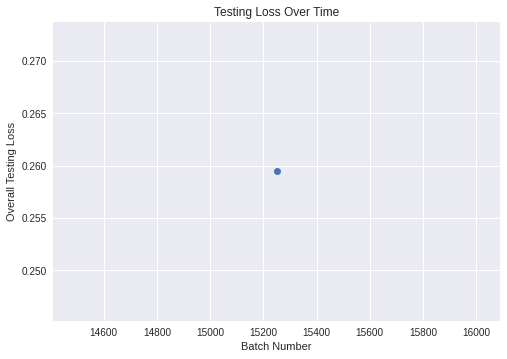

In [91]:
weight_fnames = os.listdir('./saved_weights3/')
weight_fnames.sort() # isnt perfectly sorted, but too lazy to add the code (not important)
batch_sizes = []
losses = []

for fname in weight_fnames:
    
    print(f'Loading: {fname}\n')

    checkpoint = torch.load(f'./saved_weights3/{fname}', map_location=device)
    
    # network weights load
    net = torchvision.models.resnet50(pretrained=True).to(device)
    
    # for feature extraction
    #for param in net.parameters():
        #param.requires_grad = False
        
    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
               nn.Linear(num_ftrs, 300),
               nn.BatchNorm1d(300),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(300, 100),
               nn.BatchNorm1d(100),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(100, 1),
               nn.Sigmoid()).to(device)

    net.load_state_dict(checkpoint['model_state_dict'])  
    criterion = nn.BCELoss()
    
    net.eval()
    
    # set start time for cnn training
    start_time = time.time()
    
    ground_truths = []
    probs = []

    running_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, testdata in enumerate(test_loader, 0):
            
            image, label = testdata
            image, label = image.to(device), label.to(device)

            # calculate outputs by running images through the network 
            outputs = net(image)
            
            loss = criterion(outputs, label.unsqueeze(-1).float())
            running_loss += loss.item()
        
            # everything saved should be on RAM
            #outputs = outputs.to("cpu")
            #label = label.to("cpu")
            
            # save for analysis
            ground_truths.append(label)
            
            # # save for analysis
            probs += outputs.squeeze(-1).tolist()

            if i % 10 == 0:
                print(f"\t Processing Batch #{i} ... Running Time {time.time() - start_time}")
                print(f'\t Current Testing Loss: {running_loss / (i+1)}\n')

                
    print(f'******* Final Testing Loss: {running_loss / (i+1)} *******\n')

    batch_sizes.append(checkpoint['mini_batch'])
    losses.append(running_loss / (i+1))
                
    # Save ground-truths and probability results¶
    res = {}
    res["ground_truths"] = ground_truths
    res["probs"] = probs
    res["num_batches"] = checkpoint['mini_batch']
    res["testing_loss"] = running_loss / (i+1)

    pkl_f_name = f'./saved_results3/results_ResNet50_{checkpoint["mini_batch"]}b.pkl'
    with open(pkl_f_name, 'wb') as f:
        pickle.dump(res, f)

        
plt.plot(batch_sizes, losses, 'o')
plt.title("Testing Loss Over Time")
plt.xlabel("Batch Number")
plt.ylabel("Overall Testing Loss")
plt.show()

## Choose the results from the best performing model (training size)

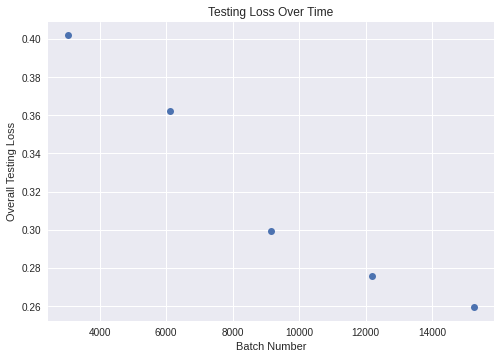

In [92]:
plt.style.use('seaborn')

# in case pkl results were calculated in batch job
# we may wont to visualize the test plot over time
recalc_loss_plot = True

if recalc_loss_plot:
    
    batch_sizes = []
    losses = []
    res_fnames = os.listdir('./saved_results3/')
    
    for fname in res_fnames:
        with open(f'./saved_results3/{fname}', 'rb') as f:
            res = pickle.load(f)
            batch_sizes.append(res["num_batches"])
            losses.append(res["testing_loss"])    
            
    
    plt.plot(batch_sizes, losses, 'o')
    plt.title("Testing Loss Over Time")
    plt.xlabel("Batch Number")
    plt.ylabel("Overall Testing Loss")
    plt.show()

In [93]:
best_batch_size = 15250


with open(f'./saved_results3/results_ResNet50_{best_batch_size}b.pkl', 'rb') as f:
    res = pickle.load(f)
    
    
gt = res["ground_truths"]
probs = np.array(res["probs"])


# match formats (shouldve done this before, forgot to check)
ground_truths = []
for i in range(len(gt)):
    if gt[i].size() > torch.Size([1]):
        ground_truths += gt[i].squeeze(-1).tolist()
    else:
        ground_truths.append(gt[i].squeeze(-1).tolist())
        
ground_truths = np.array(ground_truths)

## Testing Results

Max F2-Score is: 0.33877551020408164
Max G-Mean is: 0.8138357418733508
Max Cohen's Kappa is: 0.24255375479869146
Area Under the ROC Curve: 0.884967608877827 



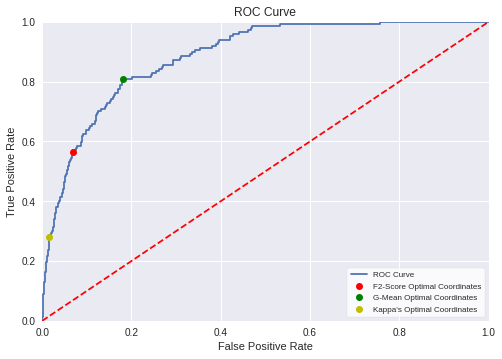


********************* USING F2-SCORE OPTIMAL THRESHOLD *************************
The confusion matrix is:
 [[7580  554]
 [  64   83]] 

Recall / Sensitivity: 0.564625850340136
Precision: 0.130298273155416
Specificity: 0.9318908286206049
F2-Score: 0.33877551020408164
G-Mean: 0.7253755244934055
Cohen's Kappa: 0.188320872903617
********************************************************************************


********************** USING G-MEAN OPTIMAL THRESHOLD **************************
The confusion matrix is:
 [[6655 1479]
 [  29  118]] 

Recall / Sensitivity: 0.8095238095238095
Precision: 0.07388854101440201
Specificity: 0.8181706417506762
F2-Score: 0.2700228832951945
G-Mean: 0.8138357418733508
Cohen's Kappa: 0.10626538642277517
********************************************************************************


********************** USING KAPPA OPTIMAL THRESHOLD ***************************
The confusion matrix is:
 [[8003  131]
 [ 106   41]] 

Recall / Sensitivity: 0.278911564625850

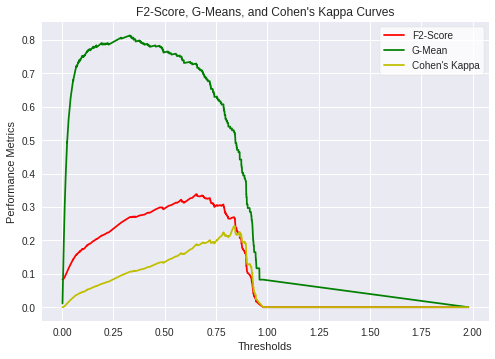

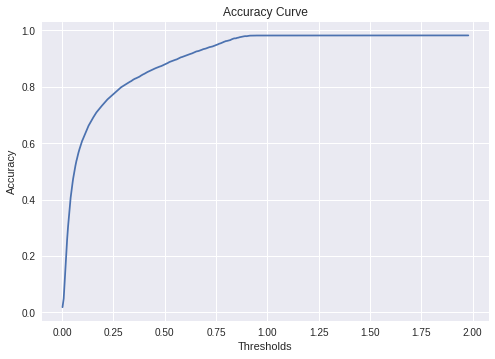

In [94]:
import warnings
warnings.filterwarnings('ignore')

fpr, tpr, thresholds = metrics.roc_curve(ground_truths, probs)
recall = tpr

# compute other metrics using the same thresholds
specificity = np.zeros_like(tpr)
precision = np.zeros_like(tpr)
fbetascores = np.zeros_like(tpr)
CKappas = np.zeros_like(tpr)

for i in range(len(thresholds)):
    preds = probs > thresholds[i]
    tn, fp, fn, tp = metrics.confusion_matrix(ground_truths, preds).ravel()
    
    specificity[i] = tn / (tn + fp)
    precision[i] = tp / (tp + fp)
    
    # more attention put on recall, such as when false negatives are more important to
    # minimize, but false positives are still important.
    fbetascores[i] = metrics.fbeta_score(ground_truths, preds, beta = 2)
    
    CKappas[i] = metrics.cohen_kappa_score(ground_truths, preds,)
    


gmeans = np.sqrt(specificity * recall)


print("Max F2-Score is:", np.nanmax(fbetascores))
print("Max G-Mean is:", np.nanmax(gmeans))
print("Max Cohen's Kappa is:", np.nanmax(CKappas))


print("Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs), "\n")

plt.plot(fpr, tpr)
plt.plot(fpr[np.nanargmax(fbetascores)], tpr[np.nanargmax(fbetascores)], 'ro')
plt.plot(fpr[np.nanargmax(gmeans)], tpr[np.nanargmax(gmeans)], 'go')
plt.plot(fpr[np.nanargmax(CKappas)], tpr[np.nanargmax(CKappas)], 'yo')
plt.plot([0, 1], [0, 1], 'r--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.legend(['ROC Curve', 'F2-Score Optimal Coordinates', 'G-Mean Optimal Coordinates', 
            "Kappa's Optimal Coordinates"], loc='lower right', prop={'size': 8}, 
           frameon=True, facecolor = 'white')
plt.show()

fb_opt_thresh = thresholds[np.nanargmax(fbetascores)]
fb_opt_preds = probs > fb_opt_thresh

print('\n********************* USING F2-SCORE OPTIMAL THRESHOLD *************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, fb_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(fbetascores)] )
print("Precision:",  precision[np.nanargmax(fbetascores)] )
print("Specificity:",  specificity[np.nanargmax(fbetascores)] )
print("F2-Score:", fbetascores[np.nanargmax(fbetascores)] )
print("G-Mean:", gmeans[np.nanargmax(fbetascores)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(fbetascores)] )
print('********************************************************************************\n')

gm_opt_thresh = thresholds[np.nanargmax(gmeans)]
gm_opt_preds = probs > gm_opt_thresh

print('\n********************** USING G-MEAN OPTIMAL THRESHOLD **************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, gm_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(gmeans)] )
print("Precision:",  precision[np.nanargmax(gmeans)] )
print("Specificity:",  specificity[np.nanargmax(gmeans)] )
print("F2-Score:", fbetascores[np.nanargmax(gmeans)] )
print("G-Mean:", gmeans[np.nanargmax(gmeans)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(gmeans)] )
print('********************************************************************************\n')


ck_opt_thresh = thresholds[np.nanargmax(CKappas)]
ck_opt_preds = probs > ck_opt_thresh

print('\n********************** USING KAPPA OPTIMAL THRESHOLD ***************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, ck_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(CKappas)] )
print("Precision:",  precision[np.nanargmax(CKappas)] )
print("Specificity:",  specificity[np.nanargmax(CKappas)] )
print("F2-Score:", fbetascores[np.nanargmax(CKappas)] )
print("G-Mean:", gmeans[np.nanargmax(CKappas)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(CKappas)] )
print('********************************************************************************\n')


accuracy_scores = []
for thresh in thresholds:
    accuracy_scores.append(metrics.accuracy_score(ground_truths, [m > thresh for m in probs]))



plt.plot(thresholds, fbetascores, "-r")
plt.plot(thresholds, gmeans, "-g")
plt.plot(thresholds, CKappas, "-y")
plt.title("F2-Score, G-Means, and Cohen's Kappa Curves")
plt.xlabel("Thresholds")
plt.ylabel("Performance Metrics")
plt.legend(['F2-Score', 'G-Mean', "Cohen's Kappa"], loc='upper right',
           frameon=True, facecolor = 'white')
plt.show()    
    

plt.plot(thresholds, accuracy_scores)
plt.title("Accuracy Curve")
plt.xlabel("Thresholds")
plt.ylabel("Accuracy")
plt.show()